In [61]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal, norm
from scipy.stats import multivariate_normal as ss_multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import scipy
from scipy.spatial import distance

In [62]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)
subkeys1 = random.split(key1, 5000)

In [63]:
def simulate_gandk(theta, num_samples, c = 0.8):
    zu = np.random.randn(num_samples,1)
    f = (theta[0] + theta[1] * (1 + c * (1 - np.exp(-theta[2] * zu)) / (1 + np.exp(-theta[2] * zu))) * (1 + zu**2)**theta[3] * zu)
    return f

def compute_summary_statistics(y):
    quant_y = []
    for i in np.arange(0.125, 1, 0.125):
        quant_y.append(np.quantile(y, i))
    Sa = quant_y[3]
    Sb = quant_y[5] - quant_y[1]
    Sc = (quant_y[5] + quant_y[1] - 2 * quant_y[3]) / Sb
    Sd = (quant_y[6] - quant_y[4] + quant_y[2] - quant_y[0]) / Sb
    return np.array([Sa, Sb, Sc, Sd])

In [64]:
true_theta = np.array([3, 1, 2, 0.5])
num_coeffs = 4
num_latent = 4
num_datasets = 200
n_samples = 500

In [65]:
actual_data = simulate_gandk(true_theta, n_samples)
actual_data

array([[ 4.82506342],
       [ 3.91692443],
       [ 2.60058613],
       [ 3.46256132],
       [ 3.24031134],
       [ 2.78209415],
       [ 3.08502016],
       [ 7.73452158],
       [ 8.44434845],
       [ 2.90572962],
       [ 2.14842603],
       [ 2.73750897],
       [ 2.48628434],
       [ 2.49723215],
       [ 4.66587656],
       [ 2.78664268],
       [ 2.87720261],
       [ 2.50013657],
       [ 2.91847487],
       [ 5.68085451],
       [ 3.17021888],
       [ 2.50478155],
       [ 2.65373433],
       [ 2.61440413],
       [ 6.34159918],
       [ 4.8106087 ],
       [ 5.9804728 ],
       [ 2.40858763],
       [15.20069841],
       [ 3.24832054],
       [ 3.10373906],
       [ 2.89562135],
       [ 4.89905034],
       [ 3.67324545],
       [ 4.77886706],
       [ 3.00028155],
       [ 2.609636  ],
       [ 3.3721191 ],
       [ 2.96861391],
       [ 2.79631218],
       [ 2.06820554],
       [ 6.00527794],
       [ 3.08485825],
       [ 2.37476385],
       [ 2.73618342],
       [ 8

In [66]:
actual_summary_statistics = compute_summary_statistics(actual_data)
actual_summary_statistics

array([2.94188967, 1.5289357 , 0.54282829, 1.98354778])

In [67]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

In [68]:
actual_summary_statistics = np.array([2.96978227, 1.45609898, 0.4837584 , 2.00723605])

## Training Wasserstein Gaussianing

In [69]:
len_ss = np.shape(actual_summary_statistics)[0]
wass_num_datasets = 10000
wass_val_num_datasets = 10000
wass_n_samples = 30
d_Lambda = 2 + len_ss
num_layers = 16
# To optimize F
tau = 0.01
stop_f = 10000
learning_rate = 0.005
l_threshold = 10
threshold = stop_f/2
adaptive_lr_1 = 0.9
adaptive_lr_2 = 0.9
t_w_f = 50
Patience_f = 51
batch_size = 5
# To optimize LB
stop = 5000
Patience = 20

In [70]:
wass_n_summary_statistics = np.zeros((wass_num_datasets, num_latent))
for i in range(0, wass_num_datasets):
    y = simulate_gandk(true_theta, wass_n_samples)
    wass_n_summary_statistics[i,:] = compute_summary_statistics(y)
original_n_summary_statistics = wass_n_summary_statistics

In [71]:
val_n_summary_statistics = np.zeros((wass_num_datasets, num_latent))
for i in range(0, wass_num_datasets):
    y = simulate_gandk(true_theta, wass_n_samples)
    val_n_summary_statistics[i,:] = compute_summary_statistics(y)

In [72]:
scaler_mean = jnp.mean(original_n_summary_statistics, axis=0)
scaler_std = jnp.std(original_n_summary_statistics, axis=0)

In [73]:
scaler_mean

Array([3.0473683 , 1.6265604 , 0.41341704, 1.7617831 ], dtype=float32)

In [74]:
scaler_std

Array([0.25040185, 0.64111286, 0.22021407, 0.72472376], dtype=float32)

In [75]:
wass_n_summary_statistics = (wass_n_summary_statistics - scaler_mean) / scaler_std

In [76]:
def radial_flow(Lambda, x):
    # original_x = x
    d_Lambda = 2 + len_ss
    logdet_jacob_T_x = 0
    for k in range(num_layers):
        # print(k)
        Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
        alpha = jnp.exp(Lambda_k[0])
        beta = -alpha + jnp.exp(Lambda_k[1])
        beta = tau * beta
        mu = Lambda_k[2:]
        # r_x = jnp.linalg.norm(x - mu)
        r_x = jnp.sqrt(jnp.dot((x - mu).T, (x - mu)))
        x = x + beta / (alpha + r_x) * (x - mu)
        logdet_jacob_T_x += jnp.log(1 + alpha * beta / (alpha + r_x)**2) + (len_ss - 1) * jnp.log(1 + beta / (alpha + r_x))
        # f = - logdet_jacob_T_x + 1/2 * T_x.T @ T_x + 1/(2*0.1) * (jnp.linalg.norm(x - T_x))**2
    return x, logdet_jacob_T_x

In [77]:
def f_with_Lambda(Lambda, x):
    N_samples, _ = x.shape
    f = 0.0
    for i in range(N_samples):
        x_i = x[i, :]
        T_x_i, log_Jacobian = radial_flow(Lambda, x_i)
        diff = x_i - T_x_i
        f = f - log_Jacobian + 1/2 * T_x_i.T @ T_x_i + 0.5 / 0.1 * jnp.dot(diff.T, diff)
    f /= N_samples
    return f

In [78]:
def kl(x):
    return 1/2 * x.T @ x

In [79]:
Lambda = random.normal(subkeys[5], (num_layers * d_Lambda,))

def numerical_grad(Lambda, x):
    epsilon = 1e-3
    grad = []
    perturbed_Lambda = Lambda
    for i in range(Lambda.shape[0]):
        perturbed_Lambda = Lambda.at[i].set(Lambda[i] + epsilon)
        grad_i = (f_with_Lambda(perturbed_Lambda, x) - f_with_Lambda(Lambda, x)) / epsilon
        grad.append(grad_i)
    return jnp.array(grad)

# Compute the gradient using jax.grad
grad_f_with_Lambda = grad(f_with_Lambda, argnums=0)(Lambda, wass_n_summary_statistics[:5])

# Compute the numerical gradient
numerical_grad_f = numerical_grad(Lambda, wass_n_summary_statistics[:5])

# Compare the gradients
print("Gradient computed by jax.grad:", grad_f_with_Lambda)
print("Numerical gradient:", numerical_grad_f)

Gradient computed by jax.grad: [-4.16685361e-04  2.03825068e-04 -4.13322472e-04  1.07338419e-03
 -5.08345256e-04  3.41197272e-04  6.96763513e-04 -9.27567249e-04
 -1.75856927e-04  8.14552885e-04 -4.39460680e-04  6.42672181e-04
  2.29162909e-03 -2.94645270e-03  8.82965833e-05  2.18198169e-04
 -1.22941303e-04  5.34960855e-05  1.53246277e-03 -1.63697917e-03
 -6.54914620e-05  1.37811614e-04 -4.58344766e-05  8.03602161e-05
  2.01475201e-03 -1.00889464e-03 -7.41078402e-05 -1.48146972e-03
  6.98826276e-04 -3.03330511e-04  2.81860074e-03 -3.76415020e-03
  3.59818427e-04  4.58265975e-04 -2.61439563e-04 -2.89235031e-05
 -2.87303538e-03  1.59794055e-02 -5.95794059e-03  4.57295356e-03
 -3.12599563e-03  6.08235423e-04 -9.12708975e-03  1.35736465e-02
 -1.05387960e-02  1.41797680e-02 -6.30808435e-03  8.59628711e-03
 -2.47896696e-03  9.63702612e-03 -1.08602864e-03  2.39315559e-03
  9.59460274e-04  2.90337740e-03  5.17710170e-04 -4.11257322e-04
  9.33679039e-05 -1.97385525e-04  1.09658125e-04 -3.1442650

In [80]:
transform_auto = vmap(radial_flow, in_axes=[None, 0])
kl_auto = vmap(kl)
KL_all = []
Lambda_list = []
patience = 0
Lambda = 0.01 * random.normal(subkeys[0], (num_layers * d_Lambda,))
kl_helper = jnp.sum(norm.logpdf(original_n_summary_statistics), axis=1)
for k in tqdm(range(stop)):
    f_all = []
    F_Smoothed = []
    patience_f = 0
    # Lambda = random.uniform(subkeys[k], (num_layers * d_Lambda,), minval=0, maxval=10).reshape(num_layers, d_Lambda)
    for t in range(stop_f):
        # Batch data
        random_row_indices = random.permutation(subkeys1[t], wass_num_datasets)[:batch_size]
        # Select the rows from the matrix using the random row indices
        subset_n_summary_statistics = wass_n_summary_statistics[random_row_indices, :]
        grad_lambda = grad(f_with_Lambda, argnums=0)(Lambda, subset_n_summary_statistics)
        f_t = f_with_Lambda(Lambda, subset_n_summary_statistics)
        if t == 0:
            # Update lambda_q
            g_lambda_init = grad_lambda
            if jnp.linalg.norm(g_lambda_init) > l_threshold:
                g_lambda_init = l_threshold * g_lambda_init / jnp.linalg.norm(g_lambda_init)
            v_lambda_init = g_lambda_init ** 2
        else:
            # Update lambda_q
            g_lambda_t = grad_lambda
            if jnp.linalg.norm(g_lambda_t) > l_threshold:
                g_lambda_t = l_threshold * g_lambda_t / jnp.linalg.norm(g_lambda_t)
            v_lambda_t = g_lambda_t ** 2
            #---- Update lambda
            g_lambda_init = adaptive_lr_1 * g_lambda_init + (1 - adaptive_lr_1) * g_lambda_t
            v_lambda_init = adaptive_lr_2 * v_lambda_init + (1 - adaptive_lr_2) * v_lambda_t
        if t >= threshold:
            update_t = learning_rate * threshold / t
        else:
            update_t = learning_rate
        Lambda = Lambda - update_t * g_lambda_init / (v_lambda_init ** 0.5)
        # Calculate lower bound
        f_all.append(f_t)
        if t >= t_w_f:
            f_smoothed = jnp.mean(jnp.array(f_all[t - t_w_f + 1 : t]))
            print('F Smoothed', f_smoothed)
            F_Smoothed.append(f_smoothed)
            if f_smoothed <= jnp.min(jnp.array(F_Smoothed)):
                patience_f = 0
                lambda_best = Lambda
            else:
                patience_f += 1
                if patience_f > Patience_f:
                    print("Stop at", t)
                    break
    Lambda_list.append(lambda_best)
    wass_n_summary_statistics = transform_auto(lambda_best, wass_n_summary_statistics)[0]
    kl_helper = kl_helper - transform_auto(lambda_best, wass_n_summary_statistics)[1]
    kl_k = jnp.mean(kl_helper + kl_auto(wass_n_summary_statistics))
    KL_all.append(kl_k)
    print('>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<<', kl_k)
    if kl_k > jnp.min(jnp.array(KL_all)):
        patience += 1
    else:
        patience = 0
        transformed_n_summary_statistics = wass_n_summary_statistics
    if patience > Patience:
        print("Stop at", k)
        break

  0%|          | 0/5000 [00:00<?, ?it/s]

F Smoothed 1.9971817
F Smoothed 2.0177293
F Smoothed 1.9787024
F Smoothed 1.9634804
F Smoothed 1.9744288
F Smoothed 1.977312
F Smoothed 1.9699776
F Smoothed 1.9793854
F Smoothed 1.9727206
F Smoothed 1.944695
F Smoothed 1.9804288
F Smoothed 1.9646873
F Smoothed 1.9507306
F Smoothed 1.9623628
F Smoothed 2.009917
F Smoothed 2.0067527
F Smoothed 2.000539
F Smoothed 1.9981979
F Smoothed 2.0425642
F Smoothed 2.0191903
F Smoothed 2.021291
F Smoothed 2.0279322
F Smoothed 2.0128925
F Smoothed 2.0333443
F Smoothed 2.1080878
F Smoothed 2.1410637
F Smoothed 2.151041
F Smoothed 2.1658697
F Smoothed 2.210252
F Smoothed 2.1640801
F Smoothed 2.1720827
F Smoothed 2.1631768
F Smoothed 2.1559925
F Smoothed 2.1580389
F Smoothed 2.1126025
F Smoothed 2.1615725
F Smoothed 2.1447742
F Smoothed 2.1461782
F Smoothed 2.1353223
F Smoothed 2.114063
F Smoothed 2.13207
F Smoothed 2.1253874
F Smoothed 2.033926
F Smoothed 2.0183423
F Smoothed 2.0045338
F Smoothed 2.007895
F Smoothed 2.0196009
F Smoothed 2.0190327
F Sm

  0%|          | 1/5000 [04:43<394:11:03, 283.87s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.806702
F Smoothed 2.02161
F Smoothed 2.0420532
F Smoothed 2.0021667
F Smoothed 1.9866093
F Smoothed 1.9977664
F Smoothed 2.0009742
F Smoothed 1.9935776
F Smoothed 2.0029728
F Smoothed 1.9962999
F Smoothed 1.9677627
F Smoothed 2.0040073
F Smoothed 1.9878496
F Smoothed 1.9735779
F Smoothed 1.9856749
F Smoothed 2.0339296
F Smoothed 2.030787
F Smoothed 2.024404
F Smoothed 2.0220702
F Smoothed 2.067086
F Smoothed 2.043438
F Smoothed 2.0455267
F Smoothed 2.0522563
F Smoothed 2.0369637
F Smoothed 2.0577722
F Smoothed 2.133138
F Smoothed 2.1665986
F Smoothed 2.1770928
F Smoothed 2.192347
F Smoothed 2.2371728
F Smoothed 2.1903899
F Smoothed 2.1985993
F Smoothed 2.1894352
F Smoothed 2.1818972
F Smoothed 2.1838803
F Smoothed 2.1378808
F Smoothed 2.1876202
F Smoothed 2.170575
F Smoothed 2.172082
F Smoothed 2.1609373
F Smoothed 2.1395018
F Smoothed 2.1579356
F Smoothed 2.1511407
F Smoothed 2.0590687
F Smoothed 2.043136
F Smoothed 2.029228
F Smoo

  0%|          | 2/5000 [09:29<395:19:05, 284.74s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.812258
F Smoothed 2.0580952
F Smoothed 2.0785537
F Smoothed 2.0380921
F Smoothed 2.0223224
F Smoothed 2.033682
F Smoothed 2.0370364
F Smoothed 2.029603
F Smoothed 2.039015
F Smoothed 2.0322945
F Smoothed 2.003344
F Smoothed 2.0400772
F Smoothed 2.02361
F Smoothed 2.0090346
F Smoothed 2.0215075
F Smoothed 2.070355
F Smoothed 2.0672417
F Smoothed 2.0606642
F Smoothed 2.0583067
F Smoothed 2.1038558
F Smoothed 2.079934
F Smoothed 2.0820277
F Smoothed 2.0888221
F Smoothed 2.0733702
F Smoothed 2.094437
F Smoothed 2.1703298
F Smoothed 2.2042363
F Smoothed 2.215088
F Smoothed 2.2306695
F Smoothed 2.2759035
F Smoothed 2.2286437
F Smoothed 2.2369926
F Smoothed 2.2276144
F Smoothed 2.219787
F Smoothed 2.2217283
F Smoothed 2.175304
F Smoothed 2.2257278
F Smoothed 2.2084858
F Smoothed 2.210066
F Smoothed 2.1986747
F Smoothed 2.177041
F Smoothed 2.1957626
F Smoothed 2.1889038
F Smoothed 2.0962784
F Smoothed 2.08007
F Smoothed 2.0660887
F Smoothed

  0%|          | 3/5000 [14:25<402:16:13, 289.81s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.817585
F Smoothed 2.0948088
F Smoothed 2.115312
F Smoothed 2.0743742
F Smoothed 2.0584292
F Smoothed 2.0699818
F Smoothed 2.0734384
F Smoothed 2.065979
F Smoothed 2.0754297
F Smoothed 2.0686588
F Smoothed 2.0393395
F Smoothed 2.0765266
F Smoothed 2.0597916
F Smoothed 2.0449812
F Smoothed 2.0577586
F Smoothed 2.107139
F Smoothed 2.104058
F Smoothed 2.0973127
F Smoothed 2.094925
F Smoothed 2.14096
F Smoothed 2.116785
F Smoothed 2.1188889
F Smoothed 2.1257467
F Smoothed 2.110151
F Smoothed 2.1314385
F Smoothed 2.2078164
F Smoothed 2.2421296
F Smoothed 2.2532885
F Smoothed 2.2691717
F Smoothed 2.3147864
F Smoothed 2.2670944
F Smoothed 2.2755663
F Smoothed 2.266002
F Smoothed 2.2579074
F Smoothed 2.2598176
F Smoothed 2.2130077
F Smoothed 2.26404
F Smoothed 2.2466085
F Smoothed 2.248248
F Smoothed 2.2366564
F Smoothed 2.2148473
F Smoothed 2.2337859
F Smoothed 2.226868
F Smoothed 2.1337006
F Smoothed 2.1172674
F Smoothed 2.1032157
F Smooth

  0%|          | 4/5000 [19:34<412:50:07, 297.48s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.822144
F Smoothed 2.1290252
F Smoothed 2.1495748
F Smoothed 2.1082308
F Smoothed 2.0921369
F Smoothed 2.103856
F Smoothed 2.107396
F Smoothed 2.0999105
F Smoothed 2.1094074
F Smoothed 2.102589
F Smoothed 2.0729547
F Smoothed 2.1105356
F Smoothed 2.0935738
F Smoothed 2.0785868
F Smoothed 2.0915635
F Smoothed 2.141402
F Smoothed 2.138342
F Smoothed 2.131473
F Smoothed 2.129058
F Smoothed 2.1755192
F Smoothed 2.151128
F Smoothed 2.1532412
F Smoothed 2.1601572
F Smoothed 2.1444294
F Smoothed 2.1658993
F Smoothed 2.2427113
F Smoothed 2.277377
F Smoothed 2.2887826
F Smoothed 2.3049164
F Smoothed 2.3508682
F Smoothed 2.3027987
F Smoothed 2.311378
F Smoothed 2.301658
F Smoothed 2.2933311
F Smoothed 2.295216
F Smoothed 2.248059
F Smoothed 2.2996087
F Smoothed 2.2820039
F Smoothed 2.2836838
F Smoothed 2.2719283
F Smoothed 2.2499728
F Smoothed 2.2690825
F Smoothed 2.2621138
F Smoothed 2.168439
F Smoothed 2.1518188
F Smoothed 2.1376977
F Smooth

  0%|          | 5/5000 [24:38<415:59:00, 299.81s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.825753
F Smoothed 2.1591263
F Smoothed 2.1797206
F Smoothed 2.1380386
F Smoothed 2.1218178
F Smoothed 2.1336715
F Smoothed 2.1372755
F Smoothed 2.1297607
F Smoothed 2.1393068
F Smoothed 2.132446
F Smoothed 2.1025505
F Smoothed 2.140456
F Smoothed 2.1233065
F Smoothed 2.1081848
F Smoothed 2.1213057
F Smoothed 2.171528
F Smoothed 2.16848
F Smoothed 2.1615183
F Smoothed 2.159082
F Smoothed 2.2059035
F Smoothed 2.1813343
F Smoothed 2.1834521
F Smoothed 2.190419
F Smoothed 2.1745791
F Smoothed 2.1961997
F Smoothed 2.2733855
F Smoothed 2.3083506
F Smoothed 2.3199427
F Smoothed 2.3362753
F Smoothed 2.3825142
F Smoothed 2.3341277
F Smoothed 2.3427987
F Smoothed 2.3329482
F Smoothed 2.3244262
F Smoothed 2.3262851
F Smoothed 2.2788303
F Smoothed 2.3308146
F Smoothed 2.3130603
F Smoothed 2.3147652
F Smoothed 2.3028708
F Smoothed 2.2807977
F Smoothed 2.300055
F Smoothed 2.293048
F Smoothed 2.1989348
F Smoothed 2.182153
F Smoothed 2.1679695
F Sm

  0%|          | 6/5000 [29:08<401:44:45, 289.60s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.8285
F Smoothed 2.1846776
F Smoothed 2.2053118
F Smoothed 2.1633487
F Smoothed 2.1470218
F Smoothed 2.1589847
F Smoothed 2.1626403
F Smoothed 2.1550984
F Smoothed 2.16469
F Smoothed 2.1577933
F Smoothed 2.127678
F Smoothed 2.1658514
F Smoothed 2.1485467
F Smoothed 2.1333158
F Smoothed 2.1465595
F Smoothed 2.1971028
F Smoothed 2.1940627
F Smoothed 2.1870253
F Smoothed 2.1845727
F Smoothed 2.2316976
F Smoothed 2.2069814
F Smoothed 2.2091017
F Smoothed 2.2161107
F Smoothed 2.2001786
F Smoothed 2.2219243
F Smoothed 2.2994258
F Smoothed 2.3346457
F Smoothed 2.3463857
F Smoothed 2.3628802
F Smoothed 2.4093611
F Smoothed 2.3607106
F Smoothed 2.3694599
F Smoothed 2.359498
F Smoothed 2.350809
F Smoothed 2.3526428
F Smoothed 2.3049376
F Smoothed 2.357287
F Smoothed 2.3394084
F Smoothed 2.34113
F Smoothed 2.3291142
F Smoothed 2.3069477
F Smoothed 2.3263354
F Smoothed 2.3192985
F Smoothed 2.2248204
F Smoothed 2.207898
F Smoothed 2.1936615
F Smo

  0%|          | 7/5000 [33:55<400:49:22, 289.00s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.830563
F Smoothed 2.2060394
F Smoothed 2.2267063
F Smoothed 2.1845071
F Smoothed 2.1680918
F Smoothed 2.1801453
F Smoothed 2.183844
F Smoothed 2.1762788
F Smoothed 2.1859093
F Smoothed 2.1789818
F Smoothed 2.1486795
F Smoothed 2.1870775
F Smoothed 2.1696422
F Smoothed 2.1543171
F Smoothed 2.167671
F Smoothed 2.2184844
F Smoothed 2.2154512
F Smoothed 2.2083478
F Smoothed 2.2058818
F Smoothed 2.2532623
F Smoothed 2.2284245
F Smoothed 2.2305455
F Smoothed 2.2375894
F Smoothed 2.2215805
F Smoothed 2.2434316
F Smoothed 2.321197
F Smoothed 2.3566337
F Smoothed 2.368499
F Smoothed 2.3851306
F Smoothed 2.431815
F Smoothed 2.3829443
F Smoothed 2.3917596
F Smoothed 2.3817017
F Smoothed 2.3728697
F Smoothed 2.3746784
F Smoothed 2.3267643
F Smoothed 2.3794217
F Smoothed 2.3614404
F Smoothed 2.3631744
F Smoothed 2.3510523
F Smoothed 2.328811
F Smoothed 2.3483126
F Smoothed 2.3412523
F Smoothed 2.2464724
F Smoothed 2.2294273
F Smoothed 2.2151487


  0%|          | 8/5000 [38:15<387:46:38, 279.65s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.832115
F Smoothed 2.223816
F Smoothed 2.2445087
F Smoothed 2.2021108
F Smoothed 2.1856208
F Smoothed 2.1977503
F Smoothed 2.2014866
F Smoothed 2.1939025
F Smoothed 2.2035646
F Smoothed 2.196611
F Smoothed 2.1661484
F Smoothed 2.2047365
F Smoothed 2.1871893
F Smoothed 2.1717823
F Smoothed 2.185235
F Smoothed 2.236277
F Smoothed 2.2332504
F Smoothed 2.2260878
F Smoothed 2.2236106
F Smoothed 2.2712078
F Smoothed 2.246268
F Smoothed 2.2483895
F Smoothed 2.2554617
F Smoothed 2.2393885
F Smoothed 2.261328
F Smoothed 2.3393142
F Smoothed 2.374935
F Smoothed 2.3869119
F Smoothed 2.4036615
F Smoothed 2.4505186
F Smoothed 2.401463
F Smoothed 2.410334
F Smoothed 2.4001918
F Smoothed 2.3912356
F Smoothed 2.3930216
F Smoothed 2.3449342
F Smoothed 2.3978515
F Smoothed 2.3797855
F Smoothed 2.3815296
F Smoothed 2.3693147
F Smoothed 2.3470135
F Smoothed 2.3666136
F Smoothed 2.359534
F Smoothed 2.2645044
F Smoothed 2.2473536
F Smoothed 2.2330413
F Sm

  0%|          | 9/5000 [42:32<377:59:53, 272.65s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.833294
F Smoothed 2.2386181
F Smoothed 2.2593303
F Smoothed 2.2167637
F Smoothed 2.200212
F Smoothed 2.212406
F Smoothed 2.2161746
F Smoothed 2.2085755
F Smoothed 2.2182636
F Smoothed 2.2112875
F Smoothed 2.1806872
F Smoothed 2.2194376
F Smoothed 2.201794
F Smoothed 2.186315
F Smoothed 2.1998556
F Smoothed 2.251091
F Smoothed 2.2480712
F Smoothed 2.2408557
F Smoothed 2.2383687
F Smoothed 2.2861497
F Smoothed 2.2611244
F Smoothed 2.263246
F Smoothed 2.270342
F Smoothed 2.2542136
F Smoothed 2.2762272
F Smoothed 2.3543978
F Smoothed 2.3901744
F Smoothed 2.4022517
F Smoothed 2.4191065
F Smoothed 2.4661093
F Smoothed 2.416898
F Smoothed 2.4258158
F Smoothed 2.4156005
F Smoothed 2.4065356
F Smoothed 2.4083023
F Smoothed 2.3600712
F Smoothed 2.4132063
F Smoothed 2.3950725
F Smoothed 2.3968256
F Smoothed 2.384532
F Smoothed 2.362182
F Smoothed 2.381867
F Smoothed 2.3747702
F Smoothed 2.2795327
F Smoothed 2.2622929
F Smoothed 2.247955
F Smoo

  0%|          | 10/5000 [46:39<366:53:46, 264.69s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.834197
F Smoothed 2.250942
F Smoothed 2.271668
F Smoothed 2.2289617
F Smoothed 2.2123616
F Smoothed 2.2246082
F Smoothed 2.2284033
F Smoothed 2.2207944
F Smoothed 2.2305017
F Smoothed 2.2235076
F Smoothed 2.1927912
F Smoothed 2.2316809
F Smoothed 2.2139533
F Smoothed 2.198411
F Smoothed 2.212027
F Smoothed 2.2634225
F Smoothed 2.2604108
F Smoothed 2.253148
F Smoothed 2.2506514
F Smoothed 2.2985864
F Smoothed 2.2734885
F Smoothed 2.2756107
F Smoothed 2.282727
F Smoothed 2.266551
F Smoothed 2.288626
F Smoothed 2.3669474
F Smoothed 2.4028528
F Smoothed 2.4150202
F Smoothed 2.4319704
F Smoothed 2.4790957
F Smoothed 2.4297535
F Smoothed 2.4387095
F Smoothed 2.4284315
F Smoothed 2.4192708
F Smoothed 2.4210231
F Smoothed 2.3726764
F Smoothed 2.4259892
F Smoothed 2.4078026
F Smoothed 2.4095669
F Smoothed 2.3972085
F Smoothed 2.374819
F Smoothed 2.394574
F Smoothed 2.3874593
F Smoothed 2.2920527
F Smoothed 2.2747407
F Smoothed 2.2603846
F Sm

  0%|          | 11/5000 [51:00<365:09:11, 263.49s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.834906
F Smoothed 2.261009
F Smoothed 2.2817419
F Smoothed 2.2389302
F Smoothed 2.2222977
F Smoothed 2.2345858
F Smoothed 2.2383964
F Smoothed 2.230787
F Smoothed 2.2405064
F Smoothed 2.2335002
F Smoothed 2.2026906
F Smoothed 2.2417011
F Smoothed 2.2238982
F Smoothed 2.2082999
F Smoothed 2.2219741
F Smoothed 2.2734938
F Smoothed 2.270493
F Smoothed 2.2631872
F Smoothed 2.2606795
F Smoothed 2.3087375
F Smoothed 2.283578
F Smoothed 2.2856994
F Smoothed 2.2928355
F Smoothed 2.2766213
F Smoothed 2.2987404
F Smoothed 2.3771765
F Smoothed 2.413183
F Smoothed 2.4254298
F Smoothed 2.4424682
F Smoothed 2.489692
F Smoothed 2.4402425
F Smoothed 2.4492283
F Smoothed 2.4388957
F Smoothed 2.4296498
F Smoothed 2.4313922
F Smoothed 2.382962
F Smoothed 2.4364076
F Smoothed 2.4181879
F Smoothed 2.419967
F Smoothed 2.4075549
F Smoothed 2.385136
F Smoothed 2.4049392
F Smoothed 2.397805
F Smoothed 2.302271
F Smoothed 2.2849033
F Smoothed 2.2705379
F Smo

  0%|          | 12/5000 [55:22<364:42:23, 263.22s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.835519
F Smoothed 2.2686086
F Smoothed 2.289335
F Smoothed 2.246463
F Smoothed 2.229822
F Smoothed 2.2421427
F Smoothed 2.2459521
F Smoothed 2.2383578
F Smoothed 2.2480788
F Smoothed 2.2410688
F Smoothed 2.2101877
F Smoothed 2.2493067
F Smoothed 2.2314305
F Smoothed 2.2157795
F Smoothed 2.2294939
F Smoothed 2.2810915
F Smoothed 2.2781072
F Smoothed 2.2707565
F Smoothed 2.2682362
F Smoothed 2.3163803
F Smoothed 2.291169
F Smoothed 2.2932885
F Smoothed 2.3004465
F Smoothed 2.284208
F Smoothed 2.3063476
F Smoothed 2.3848472
F Smoothed 2.4209218
F Smoothed 2.433239
F Smoothed 2.4503596
F Smoothed 2.4976494
F Smoothed 2.4481235
F Smoothed 2.4571283
F Smoothed 2.4467463
F Smoothed 2.437426
F Smoothed 2.4391563
F Smoothed 2.3906865
F Smoothed 2.4442115
F Smoothed 2.4259872
F Smoothed 2.4277854
F Smoothed 2.415322
F Smoothed 2.3928888
F Smoothed 2.4127073
F Smoothed 2.4055507
F Smoothed 2.309946
F Smoothed 2.2925394
F Smoothed 2.27818
F Smo

  0%|          | 13/5000 [59:49<366:07:07, 264.29s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.836245
F Smoothed 2.2729697
F Smoothed 2.293665
F Smoothed 2.2507913
F Smoothed 2.234174
F Smoothed 2.246525
F Smoothed 2.2503173
F Smoothed 2.2427619
F Smoothed 2.2524672
F Smoothed 2.2454638
F Smoothed 2.2145274
F Smoothed 2.2537482
F Smoothed 2.235793
F Smoothed 2.2200887
F Smoothed 2.233831
F Smoothed 2.2854486
F Smoothed 2.2824883
F Smoothed 2.2750823
F Smoothed 2.272549
F Smoothed 2.3207343
F Smoothed 2.2954874
F Smoothed 2.297604
F Smoothed 2.304788
F Smoothed 2.2885509
F Smoothed 2.310679
F Smoothed 2.3891664
F Smoothed 2.425272
F Smoothed 2.4376602
F Smoothed 2.4548597
F Smoothed 2.5021768
F Smoothed 2.4526165
F Smoothed 2.4616296
F Smoothed 2.4511974
F Smoothed 2.4418113
F Smoothed 2.4435205
F Smoothed 2.3950727
F Smoothed 2.448617
F Smoothed 2.430428
F Smoothed 2.432251
F Smoothed 2.419725
F Smoothed 2.397303
F Smoothed 2.4170923
F Smoothed 2.409911
F Smoothed 2.31432
F Smoothed 2.2968876
F Smoothed 2.2825603
F Smoothed 2

  0%|          | 14/5000 [1:05:02<386:24:36, 279.00s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.837483
F Smoothed 2.2731967
F Smoothed 2.2938251
F Smoothed 2.2510104
F Smoothed 2.2344565
F Smoothed 2.246849
F Smoothed 2.2506156
F Smoothed 2.2431316
F Smoothed 2.2527966
F Smoothed 2.24581
F Smoothed 2.214822
F Smoothed 2.2541506
F Smoothed 2.2361062
F Smoothed 2.2203453
F Smoothed 2.2341175
F Smoothed 2.2856932
F Smoothed 2.2827678
F Smoothed 2.2752872
F Smoothed 2.2727437
F Smoothed 2.3209252
F Smoothed 2.295671
F Smoothed 2.2977867
F Smoothed 2.3050036
F Smoothed 2.2888036
F Smoothed 2.3108845
F Smoothed 2.3892705
F Smoothed 2.4253745
F Smoothed 2.4378502
F Smoothed 2.4551313
F Smoothed 2.5024402
F Smoothed 2.4529002
F Smoothed 2.461911
F Smoothed 2.45142
F Smoothed 2.4419744
F Smoothed 2.4436486
F Smoothed 2.3952978
F Smoothed 2.4488077
F Smoothed 2.4306977
F Smoothed 2.432555
F Smoothed 2.4199417
F Smoothed 2.3975701
F Smoothed 2.417282
F Smoothed 2.4100757
F Smoothed 2.314604
F Smoothed 2.297159
F Smoothed 2.282903
F Smoot

  0%|          | 15/5000 [1:09:39<385:32:42, 278.43s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.839724
F Smoothed 2.2692513
F Smoothed 2.2897704
F Smoothed 2.24706
F Smoothed 2.2306094
F Smoothed 2.2430685
F Smoothed 2.2468107
F Smoothed 2.239432
F Smoothed 2.2490306
F Smoothed 2.2420657
F Smoothed 2.2110167
F Smoothed 2.2504754
F Smoothed 2.23233
F Smoothed 2.2165077
F Smoothed 2.2303243
F Smoothed 2.281807
F Smoothed 2.2789285
F Smoothed 2.27135
F Smoothed 2.268802
F Smoothed 2.316948
F Smoothed 2.2917218
F Smoothed 2.2938414
F Smoothed 2.3011
F Smoothed 2.284972
F Smoothed 2.3069744
F Smoothed 2.385181
F Smoothed 2.4212599
F Smoothed 2.4338543
F Smoothed 2.4512324
F Smoothed 2.498506
F Smoothed 2.4490385
F Smoothed 2.4580388
F Smoothed 2.4474742
F Smoothed 2.4379673
F Smoothed 2.439595
F Smoothed 2.3914135
F Smoothed 2.4448507
F Smoothed 2.4268558
F Smoothed 2.4287581
F Smoothed 2.4160328
F Smoothed 2.3937523
F Smoothed 2.4133484
F Smoothed 2.4061117
F Smoothed 2.3108597
F Smoothed 2.2934108
F Smoothed 2.2792697
F Smoothed 

  0%|          | 16/5000 [1:13:59<377:29:17, 272.66s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.843209
F Smoothed 2.2623858
F Smoothed 2.2827556
F Smoothed 2.2401662
F Smoothed 2.2238429
F Smoothed 2.2363954
F Smoothed 2.240123
F Smoothed 2.2328718
F Smoothed 2.2423816
F Smoothed 2.235437
F Smoothed 2.2043052
F Smoothed 2.2439253
F Smoothed 2.22567
F Smoothed 2.2097769
F Smoothed 2.2236593
F Smoothed 2.2750204
F Smoothed 2.2721975
F Smoothed 2.2644994
F Smoothed 2.261951
F Smoothed 2.310051
F Smoothed 2.2848897
F Smoothed 2.2870178
F Smoothed 2.294326
F Smoothed 2.2782848
F Smoothed 2.300193
F Smoothed 2.3781734
F Smoothed 2.4142172
F Smoothed 2.4269671
F Smoothed 2.444462
F Smoothed 2.4916856
F Smoothed 2.442321
F Smoothed 2.4513075
F Smoothed 2.4406528
F Smoothed 2.4310725
F Smoothed 2.432647
F Smoothed 2.3846781
F Smoothed 2.4380226
F Smoothed 2.4201655
F Smoothed 2.4221165
F Smoothed 2.409262
F Smoothed 2.3871002
F Smoothed 2.406565
F Smoothed 2.399285
F Smoothed 2.3043146
F Smoothed 2.2868636
F Smoothed 2.2728674
F Smooth

  0%|          | 17/5000 [1:17:58<363:33:03, 262.65s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.847765
F Smoothed 2.254608
F Smoothed 2.274804
F Smoothed 2.2323287
F Smoothed 2.216139
F Smoothed 2.2287993
F Smoothed 2.232524
F Smoothed 2.2254028
F Smoothed 2.2348115
F Smoothed 2.2278821
F Smoothed 2.1966484
F Smoothed 2.2364445
F Smoothed 2.218081
F Smoothed 2.2021077
F Smoothed 2.216073
F Smoothed 2.2673035
F Smoothed 2.2645352
F Smoothed 2.2567067
F Smoothed 2.2541618
F Smoothed 2.302218
F Smoothed 2.2771544
F Smoothed 2.2792945
F Smoothed 2.2866588
F Smoothed 2.2707016
F Smoothed 2.2925162
F Smoothed 2.370256
F Smoothed 2.406261
F Smoothed 2.4191897
F Smoothed 2.4368143
F Smoothed 2.4839787
F Smoothed 2.4347293
F Smoothed 2.4437008
F Smoothed 2.4329472
F Smoothed 2.423283
F Smoothed 2.4247997
F Smoothed 2.377054
F Smoothed 2.430297
F Smoothed 2.4125834
F Smoothed 2.4145772
F Smoothed 2.4015849
F Smoothed 2.3795543
F Smoothed 2.3988926
F Smoothed 2.3915582
F Smoothed 2.296889
F Smoothed 2.2794275
F Smoothed 2.2655866
F Smoot

  0%|          | 18/5000 [1:22:05<356:57:03, 257.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.852953
F Smoothed 2.2475815
F Smoothed 2.2675998
F Smoothed 2.2252266
F Smoothed 2.2091634
F Smoothed 2.2219281
F Smoothed 2.2256563
F Smoothed 2.2186542
F Smoothed 2.2279613
F Smoothed 2.2210436
F Smoothed 2.1897008
F Smoothed 2.229657
F Smoothed 2.2111998
F Smoothed 2.195146
F Smoothed 2.2092009
F Smoothed 2.2602997
F Smoothed 2.2575765
F Smoothed 2.2496188
F Smoothed 2.2470841
F Smoothed 2.295098
F Smoothed 2.2701588
F Smoothed 2.2723136
F Smoothed 2.2797387
F Smoothed 2.2638564
F Smoothed 2.285589
F Smoothed 2.3630946
F Smoothed 2.399057
F Smoothed 2.4121647
F Smoothed 2.4299164
F Smoothed 2.4770153
F Smoothed 2.4278827
F Smoothed 2.4368403
F Smoothed 2.4259927
F Smoothed 2.4162447
F Smoothed 2.4177015
F Smoothed 2.3701675
F Smoothed 2.423305
F Smoothed 2.4057274
F Smoothed 2.4077535
F Smoothed 2.3946216
F Smoothed 2.3727224
F Smoothed 2.3919528
F Smoothed 2.384559
F Smoothed 2.290185
F Smoothed 2.2727005
F Smoothed 2.2590077
F 

  0%|          | 19/5000 [1:26:14<353:10:55, 255.26s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.858331
F Smoothed 2.242108
F Smoothed 2.261959
F Smoothed 2.2196817
F Smoothed 2.2037334
F Smoothed 2.2165875
F Smoothed 2.220321
F Smoothed 2.2134182
F Smoothed 2.222632
F Smoothed 2.2157257
F Smoothed 2.1842802
F Smoothed 2.2243545
F Smoothed 2.2058268
F Smoothed 2.1897025
F Smoothed 2.2038436
F Smoothed 2.2548099
F Smoothed 2.252116
F Smoothed 2.2440395
F Smoothed 2.2415237
F Smoothed 2.2894914
F Smoothed 2.2646973
F Smoothed 2.2668686
F Smoothed 2.2743587
F Smoothed 2.2585437
F Smoothed 2.2802088
F Smoothed 2.3574924
F Smoothed 2.3934045
F Smoothed 2.4066734
F Smoothed 2.4245365
F Smoothed 2.471562
F Smoothed 2.4225476
F Smoothed 2.431493
F Smoothed 2.4205656
F Smoothed 2.4107466
F Smoothed 2.4121435
F Smoothed 2.3648033
F Smoothed 2.4178307
F Smoothed 2.4003758
F Smoothed 2.4024224
F Smoothed 2.389154
F Smoothed 2.3673823
F Smoothed 2.3865244
F Smoothed 2.3790739
F Smoothed 2.2849836
F Smoothed 2.2674637
F Smoothed 2.253904
F S

  0%|          | 20/5000 [1:30:32<354:09:21, 256.02s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.863594
F Smoothed 2.238261
F Smoothed 2.2579608
F Smoothed 2.215776
F Smoothed 2.1999292
F Smoothed 2.2128556
F Smoothed 2.2165933
F Smoothed 2.209769
F Smoothed 2.2189
F Smoothed 2.2120059
F Smoothed 2.18047
F Smoothed 2.2206128
F Smoothed 2.2020397
F Smoothed 2.1858585
F Smoothed 2.2000792
F Smoothed 2.2509112
F Smoothed 2.248229
F Smoothed 2.2400491
F Smoothed 2.2375622
F Smoothed 2.2854755
F Smoothed 2.2608407
F Smoothed 2.263031
F Smoothed 2.270589
F Smoothed 2.2548344
F Smoothed 2.2764482
F Smoothed 2.3535244
F Smoothed 2.3893757
F Smoothed 2.4027805
F Smoothed 2.4207342
F Smoothed 2.4676793
F Smoothed 2.4187827
F Smoothed 2.427717
F Smoothed 2.4167302
F Smoothed 2.4068575
F Smoothed 2.408197
F Smoothed 2.3610303
F Smoothed 2.4139445
F Smoothed 2.3965962
F Smoothed 2.3986535
F Smoothed 2.3852549
F Smoothed 2.3636026
F Smoothed 2.3826787
F Smoothed 2.3751774
F Smoothed 2.281356
F Smoothed 2.2637918
F Smoothed 2.2503467
F Smooth

  0%|          | 21/5000 [1:34:46<353:34:48, 255.65s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.8685665
F Smoothed 2.2359014
F Smoothed 2.255468
F Smoothed 2.2133737
F Smoothed 2.1976147
F Smoothed 2.2105966
F Smoothed 2.214336
F Smoothed 2.2075708
F Smoothed 2.21663
F Smoothed 2.2097495
F Smoothed 2.1781385
F Smoothed 2.2182996
F Smoothed 2.1997054
F Smoothed 2.1834822
F Smoothed 2.1977754
F Smoothed 2.2484713
F Smoothed 2.2457829
F Smoothed 2.2375174
F Smoothed 2.2350678
F Smoothed 2.2829182
F Smoothed 2.2584517
F Smoothed 2.2606637
F Smoothed 2.2682922
F Smoothed 2.2525902
F Smoothed 2.2741692
F Smoothed 2.351053
F Smoothed 2.3868308
F Smoothed 2.4003456
F Smoothed 2.4183676
F Smoothed 2.4652257
F Smoothed 2.4164457
F Smoothed 2.4253697
F Smoothed 2.4143443
F Smoothed 2.4044383
F Smoothed 2.405724
F Smoothed 2.35871
F Smoothed 2.4115083
F Smoothed 2.3942497
F Smoothed 2.3963099
F Smoothed 2.3827906
F Smoothed 2.3612487
F Smoothed 2.3802798
F Smoothed 2.3727343
F Smoothed 2.2791667
F Smoothed 2.2615519
F Smoothed 2.2482028
F

  0%|          | 22/5000 [1:39:43<370:18:48, 267.80s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.873162
F Smoothed 2.2348433
F Smoothed 2.2542949
F Smoothed 2.2122905
F Smoothed 2.1966069
F Smoothed 2.2096286
F Smoothed 2.213366
F Smoothed 2.20664
F Smoothed 2.215638
F Smoothed 2.2087736
F Smoothed 2.1771047
F Smoothed 2.2172375
F Smoothed 2.1986442
F Smoothed 2.1823955
F Smoothed 2.196752
F Smoothed 2.2473102
F Smoothed 2.2445996
F Smoothed 2.2362669
F Smoothed 2.2338626
F Smoothed 2.2816403
F Smoothed 2.2573478
F Smoothed 2.259583
F Smoothed 2.2672842
F Smoothed 2.251628
F Smoothed 2.2731864
F Smoothed 2.3498921
F Smoothed 2.3855836
F Smoothed 2.399182
F Smoothed 2.4172492
F Smoothed 2.464015
F Smoothed 2.4153495
F Smoothed 2.4242644
F Smoothed 2.4132202
F Smoothed 2.4033017
F Smoothed 2.4045384
F Smoothed 2.3576572
F Smoothed 2.4103363
F Smoothed 2.3931518
F Smoothed 2.3952086
F Smoothed 2.3815794
F Smoothed 2.3601375
F Smoothed 2.3791432
F Smoothed 2.3715603
F Smoothed 2.2782323
F Smoothed 2.260564
F Smoothed 2.2472925
F Sm

  0%|          | 23/5000 [1:45:00<391:01:03, 282.83s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.877356
F Smoothed 2.2348764
F Smoothed 2.254229
F Smoothed 2.2123184
F Smoothed 2.1966987
F Smoothed 2.2097476
F Smoothed 2.2134762
F Smoothed 2.206771
F Smoothed 2.2157176
F Smoothed 2.2088714
F Smoothed 2.1771626
F Smoothed 2.217225
F Smoothed 2.1986525
F Smoothed 2.1823952
F Smoothed 2.1968062
F Smoothed 2.2472212
F Smoothed 2.2444744
F Smoothed 2.236093
F Smoothed 2.2337422
F Smoothed 2.2814345
F Smoothed 2.2573195
F Smoothed 2.2595809
F Smoothed 2.2673554
F Smoothed 2.25174
F Smoothed 2.2732885
F Smoothed 2.349827
F Smoothed 2.3854177
F Smoothed 2.399074
F Smoothed 2.4171624
F Smoothed 2.4638286
F Smoothed 2.4152782
F Smoothed 2.4241846
F Smoothed 2.4131393
F Smoothed 2.40323
F Smoothed 2.4044213
F Smoothed 2.3576567
F Smoothed 2.4102116
F Smoothed 2.393087
F Smoothed 2.3951359
F Smoothed 2.381407
F Smoothed 2.3600566
F Smoothed 2.379052
F Smoothed 2.3714395
F Smoothed 2.2783408
F Smoothed 2.260618
F Smoothed 2.2474089
F Smooth

  0%|          | 24/5000 [1:50:49<418:10:43, 302.54s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.881158
F Smoothed 2.2357295
F Smoothed 2.2549982
F Smoothed 2.2131917
F Smoothed 2.1976266
F Smoothed 2.2106917
F Smoothed 2.2144005
F Smoothed 2.2076979
F Smoothed 2.2166028
F Smoothed 2.2097766
F Smoothed 2.1780496
F Smoothed 2.2180004
F Smoothed 2.1994681
F Smoothed 2.18322
F Smoothed 2.1976745
F Smoothed 2.247936
F Smoothed 2.2451406
F Smoothed 2.2367294
F Smoothed 2.2344394
F Smoothed 2.28203
F Smoothed 2.2580962
F Smoothed 2.2603872
F Smoothed 2.2682345
F Smoothed 2.2526581
F Smoothed 2.2742016
F Smoothed 2.350577
F Smoothed 2.386049
F Smoothed 2.3997364
F Smoothed 2.4178212
F Smoothed 2.4643779
F Smoothed 2.415947
F Smoothed 2.424844
F Smoothed 2.413814
F Smoothed 2.4039364
F Smoothed 2.4050846
F Smoothed 2.3584268
F Smoothed 2.4108472
F Smoothed 2.3937716
F Smoothed 2.3958082
F Smoothed 2.38199
F Smoothed 2.3607242
F Smoothed 2.3797193
F Smoothed 2.372085
F Smoothed 2.2792134
F Smoothed 2.2614367
F Smoothed 2.2482786
F Smoot

  0%|          | 25/5000 [1:55:59<421:13:40, 304.81s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.884614
F Smoothed 2.2370288
F Smoothed 2.2562218
F Smoothed 2.2145207
F Smoothed 2.199001
F Smoothed 2.2120776
F Smoothed 2.2157629
F Smoothed 2.2090468
F Smoothed 2.2179158
F Smoothed 2.2111099
F Smoothed 2.1793787
F Smoothed 2.2191935
F Smoothed 2.200711
F Smoothed 2.1844838
F Smoothed 2.198975
F Smoothed 2.249079
F Smoothed 2.246227
F Smoothed 2.2378035
F Smoothed 2.235579
F Smoothed 2.2830596
F Smoothed 2.2593064
F Smoothed 2.26163
F Smoothed 2.2695484
F Smoothed 2.2540042
F Smoothed 2.2755477
F Smoothed 2.3517668
F Smoothed 2.3871074
F Smoothed 2.4008086
F Smoothed 2.4188726
F Smoothed 2.4653132
F Smoothed 2.4170027
F Smoothed 2.4258907
F Smoothed 2.4148862
F Smoothed 2.4050546
F Smoothed 2.406164
F Smoothed 2.3596003
F Smoothed 2.41188
F Smoothed 2.3948445
F Smoothed 2.3968666
F Smoothed 2.3829713
F Smoothed 2.361783
F Smoothed 2.3807871
F Smoothed 2.3731356
F Smoothed 2.2804828
F Smoothed 2.2626553
F Smoothed 2.249541
F Smoot

  1%|          | 26/5000 [2:00:24<404:37:50, 292.86s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.88775
F Smoothed 2.238779
F Smoothed 2.2579045
F Smoothed 2.2163162
F Smoothed 2.2008343
F Smoothed 2.213917
F Smoothed 2.217571
F Smoothed 2.2108264
F Smoothed 2.2196653
F Smoothed 2.212879
F Smoothed 2.1811612
F Smoothed 2.2208138
F Smoothed 2.202393
F Smoothed 2.1862
F Smoothed 2.2007186
F Smoothed 2.2506561
F Smoothed 2.247741
F Smoothed 2.2393212
F Smoothed 2.2371674
F Smoothed 2.2845252
F Smoothed 2.2609541
F Smoothed 2.2633126
F Smoothed 2.2712986
F Smoothed 2.2557836
F Smoothed 2.2773283
F Smoothed 2.353393
F Smoothed 2.3885884
F Smoothed 2.402284
F Smoothed 2.4203084
F Smoothed 2.4666228
F Smoothed 2.4184368
F Smoothed 2.4273152
F Smoothed 2.416346
F Smoothed 2.4065764
F Smoothed 2.4076495
F Smoothed 2.361173
F Smoothed 2.413304
F Smoothed 2.3963017
F Smoothed 2.3983061
F Smoothed 2.3843453
F Smoothed 2.3632286
F Smoothed 2.3822463
F Smoothed 2.374583
F Smoothed 2.282145
F Smoothed 2.2642705
F Smoothed 2.2511957
F Smoothed 

  1%|          | 27/5000 [2:04:27<383:44:28, 277.79s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.890606
F Smoothed 2.2407289
F Smoothed 2.2597923
F Smoothed 2.2183218
F Smoothed 2.2028706
F Smoothed 2.2159555
F Smoothed 2.2195714
F Smoothed 2.2127852
F Smoothed 2.2215977
F Smoothed 2.21483
F Smoothed 2.183141
F Smoothed 2.2226107
F Smoothed 2.204261
F Smoothed 2.1881127
F Smoothed 2.2026503
F Smoothed 2.2524147
F Smoothed 2.2494318
F Smoothed 2.2410305
F Smoothed 2.238951
F Smoothed 2.2861745
F Smoothed 2.262786
F Smoothed 2.2651813
F Smoothed 2.2732294
F Smoothed 2.2577403
F Smoothed 2.279285
F Smoothed 2.3551974
F Smoothed 2.3902352
F Smoothed 2.403909
F Smoothed 2.4218783
F Smoothed 2.4680557
F Smoothed 2.4199991
F Smoothed 2.4288676
F Smoothed 2.4179409
F Smoothed 2.4082468
F Smoothed 2.409287
F Smoothed 2.3628917
F Smoothed 2.4148664
F Smoothed 2.3978915
F Smoothed 2.399876
F Smoothed 2.385862
F Smoothed 2.3648114
F Smoothed 2.3838449
F Smoothed 2.376175
F Smoothed 2.2839487
F Smoothed 2.2660317
F Smoothed 2.2529943
F Smoo

  1%|          | 28/5000 [2:08:12<362:05:46, 262.18s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.893219
F Smoothed 2.2427094
F Smoothed 2.2617161
F Smoothed 2.220369
F Smoothed 2.2049434
F Smoothed 2.2180245
F Smoothed 2.221595
F Smoothed 2.2147563
F Smoothed 2.2235448
F Smoothed 2.2167957
F Smoothed 2.185152
F Smoothed 2.2244186
F Smoothed 2.2061493
F Smoothed 2.1900568
F Smoothed 2.2046034
F Smoothed 2.2541864
F Smoothed 2.251132
F Smoothed 2.2427626
F Smoothed 2.2407608
F Smoothed 2.2878377
F Smoothed 2.2646317
F Smoothed 2.2670646
F Smoothed 2.2751687
F Smoothed 2.2597039
F Smoothed 2.2812448
F Smoothed 2.357004
F Smoothed 2.3918705
F Smoothed 2.4055076
F Smoothed 2.4234068
F Smoothed 2.4694352
F Smoothed 2.4215152
F Smoothed 2.430372
F Smoothed 2.4194944
F Smoothed 2.4098887
F Smoothed 2.4108992
F Smoothed 2.3645828
F Smoothed 2.4163926
F Smoothed 2.3994403
F Smoothed 2.4014022
F Smoothed 2.387348
F Smoothed 2.3663585
F Smoothed 2.385407
F Smoothed 2.3777356
F Smoothed 2.2857208
F Smoothed 2.2677662
F Smoothed 2.2547667
F 

  1%|          | 29/5000 [2:11:49<343:14:31, 248.58s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.895638
F Smoothed 2.2444797
F Smoothed 2.2634318
F Smoothed 2.2222087
F Smoothed 2.2068007
F Smoothed 2.219875
F Smoothed 2.2233977
F Smoothed 2.2164953
F Smoothed 2.2252605
F Smoothed 2.2185273
F Smoothed 2.1869428
F Smoothed 2.22599
F Smoothed 2.2078054
F Smoothed 2.191775
F Smoothed 2.2063253
F Smoothed 2.2557235
F Smoothed 2.2525954
F Smoothed 2.24427
F Smoothed 2.2423487
F Smoothed 2.289269
F Smoothed 2.2662446
F Smoothed 2.2687159
F Smoothed 2.2768655
F Smoothed 2.261421
F Smoothed 2.282954
F Smoothed 2.3585587
F Smoothed 2.3932443
F Smoothed 2.406837
F Smoothed 2.424654
F Smoothed 2.4705229
F Smoothed 2.422745
F Smoothed 2.4315906
F Smoothed 2.4207644
F Smoothed 2.4112558
F Smoothed 2.412239
F Smoothed 2.3659976
F Smoothed 2.4176376
F Smoothed 2.4007032
F Smoothed 2.40264
F Smoothed 2.3885589
F Smoothed 2.3676267
F Smoothed 2.3866901
F Smoothed 2.3790207
F Smoothed 2.2872143
F Smoothed 2.2692266
F Smoothed 2.2562685
F Smoothe

  1%|          | 30/5000 [2:15:32<332:27:14, 240.81s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.897917
F Smoothed 2.2459939
F Smoothed 2.264894
F Smoothed 2.223798
F Smoothed 2.208401
F Smoothed 2.2214634
F Smoothed 2.2249339
F Smoothed 2.2179582
F Smoothed 2.2266998
F Smoothed 2.2199824
F Smoothed 2.1884727
F Smoothed 2.2272816
F Smoothed 2.2091882
F Smoothed 2.193228
F Smoothed 2.2077734
F Smoothed 2.256981
F Smoothed 2.253778
F Smoothed 2.245508
F Smoothed 2.2436693
F Smoothed 2.290421
F Smoothed 2.2675781
F Smoothed 2.270087
F Smoothed 2.2782714
F Smoothed 2.262846
F Smoothed 2.2843654
F Smoothed 2.3598123
F Smoothed 2.3943043
F Smoothed 2.407844
F Smoothed 2.4255655
F Smoothed 2.4712617
F Smoothed 2.4236352
F Smoothed 2.432468
F Smoothed 2.421697
F Smoothed 2.4122944
F Smoothed 2.413253
F Smoothed 2.3670852
F Smoothed 2.4185495
F Smoothed 2.4016285
F Smoothed 2.403537
F Smoothed 2.3894424
F Smoothed 2.3685641
F Smoothed 2.38764
F Smoothed 2.3799777
F Smoothed 2.2883804
F Smoothed 2.2703648
F Smoothed 2.2574508
F Smoothed 

  1%|          | 31/5000 [2:19:04<320:17:05, 232.04s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.900117
F Smoothed 2.247057
F Smoothed 2.265906
F Smoothed 2.2249403
F Smoothed 2.209547
F Smoothed 2.222591
F Smoothed 2.226007
F Smoothed 2.2189488
F Smoothed 2.2276652
F Smoothed 2.2209628
F Smoothed 2.1895442
F Smoothed 2.2280946
F Smoothed 2.2100983
F Smoothed 2.1942153
F Smoothed 2.2087479
F Smoothed 2.257758
F Smoothed 2.2544794
F Smoothed 2.2462752
F Smoothed 2.244522
F Smoothed 2.2910914
F Smoothed 2.268431
F Smoothed 2.2709758
F Smoothed 2.279182
F Smoothed 2.2637746
F Smoothed 2.2852736
F Smoothed 2.3605554
F Smoothed 2.3948417
F Smoothed 2.4083214
F Smoothed 2.4259331
F Smoothed 2.4714437
F Smoothed 2.423979
F Smoothed 2.4327974
F Smoothed 2.4220836
F Smoothed 2.4127948
F Smoothed 2.4137304
F Smoothed 2.367637
F Smoothed 2.4189188
F Smoothed 2.4020076
F Smoothed 2.4038837
F Smoothed 2.3897908
F Smoothed 2.3689632
F Smoothed 2.3880491
F Smoothed 2.3803992
F Smoothed 2.289014
F Smoothed 2.2709749
F Smoothed 2.2581089
F Smoo

  1%|          | 32/5000 [2:22:44<315:13:25, 228.42s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.90231
F Smoothed 2.2475019
F Smoothed 2.2663004
F Smoothed 2.2254667
F Smoothed 2.2100682
F Smoothed 2.2230868
F Smoothed 2.2264485
F Smoothed 2.219298
F Smoothed 2.2279851
F Smoothed 2.221297
F Smoothed 2.1899865
F Smoothed 2.228255
F Smoothed 2.2103605
F Smoothed 2.1945617
F Smoothed 2.209074
F Smoothed 2.2578793
F Smoothed 2.2545252
F Smoothed 2.2463963
F Smoothed 2.2447324
F Smoothed 2.2911043
F Smoothed 2.2686276
F Smoothed 2.2712052
F Smoothed 2.2794163
F Smoothed 2.2640257
F Smoothed 2.2854965
F Smoothed 2.3606029
F Smoothed 2.3946686
F Smoothed 2.4080842
F Smoothed 2.4255722
F Smoothed 2.4708796
F Smoothed 2.4235892
F Smoothed 2.432392
F Smoothed 2.421736
F Smoothed 2.4125683
F Smoothed 2.4134808
F Smoothed 2.3674626
F Smoothed 2.4185567
F Smoothed 2.4016511
F Smoothed 2.40349
F Smoothed 2.3894148
F Smoothed 2.3686368
F Smoothed 2.3877292
F Smoothed 2.3800974
F Smoothed 2.2889302
F Smoothed 2.2708714
F Smoothed 2.2580597
F S

  1%|          | 33/5000 [2:26:21<310:34:13, 225.10s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.904596
F Smoothed 2.2471745
F Smoothed 2.265921
F Smoothed 2.225224
F Smoothed 2.2098129
F Smoothed 2.2227933
F Smoothed 2.2261012
F Smoothed 2.2188516
F Smoothed 2.2275043
F Smoothed 2.2208312
F Smoothed 2.1896496
F Smoothed 2.2276106
F Smoothed 2.2098258
F Smoothed 2.1941192
F Smoothed 2.2086
F Smoothed 2.257188
F Smoothed 2.2537606
F Smoothed 2.245715
F Smoothed 2.2441432
F Smoothed 2.2902994
F Smoothed 2.26801
F Smoothed 2.2706134
F Smoothed 2.2788131
F Smoothed 2.2634392
F Smoothed 2.284875
F Smoothed 2.3597882
F Smoothed 2.3936157
F Smoothed 2.4069614
F Smoothed 2.4243102
F Smoothed 2.4693923
F Smoothed 2.4222915
F Smoothed 2.4310756
F Smoothed 2.4204812
F Smoothed 2.4114416
F Smoothed 2.4123302
F Smoothed 2.3663924
F Smoothed 2.4172893
F Smoothed 2.4003854
F Smoothed 2.4021823
F Smoothed 2.3881414
F Smoothed 2.3674128
F Smoothed 2.3865082
F Smoothed 2.3789024
F Smoothed 2.2879667
F Smoothed 2.2698925
F Smoothed 2.2571394
F Sm

  1%|          | 34/5000 [2:29:44<301:20:06, 218.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.907094
F Smoothed 2.2458186
F Smoothed 2.2645097
F Smoothed 2.2239542
F Smoothed 2.2085195
F Smoothed 2.2214456
F Smoothed 2.2247043
F Smoothed 2.2173502
F Smoothed 2.2259583
F Smoothed 2.2193027
F Smoothed 2.1882715
F Smoothed 2.2258947
F Smoothed 2.2082267
F Smoothed 2.192621
F Smoothed 2.207059
F Smoothed 2.255415
F Smoothed 2.2519174
F Smoothed 2.2439604
F Smoothed 2.2424848
F Smoothed 2.2884037
F Smoothed 2.2663054
F Smoothed 2.268926
F Smoothed 2.277092
F Smoothed 2.2617352
F Smoothed 2.2831268
F Smoothed 2.3578217
F Smoothed 2.3913894
F Smoothed 2.4046652
F Smoothed 2.421857
F Smoothed 2.4666846
F Smoothed 2.4197922
F Smoothed 2.4285536
F Smoothed 2.4180226
F Smoothed 2.4091167
F Smoothed 2.4099786
F Smoothed 2.364127
F Smoothed 2.4148164
F Smoothed 2.3979118
F Smoothed 2.399661
F Smoothed 2.3856733
F Smoothed 2.3649948
F Smoothed 2.3840897
F Smoothed 2.3765192
F Smoothed 2.2858348
F Smoothed 2.267748
F Smoothed 2.255061
F Sm

  1%|          | 35/5000 [2:33:05<293:59:29, 213.17s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.909987
F Smoothed 2.2431974
F Smoothed 2.261828
F Smoothed 2.2214236
F Smoothed 2.2059512
F Smoothed 2.2188008
F Smoothed 2.222019
F Smoothed 2.2145557
F Smoothed 2.2231083
F Smoothed 2.2164733
F Smoothed 2.1856174
F Smoothed 2.222866
F Smoothed 2.2053227
F Smoothed 2.1898267
F Smoothed 2.2042112
F Smoothed 2.2523167
F Smoothed 2.248753
F Smoothed 2.2408855
F Smoothed 2.2395103
F Smoothed 2.285168
F Smoothed 2.2632651
F Smoothed 2.2658894
F Smoothed 2.2739959
F Smoothed 2.2586567
F Smoothed 2.2799947
F Smoothed 2.3544362
F Smoothed 2.3877177
F Smoothed 2.40093
F Smoothed 2.417945
F Smoothed 2.4624789
F Smoothed 2.4158177
F Smoothed 2.424552
F Smoothed 2.4140868
F Smoothed 2.405318
F Smoothed 2.4061482
F Smoothed 2.3603892
F Smoothed 2.4108603
F Smoothed 2.3939548
F Smoothed 2.3956492
F Smoothed 2.381732
F Smoothed 2.3611057
F Smoothed 2.3801968
F Smoothed 2.372675
F Smoothed 2.2822733
F Smoothed 2.2641783
F Smoothed 2.2515633
F Smoo

  1%|          | 36/5000 [2:38:02<328:38:51, 238.34s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.913553
F Smoothed 2.2390614
F Smoothed 2.257625
F Smoothed 2.2173924
F Smoothed 2.201867
F Smoothed 2.2146113
F Smoothed 2.217796
F Smoothed 2.2102215
F Smoothed 2.2187076
F Smoothed 2.2121017
F Smoothed 2.1814547
F Smoothed 2.2182837
F Smoothed 2.2008734
F Smoothed 2.1854966
F Smoothed 2.1998203
F Smoothed 2.2476518
F Smoothed 2.244026
F Smoothed 2.236248
F Smoothed 2.2349813
F Smoothed 2.280348
F Smoothed 2.2586443
F Smoothed 2.261257
F Smoothed 2.2692747
F Smoothed 2.2539573
F Smoothed 2.2752306
F Smoothed 2.3493712
F Smoothed 2.3823326
F Smoothed 2.3954926
F Smoothed 2.4123101
F Smoothed 2.4565
F Smoothed 2.4101024
F Smoothed 2.4188027
F Smoothed 2.4084067
F Smoothed 2.3997793
F Smoothed 2.4005704
F Smoothed 2.3549151
F Smoothed 2.4051557
F Smoothed 2.3882525
F Smoothed 2.389888
F Smoothed 2.3760498
F Smoothed 2.3554826
F Smoothed 2.3745687
F Smoothed 2.3671145
F Smoothed 2.277047
F Smoothed 2.2589476
F Smoothed 2.2464132
F Smoo

  1%|          | 37/5000 [2:44:14<383:52:20, 278.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.918165
F Smoothed 2.233224
F Smoothed 2.251715
F Smoothed 2.211688
F Smoothed 2.1960971
F Smoothed 2.2087016
F Smoothed 2.211857
F Smoothed 2.2041721
F Smoothed 2.2125852
F Smoothed 2.206023
F Smoothed 2.1756299
F Smoothed 2.21199
F Smoothed 2.194725
F Smoothed 2.179477
F Smoothed 2.1937323
F Smoothed 2.241259
F Smoothed 2.237576
F Smoothed 2.2298949
F Smoothed 2.2287493
F Smoothed 2.2737925
F Smoothed 2.2522948
F Smoothed 2.2548785
F Smoothed 2.2627802
F Smoothed 2.2474914
F Smoothed 2.2686894
F Smoothed 2.3424726
F Smoothed 2.3750727
F Smoothed 2.3881857
F Smoothed 2.4047956
F Smoothed 2.448585
F Smoothed 2.4024923
F Smoothed 2.4111521
F Smoothed 2.4008348
F Smoothed 2.3923519
F Smoothed 2.3930948
F Smoothed 2.34756
F Smoothed 2.3975549
F Smoothed 2.3806634
F Smoothed 2.382242
F Smoothed 2.368484
F Smoothed 2.3479843
F Smoothed 2.3670683
F Smoothed 2.3597069
F Smoothed 2.2700505
F Smoothed 2.251951
F Smoothed 2.2395089
F Smoothed 

  1%|          | 38/5000 [2:50:19<419:46:50, 304.56s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.924171
F Smoothed 2.2258117
F Smoothed 2.2442229
F Smoothed 2.2044418
F Smoothed 2.1887748
F Smoothed 2.2012029
F Smoothed 2.204332
F Smoothed 2.1965368
F Smoothed 2.2048721
F Smoothed 2.1983736
F Smoothed 2.1682851
F Smoothed 2.204126
F Smoothed 2.1870222
F Smoothed 2.1719205
F Smoothed 2.18609
F Smoothed 2.233277
F Smoothed 2.2295432
F Smoothed 2.2219694
F Smoothed 2.220964
F Smoothed 2.2656524
F Smoothed 2.244373
F Smoothed 2.2469127
F Smoothed 2.2546732
F Smoothed 2.2394176
F Smoothed 2.2605302
F Smoothed 2.333893
F Smoothed 2.3660853
F Smoothed 2.379149
F Smoothed 2.3955388
F Smoothed 2.4388697
F Smoothed 2.393127
F Smoothed 2.4017403
F Smoothed 2.3915143
F Smoothed 2.3831778
F Smoothed 2.3838642
F Smoothed 2.3384697
F Smoothed 2.3881986
F Smoothed 2.3713303
F Smoothed 2.3728578
F Smoothed 2.3591878
F Smoothed 2.3387637
F Smoothed 2.357848
F Smoothed 2.3506074
F Smoothed 2.2614472
F Smoothed 2.2433527
F Smoothed 2.231021
F Smoo

  1%|          | 39/5000 [2:56:02<435:21:23, 315.92s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.931744
F Smoothed 2.2172575
F Smoothed 2.2355812
F Smoothed 2.196085
F Smoothed 2.1803312
F Smoothed 2.1925435
F Smoothed 2.1956503
F Smoothed 2.1877425
F Smoothed 2.195998
F Smoothed 2.1895828
F Smoothed 2.1598496
F Smoothed 2.1951222
F Smoothed 2.1781955
F Smoothed 2.1632638
F Smoothed 2.1773224
F Smoothed 2.2241328
F Smoothed 2.2203543
F Smoothed 2.212896
F Smoothed 2.2120528
F Smoothed 2.2563589
F Smoothed 2.2353125
F Smoothed 2.237793
F Smoothed 2.2453883
F Smoothed 2.2301686
F Smoothed 2.2511873
F Smoothed 2.324064
F Smoothed 2.3557997
F Smoothed 2.3688037
F Smoothed 2.3849552
F Smoothed 2.4277732
F Smoothed 2.3824258
F Smoothed 2.390985
F Smoothed 2.3808649
F Smoothed 2.3726726
F Smoothed 2.373293
F Smoothed 2.3280559
F Smoothed 2.3774962
F Smoothed 2.3606603
F Smoothed 2.3621404
F Smoothed 2.348567
F Smoothed 2.3282235
F Smoothed 2.3473089
F Smoothed 2.3402193
F Smoothed 2.2516375
F Smoothed 2.2335544
F Smoothed 2.221351
F S

  1%|          | 40/5000 [3:01:04<429:42:39, 311.89s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.940847
F Smoothed 2.208056
F Smoothed 2.2262828
F Smoothed 2.1871147
F Smoothed 2.1712625
F Smoothed 2.1832178
F Smoothed 2.1863062
F Smoothed 2.1782827
F Smoothed 2.1864586
F Smoothed 2.1801445
F Smoothed 2.1508138
F Smoothed 2.1854756
F Smoothed 2.1687388
F Smoothed 2.1540022
F Smoothed 2.167922
F Smoothed 2.214319
F Smoothed 2.2104986
F Smoothed 2.2031624
F Smoothed 2.202504
F Smoothed 2.246404
F Smoothed 2.2256012
F Smoothed 2.2280092
F Smoothed 2.2354193
F Smoothed 2.2202353
F Smoothed 2.2411532
F Smoothed 2.3134768
F Smoothed 2.344706
F Smoothed 2.3576355
F Smoothed 2.3735304
F Smoothed 2.4157877
F Smoothed 2.3708775
F Smoothed 2.379375
F Smoothed 2.3693755
F Smoothed 2.3613224
F Smoothed 2.3618643
F Smoothed 2.3167963
F Smoothed 2.3659275
F Smoothed 2.349132
F Smoothed 2.3505647
F Smoothed 2.3370914
F Smoothed 2.3168323
F Smoothed 2.3359213
F Smoothed 2.3290136
F Smoothed 2.2410903
F Smoothed 2.2230213
F Smoothed 2.210964
F S

  1%|          | 41/5000 [3:05:55<421:03:12, 305.66s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.951359
F Smoothed 2.1985629
F Smoothed 2.2166824
F Smoothed 2.177885
F Smoothed 2.1619234
F Smoothed 2.1735823
F Smoothed 2.1766555
F Smoothed 2.168513
F Smoothed 2.1766102
F Smoothed 2.1704135
F Smoothed 2.1415288
F Smoothed 2.175542
F Smoothed 2.159005
F Smoothed 2.1444886
F Smoothed 2.1582425
F Smoothed 2.204192
F Smoothed 2.2003317
F Smoothed 2.1931188
F Smoothed 2.192668
F Smoothed 2.2361436
F Smoothed 2.2155936
F Smoothed 2.217917
F Smoothed 2.2251263
F Smoothed 2.2099757
F Smoothed 2.2307885
F Smoothed 2.3024917
F Smoothed 2.3331668
F Smoothed 2.3460052
F Smoothed 2.3616273
F Smoothed 2.403283
F Smoothed 2.3588505
F Smoothed 2.3672774
F Smoothed 2.3574135
F Smoothed 2.3494916
F Smoothed 2.3499408
F Smoothed 2.3050501
F Smoothed 2.3538508
F Smoothed 2.3371031
F Smoothed 2.338489
F Smoothed 2.3251166
F Smoothed 2.3049426
F Smoothed 2.3240418
F Smoothed 2.3173487
F Smoothed 2.2301605
F Smoothed 2.212105
F Smoothed 2.2002115
F Sm

  1%|          | 42/5000 [3:10:39<411:42:52, 298.95s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.963121
F Smoothed 2.1890364
F Smoothed 2.2070382
F Smoothed 2.1686475
F Smoothed 2.152566
F Smoothed 2.1638944
F Smoothed 2.1669567
F Smoothed 2.1586928
F Smoothed 2.1667123
F Smoothed 2.160646
F Smoothed 2.1322458
F Smoothed 2.1655827
F Smoothed 2.1492503
F Smoothed 2.134977
F Smoothed 2.1485422
F Smoothed 2.1940153
F Smoothed 2.190115
F Smoothed 2.1830251
F Smoothed 2.1828048
F Smoothed 2.2258434
F Smoothed 2.2055528
F Smoothed 2.2077825
F Smoothed 2.214781
F Smoothed 2.1996593
F Smoothed 2.2203662
F Smoothed 2.2913852
F Smoothed 2.3214624
F Smoothed 2.334195
F Smoothed 2.349534
F Smoothed 2.390559
F Smoothed 2.346638
F Smoothed 2.3549864
F Smoothed 2.3452718
F Smoothed 2.3374703
F Smoothed 2.3378122
F Smoothed 2.2931018
F Smoothed 2.3415558
F Smoothed 2.3248608
F Smoothed 2.3262012
F Smoothed 2.3129268
F Smoothed 2.2928367
F Smoothed 2.311959
F Smoothed 2.305511
F Smoothed 2.2191274
F Smoothed 2.2010815
F Smoothed 2.1893692
F Smo

  1%|          | 43/5000 [3:15:13<401:21:54, 291.49s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.97597
F Smoothed 2.1797423
F Smoothed 2.1976156
F Smoothed 2.1596649
F Smoothed 2.1434548
F Smoothed 2.1544235
F Smoothed 2.1574771
F Smoothed 2.149092
F Smoothed 2.1570354
F Smoothed 2.1511102
F Smoothed 2.1232288
F Smoothed 2.1558676
F Smoothed 2.1397433
F Smoothed 2.1257367
F Smoothed 2.1390908
F Smoothed 2.1840615
F Smoothed 2.1801193
F Smoothed 2.1731493
F Smoothed 2.1731825
F Smoothed 2.2157748
F Smoothed 2.1957498
F Smoothed 2.1978803
F Smoothed 2.2046642
F Smoothed 2.1895661
F Smoothed 2.2101672
F Smoothed 2.2804403
F Smoothed 2.3098783
F Smoothed 2.3224862
F Smoothed 2.3375351
F Smoothed 2.3779042
F Smoothed 2.3345268
F Smoothed 2.3427866
F Smoothed 2.3332362
F Smoothed 2.3255434
F Smoothed 2.3257654
F Smoothed 2.2812364
F Smoothed 2.3293264
F Smoothed 2.3126895
F Smoothed 2.3139877
F Smoothed 2.300805
F Smoothed 2.2807941
F Smoothed 2.2999551
F Smoothed 2.2937818
F Smoothed 2.2082686
F Smoothed 2.1902268
F Smoothed 2.17871

  1%|          | 44/5000 [3:19:52<396:08:22, 287.75s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -9.989749
F Smoothed 2.170754
F Smoothed 2.1884859
F Smoothed 2.1510024
F Smoothed 2.1346586
F Smoothed 2.1452425
F Smoothed 2.1482897
F Smoothed 2.1397867
F Smoothed 2.1476555
F Smoothed 2.1418803
F Smoothed 2.1145473
F Smoothed 2.1464763
F Smoothed 2.1305618
F Smoothed 2.116842
F Smoothed 2.1299632
F Smoothed 2.1744082
F Smoothed 2.1704228
F Smoothed 2.1635675
F Smoothed 2.1638744
F Smoothed 2.2060165
F Smoothed 2.186262
F Smoothed 2.1882894
F Smoothed 2.1948621
F Smoothed 2.1797829
F Smoothed 2.2002816
F Smoothed 2.269749
F Smoothed 2.2985108
F Smoothed 2.310971
F Smoothed 2.3257298
F Smoothed 2.3654149
F Smoothed 2.32261
F Smoothed 2.3307693
F Smoothed 2.3213978
F Smoothed 2.3138013
F Smoothed 2.3138955
F Smoothed 2.2695463
F Smoothed 2.3172567
F Smoothed 2.3006835
F Smoothed 2.301946
F Smoothed 2.2888453
F Smoothed 2.268905
F Smoothed 2.2881212
F Smoothed 2.2822495
F Smoothed 2.1976647
F Smoothed 2.179622
F Smoothed 2.168315
F Smo

  1%|          | 45/5000 [3:24:29<391:45:08, 284.62s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.00432
F Smoothed 2.1621175
F Smoothed 2.1796927
F Smoothed 2.142699
F Smoothed 2.1262217
F Smoothed 2.1363986
F Smoothed 2.1394403
F Smoothed 2.1308281
F Smoothed 2.1386244
F Smoothed 2.1330056
F Smoothed 2.106247
F Smoothed 2.1374657
F Smoothed 2.1217613
F Smoothed 2.1083438
F Smoothed 2.1212053
F Smoothed 2.165107
F Smoothed 2.161076
F Smoothed 2.154329
F Smoothed 2.154926
F Smoothed 2.1966221
F Smoothed 2.1771398
F Smoothed 2.1790612
F Smoothed 2.185435
F Smoothed 2.1703708
F Smoothed 2.1907728
F Smoothed 2.259379
F Smoothed 2.287433
F Smoothed 2.2997148
F Smoothed 2.314192
F Smoothed 2.353165
F Smoothed 2.310956
F Smoothed 2.319001
F Smoothed 2.3098235
F Smoothed 2.3023098
F Smoothed 2.3022735
F Smoothed 2.2581003
F Smoothed 2.3054187
F Smoothed 2.2889168
F Smoothed 2.2901523
F Smoothed 2.27712
F Smoothed 2.2572372
F Smoothed 2.2765224
F Smoothed 2.2709754
F Smoothed 2.1873667
F Smoothed 2.1693199
F Smoothed 2.1582294
F Smoothe

  1%|          | 46/5000 [3:29:59<410:32:35, 298.34s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.019575
F Smoothed 2.153872
F Smoothed 2.1712728
F Smoothed 2.1347854
F Smoothed 2.1181796
F Smoothed 2.1279337
F Smoothed 2.1309702
F Smoothed 2.1222591
F Smoothed 2.1299846
F Smoothed 2.1245275
F Smoothed 2.098365
F Smoothed 2.1288831
F Smoothed 2.113387
F Smoothed 2.10028
F Smoothed 2.1128523
F Smoothed 2.1561954
F Smoothed 2.152119
F Smoothed 2.1454737
F Smoothed 2.1463745
F Smoothed 2.1876347
F Smoothed 2.1684253
F Smoothed 2.170234
F Smoothed 2.176433
F Smoothed 2.1613805
F Smoothed 2.1816955
F Smoothed 2.249386
F Smoothed 2.276707
F Smoothed 2.2887666
F Smoothed 2.302978
F Smoothed 2.341212
F Smoothed 2.2996185
F Smoothed 2.3075352
F Smoothed 2.2985659
F Smoothed 2.2911222
F Smoothed 2.2909586
F Smoothed 2.2469523
F Smoothed 2.29387
F Smoothed 2.2774458
F Smoothed 2.2786672
F Smoothed 2.2656858
F Smoothed 2.2458436
F Smoothed 2.26521
F Smoothed 2.260005
F Smoothed 2.1774101
F Smoothed 2.1593535
F Smoothed 2.148482
F Smoothed 

  1%|          | 47/5000 [3:34:40<403:18:24, 293.14s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.035439
F Smoothed 2.1460652
F Smoothed 2.1632721
F Smoothed 2.1272943
F Smoothed 2.1105673
F Smoothed 2.1198876
F Smoothed 2.1229217
F Smoothed 2.1141183
F Smoothed 2.1217704
F Smoothed 2.1164804
F Smoothed 2.0909295
F Smoothed 2.120764
F Smoothed 2.10547
F Smoothed 2.0926776
F Smoothed 2.1049309
F Smoothed 2.1477094
F Smoothed 2.1435897
F Smoothed 2.1370363
F Smoothed 2.138254
F Smoothed 2.1790988
F Smoothed 2.1601582
F Smoothed 2.1618385
F Smoothed 2.1678977
F Smoothed 2.1528523
F Smoothed 2.173093
F Smoothed 2.2398193
F Smoothed 2.2663913
F Smoothed 2.2781732
F Smoothed 2.2921448
F Smoothed 2.3296196
F Smoothed 2.2886508
F Smoothed 2.2964275
F Smoothed 2.2876785
F Smoothed 2.280291
F Smoothed 2.2800064
F Smoothed 2.2361515
F Smoothed 2.2826664
F Smoothed 2.2663274
F Smoothed 2.2675414
F Smoothed 2.254592
F Smoothed 2.23477
F Smoothed 2.2542336
F Smoothed 2.2493837
F Smoothed 2.1678252
F Smoothed 2.149739
F Smoothed 2.1390893
F S

  1%|          | 48/5000 [3:38:15<370:59:04, 269.70s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.051845
F Smoothed 2.1389256
F Smoothed 2.1559176
F Smoothed 2.1204453
F Smoothed 2.103608
F Smoothed 2.1124876
F Smoothed 2.1155217
F Smoothed 2.1066294
F Smoothed 2.1142054
F Smoothed 2.1090865
F Smoothed 2.0841556
F Smoothed 2.1133285
F Smoothed 2.098229
F Smoothed 2.0857537
F Smoothed 2.0976608
F Smoothed 2.139879
F Smoothed 2.1357164
F Smoothed 2.1292439
F Smoothed 2.1307917
F Smoothed 2.1712508
F Smoothed 2.152574
F Smoothed 2.1540928
F Smoothed 2.160055
F Smoothed 2.1450124
F Smoothed 2.165194
F Smoothed 2.2309144
F Smoothed 2.2567294
F Smoothed 2.2681768
F Smoothed 2.2819371
F Smoothed 2.3186395
F Smoothed 2.2783012
F Smoothed 2.2859266
F Smoothed 2.2774084
F Smoothed 2.2700658
F Smoothed 2.2696698
F Smoothed 2.225943
F Smoothed 2.2720602
F Smoothed 2.2558095
F Smoothed 2.256978
F Smoothed 2.2440393
F Smoothed 2.2242165
F Smoothed 2.243795
F Smoothed 2.2393095
F Smoothed 2.1587977
F Smoothed 2.1406548
F Smoothed 2.130226
F S

  1%|          | 49/5000 [3:42:02<353:09:31, 256.79s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.068741
F Smoothed 2.1326659
F Smoothed 2.149416
F Smoothed 2.114445
F Smoothed 2.0975075
F Smoothed 2.1059458
F Smoothed 2.1089785
F Smoothed 2.0999932
F Smoothed 2.107491
F Smoothed 2.1025422
F Smoothed 2.0782368
F Smoothed 2.1067784
F Smoothed 2.0918648
F Smoothed 2.07973
F Smoothed 2.0912662
F Smoothed 2.1329296
F Smoothed 2.128723
F Smoothed 2.1223254
F Smoothed 2.124216
F Smoothed 2.164319
F Smoothed 2.145905
F Smoothed 2.1472569
F Smoothed 2.15317
F Smoothed 2.138126
F Smoothed 2.1582613
F Smoothed 2.2229497
F Smoothed 2.2480004
F Smoothed 2.2590756
F Smoothed 2.272651
F Smoothed 2.3085713
F Smoothed 2.2688715
F Smoothed 2.2763326
F Smoothed 2.2680583
F Smoothed 2.2607527
F Smoothed 2.2602594
F Smoothed 2.2166345
F Smoothed 2.2623553
F Smoothed 2.2461994
F Smoothed 2.2472584
F Smoothed 2.234311
F Smoothed 2.2144673
F Smoothed 2.2341816
F Smoothed 2.2300663
F Smoothed 2.1506047
F Smoothed 2.132377
F Smoothed 2.122176
F Smoothe

  1%|          | 50/5000 [3:45:42<338:03:33, 245.86s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.086053
F Smoothed 2.127232
F Smoothed 2.1437087
F Smoothed 2.1092298
F Smoothed 2.092199
F Smoothed 2.1001976
F Smoothed 2.1032257
F Smoothed 2.094135
F Smoothed 2.1015491
F Smoothed 2.0967665
F Smoothed 2.073091
F Smoothed 2.101034
F Smoothed 2.0862954
F Smoothed 2.0745432
F Smoothed 2.085691
F Smoothed 2.126807
F Smoothed 2.1225538
F Smoothed 2.1162333
F Smoothed 2.1184783
F Smoothed 2.158251
F Smoothed 2.140102
F Smoothed 2.1413975
F Smoothed 2.1473076
F Smoothed 2.1322567
F Smoothed 2.1523564
F Smoothed 2.2159975
F Smoothed 2.2402766
F Smoothed 2.2509649
F Smoothed 2.2643812
F Smoothed 2.299514
F Smoothed 2.2604623
F Smoothed 2.2677484
F Smoothed 2.2597244
F Smoothed 2.252453
F Smoothed 2.251876
F Smoothed 2.2083287
F Smoothed 2.2536554
F Smoothed 2.237609
F Smoothed 2.2385316
F Smoothed 2.2255619
F Smoothed 2.2056825
F Smoothed 2.2255518
F Smoothed 2.221811
F Smoothed 2.1433985
F Smoothed 2.1250532
F Smoothed 2.1150963
F Smoot

  1%|          | 51/5000 [3:49:18<325:40:00, 236.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.103702
F Smoothed 2.1225514
F Smoothed 2.1387208
F Smoothed 2.104723
F Smoothed 2.0876124
F Smoothed 2.0951772
F Smoothed 2.0981975
F Smoothed 2.0889866
F Smoothed 2.0963063
F Smoothed 2.0916822
F Smoothed 2.0686374
F Smoothed 2.0960107
F Smoothed 2.0814345
F Smoothed 2.0700698
F Smoothed 2.080828
F Smoothed 2.1214051
F Smoothed 2.1171033
F Smoothed 2.1108634
F Smoothed 2.113472
F Smoothed 2.152932
F Smoothed 2.1350515
F Smoothed 2.136422
F Smoothed 2.1423655
F Smoothed 2.127304
F Smoothed 2.1473682
F Smoothed 2.2099512
F Smoothed 2.2334566
F Smoothed 2.2437503
F Smoothed 2.257023
F Smoothed 2.2913668
F Smoothed 2.2529817
F Smoothed 2.2600794
F Smoothed 2.252295
F Smoothed 2.245059
F Smoothed 2.2444155
F Smoothed 2.2009196
F Smoothed 2.2458487
F Smoothed 2.2299187
F Smoothed 2.2307048
F Smoothed 2.2176983
F Smoothed 2.1977706
F Smoothed 2.2178018
F Smoothed 2.2144237
F Smoothed 2.1370535
F Smoothed 2.1185668
F Smoothed 2.108858
F S

  1%|          | 52/5000 [3:53:06<321:37:58, 234.01s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.121576
F Smoothed 2.118375
F Smoothed 2.1342103
F Smoothed 2.1006866
F Smoothed 2.083505
F Smoothed 2.0906444
F Smoothed 2.0936568
F Smoothed 2.0843008
F Smoothed 2.0915163
F Smoothed 2.0870419
F Smoothed 2.0646234
F Smoothed 2.0914426
F Smoothed 2.077025
F Smoothed 2.066046
F Smoothed 2.076422
F Smoothed 2.1164691
F Smoothed 2.1121109
F Smoothed 2.1059675
F Smoothed 2.108953
F Smoothed 2.1481118
F Smoothed 2.1305096
F Smoothed 2.1319995
F Smoothed 2.138018
F Smoothed 2.122941
F Smoothed 2.1429622
F Smoothed 2.204483
F Smoothed 2.2272167
F Smoothed 2.2370954
F Smoothed 2.2502353
F Smoothed 2.2837858
F Smoothed 2.2460861
F Smoothed 2.2529838
F Smoothed 2.2454202
F Smoothed 2.2382338
F Smoothed 2.23754
F Smoothed 2.194073
F Smoothed 2.238597
F Smoothed 2.2227895
F Smoothed 2.2234225
F Smoothed 2.2103753
F Smoothed 2.1903875
F Smoothed 2.2105782
F Smoothed 2.207551
F Smoothed 2.1312108
F Smoothed 2.1125557
F Smoothed 2.1030993
F Smoot

  1%|          | 53/5000 [3:57:55<344:10:42, 250.46s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.139587
F Smoothed 2.1145208
F Smoothed 2.129999
F Smoothed 2.0969417
F Smoothed 2.0796936
F Smoothed 2.0864139
F Smoothed 2.0894206
F Smoothed 2.0798872
F Smoothed 2.086991
F Smoothed 2.082657
F Smoothed 2.0608666
F Smoothed 2.0871403
F Smoothed 2.072884
F Smoothed 2.0622866
F Smoothed 2.072294
F Smoothed 2.1118193
F Smoothed 2.1073945
F Smoothed 2.1013727
F Smoothed 2.1047463
F Smoothed 2.1436117
F Smoothed 2.126302
F Smoothed 2.127927
F Smoothed 2.1340642
F Smoothed 2.1189651
F Smoothed 2.1389287
F Smoothed 2.1993947
F Smoothed 2.2213578
F Smoothed 2.2307997
F Smoothed 2.2438116
F Smoothed 2.2765648
F Smoothed 2.2395709
F Smoothed 2.2462614
F Smoothed 2.2388937
F Smoothed 2.231786
F Smoothed 2.2310572
F Smoothed 2.1875956
F Smoothed 2.2317038
F Smoothed 2.2160168
F Smoothed 2.2164729
F Smoothed 2.2033856
F Smoothed 2.183329
F Smoothed 2.2036688
F Smoothed 2.200981
F Smoothed 2.1256554
F Smoothed 2.1068015
F Smoothed 2.0975957
F S

  1%|          | 54/5000 [4:02:57<365:30:43, 266.04s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.157667
F Smoothed 2.1108875
F Smoothed 2.1259866
F Smoothed 2.0933874
F Smoothed 2.0760784
F Smoothed 2.0823855
F Smoothed 2.0853915
F Smoothed 2.075649
F Smoothed 2.0826328
F Smoothed 2.07843
F Smoothed 2.0572696
F Smoothed 2.0830052
F Smoothed 2.068918
F Smoothed 2.058672
F Smoothed 2.068338
F Smoothed 2.1073496
F Smoothed 2.1028504
F Smoothed 2.096975
F Smoothed 2.1007435
F Smoothed 2.1393192
F Smoothed 2.1223176
F Smoothed 2.1240761
F Smoothed 2.1303747
F Smoothed 2.1152456
F Smoothed 2.135129
F Smoothed 2.1945581
F Smoothed 2.2157562
F Smoothed 2.2247524
F Smoothed 2.2376363
F Smoothed 2.2695892
F Smoothed 2.233323
F Smoothed 2.2398024
F Smoothed 2.2325969
F Smoothed 2.2256024
F Smoothed 2.2248538
F Smoothed 2.1813776
F Smoothed 2.2250578
F Smoothed 2.2094872
F Smoothed 2.2097428
F Smoothed 2.1966226
F Smoothed 2.1764967
F Smoothed 2.19697
F Smoothed 2.1946096
F Smoothed 2.1202848
F Smoothed 2.1012037
F Smoothed 2.0922408
F Sm

  1%|          | 55/5000 [4:07:52<377:27:37, 274.79s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.175743
F Smoothed 2.107473
F Smoothed 2.122171
F Smoothed 2.090022
F Smoothed 2.072662
F Smoothed 2.0785618
F Smoothed 2.0815728
F Smoothed 2.071593
F Smoothed 2.0784442
F Smoothed 2.0743654
F Smoothed 2.0538373
F Smoothed 2.0790422
F Smoothed 2.065141
F Smoothed 2.055179
F Smoothed 2.0645468
F Smoothed 2.103053
F Smoothed 2.0984766
F Smoothed 2.0927658
F Smoothed 2.0969315
F Smoothed 2.1352177
F Smoothed 2.1185443
F Smoothed 2.1204183
F Smoothed 2.1269002
F Smoothed 2.1117365
F Smoothed 2.1315074
F Smoothed 2.1899128
F Smoothed 2.2103565
F Smoothed 2.218897
F Smoothed 2.2316508
F Smoothed 2.2627983
F Smoothed 2.2272809
F Smoothed 2.2335436
F Smoothed 2.2264445
F Smoothed 2.219577
F Smoothed 2.2188206
F Smoothed 2.1753178
F Smoothed 2.218556
F Smoothed 2.2031133
F Smoothed 2.2031476
F Smoothed 2.1900043
F Smoothed 2.1698155
F Smoothed 2.1904116
F Smoothed 2.1883717
F Smoothed 2.1150415
F Smoothed 2.0956943
F Smoothed 2.086961
F Smo

  1%|          | 56/5000 [4:12:44<384:21:41, 279.87s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.1937
F Smoothed 2.104281
F Smoothed 2.1185632
F Smoothed 2.0868628
F Smoothed 2.0694554
F Smoothed 2.074951
F Smoothed 2.0779705
F Smoothed 2.06772
F Smoothed 2.0744314
F Smoothed 2.070472
F Smoothed 2.0505707
F Smoothed 2.075243
F Smoothed 2.0615675
F Smoothed 2.051828
F Smoothed 2.060936
F Smoothed 2.098938
F Smoothed 2.0942764
F Smoothed 2.0887573
F Smoothed 2.0933244
F Smoothed 2.1313264
F Smoothed 2.1150057
F Smoothed 2.1169915
F Smoothed 2.1236851
F Smoothed 2.1084812
F Smoothed 2.1281044
F Smoothed 2.1855056
F Smoothed 2.2052011
F Smoothed 2.213278
F Smoothed 2.2258964
F Smoothed 2.2562323
F Smoothed 2.2214816
F Smoothed 2.227528
F Smoothed 2.2204828
F Smoothed 2.2137794
F Smoothed 2.213025
F Smoothed 2.1694777
F Smoothed 2.212258
F Smoothed 2.1969433
F Smoothed 2.1967325
F Smoothed 2.183582
F Smoothed 2.1633391
F Smoothed 2.1840494
F Smoothed 2.1823184
F Smoothed 2.1099784
F Smoothed 2.0903237
F Smoothed 2.0818064
F Smoothe

  1%|          | 57/5000 [4:17:39<390:42:10, 284.55s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.211466
F Smoothed 2.1013393
F Smoothed 2.115198
F Smoothed 2.0839427
F Smoothed 2.0664947
F Smoothed 2.0715873
F Smoothed 2.0746179
F Smoothed 2.064064
F Smoothed 2.0706298
F Smoothed 2.0667865
F Smoothed 2.0475075
F Smoothed 2.0716472
F Smoothed 2.05825
F Smoothed 2.0486739
F Smoothed 2.057548
F Smoothed 2.0950463
F Smoothed 2.090294
F Smoothed 2.08499
F Smoothed 2.0899575
F Smoothed 2.127688
F Smoothed 2.1117408
F Smoothed 2.1138284
F Smoothed 2.12075
F Smoothed 2.1055028
F Smoothed 2.124934
F Smoothed 2.181353
F Smoothed 2.2003121
F Smoothed 2.2079222
F Smoothed 2.2203999
F Smoothed 2.249919
F Smoothed 2.2159495
F Smoothed 2.221784
F Smoothed 2.214738
F Smoothed 2.208235
F Smoothed 2.2074924
F Smoothed 2.1638823
F Smoothed 2.20619
F Smoothed 2.1910064
F Smoothed 2.1905308
F Smoothed 2.1773908
F Smoothed 2.1571074
F Smoothed 2.1779306
F Smoothed 2.1765
F Smoothed 2.1051507
F Smoothed 2.08515
F Smoothed 2.076835
F Smoothed 2.08000

  1%|          | 58/5000 [4:22:36<395:30:53, 288.11s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.228981
F Smoothed 2.098674
F Smoothed 2.1121042
F Smoothed 2.0812814
F Smoothed 2.0638006
F Smoothed 2.068494
F Smoothed 2.0715477
F Smoothed 2.0606565
F Smoothed 2.0670676
F Smoothed 2.063329
F Smoothed 2.044667
F Smoothed 2.0682805
F Smoothed 2.0552237
F Smoothed 2.0457742
F Smoothed 2.0544324
F Smoothed 2.0914283
F Smoothed 2.0865798
F Smoothed 2.0815153
F Smoothed 2.0868728
F Smoothed 2.1243417
F Smoothed 2.1087825
F Smoothed 2.1109664
F Smoothed 2.1181116
F Smoothed 2.102817
F Smoothed 2.1220064
F Smoothed 2.177458
F Smoothed 2.1957
F Smoothed 2.2028394
F Smoothed 2.2151666
F Smoothed 2.243866
F Smoothed 2.2106936
F Smoothed 2.21633
F Smoothed 2.2092247
F Smoothed 2.2029526
F Smoothed 2.2022302
F Smoothed 2.1585438
F Smoothed 2.2003632
F Smoothed 2.1853216
F Smoothed 2.184554
F Smoothed 2.1714392
F Smoothed 2.1511333
F Smoothed 2.172063
F Smoothed 2.1709313
F Smoothed 2.1005805
F Smoothed 2.0802057
F Smoothed 2.0720868
F Smoot

  1%|          | 59/5000 [4:27:24<395:35:12, 288.22s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.246214
F Smoothed 2.0962029
F Smoothed 2.1091993
F Smoothed 2.0788002
F Smoothed 2.0612843
F Smoothed 2.065579
F Smoothed 2.068665
F Smoothed 2.0574107
F Smoothed 2.06366
F Smoothed 2.0600162
F Smoothed 2.0419662
F Smoothed 2.0650752
F Smoothed 2.0524778
F Smoothed 2.0431762
F Smoothed 2.0516467
F Smoothed 2.0881405
F Smoothed 2.0831945
F Smoothed 2.0783842
F Smoothed 2.084108
F Smoothed 2.1213372
F Smoothed 2.1061735
F Smoothed 2.1084466
F Smoothed 2.1157641
F Smoothed 2.1004221
F Smoothed 2.1193244
F Smoothed 2.1738143
F Smoothed 2.1913638
F Smoothed 2.1980288
F Smoothed 2.210195
F Smoothed 2.238074
F Smoothed 2.2057061
F Smoothed 2.2111633
F Smoothed 2.2039397
F Smoothed 2.1978965
F Smoothed 2.1972053
F Smoothed 2.1534352
F Smoothed 2.1947582
F Smoothed 2.1798856
F Smoothed 2.1788096
F Smoothed 2.1657343
F Smoothed 2.1454308
F Smoothed 2.1664617
F Smoothed 2.1656284
F Smoothed 2.0962927
F Smoothed 2.0755565
F Smoothed 2.0676293


  1%|          | 60/5000 [4:32:11<394:58:33, 287.84s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.26315
F Smoothed 2.093931
F Smoothed 2.1064932
F Smoothed 2.0764978
F Smoothed 2.0589216
F Smoothed 2.0628254
F Smoothed 2.065958
F Smoothed 2.0543232
F Smoothed 2.060404
F Smoothed 2.056848
F Smoothed 2.0394056
F Smoothed 2.0620463
F Smoothed 2.0500462
F Smoothed 2.040904
F Smoothed 2.049217
F Smoothed 2.0852194
F Smoothed 2.080177
F Smoothed 2.07563
F Smoothed 2.0816875
F Smoothed 2.1187003
F Smoothed 2.1039307
F Smoothed 2.106291
F Smoothed 2.1136816
F Smoothed 2.0982838
F Smoothed 2.1168678
F Smoothed 2.1703928
F Smoothed 2.1872761
F Smoothed 2.1934655
F Smoothed 2.205462
F Smoothed 2.2325225
F Smoothed 2.2009637
F Smoothed 2.2062721
F Smoothed 2.198876
F Smoothed 2.1929972
F Smoothed 2.1923509
F Smoothed 2.1484907
F Smoothed 2.1893249
F Smoothed 2.1746593
F Smoothed 2.1732624
F Smoothed 2.1602306
F Smoothed 2.1399508
F Smoothed 2.161069
F Smoothed 2.1605422
F Smoothed 2.09224
F Smoothed 2.0711963
F Smoothed 2.063458
F Smoothed

  1%|          | 61/5000 [4:37:29<407:22:23, 296.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.279816
F Smoothed 2.0919647
F Smoothed 2.1041036
F Smoothed 2.0744963
F Smoothed 2.0568137
F Smoothed 2.0603266
F Smoothed 2.0635035
F Smoothed 2.0514927
F Smoothed 2.0574045
F Smoothed 2.0539286
F Smoothed 2.0370936
F Smoothed 2.0592995
F Smoothed 2.0479636
F Smoothed 2.0389566
F Smoothed 2.047132
F Smoothed 2.0826557
F Smoothed 2.0775266
F Smoothed 2.073241
F Smoothed 2.0796008
F Smoothed 2.1164324
F Smoothed 2.1020472
F Smoothed 2.1044748
F Smoothed 2.1118615
F Smoothed 2.0964062
F Smoothed 2.114672
F Smoothed 2.1672313
F Smoothed 2.1834762
F Smoothed 2.1891897
F Smoothed 2.2010114
F Smoothed 2.2272577
F Smoothed 2.1965015
F Smoothed 2.2016907
F Smoothed 2.1940918
F Smoothed 2.1882973
F Smoothed 2.1877
F Smoothed 2.1437423
F Smoothed 2.1841087
F Smoothed 2.1696851
F Smoothed 2.1679554
F Smoothed 2.154959
F Smoothed 2.1347125
F Smoothed 2.155888
F Smoothed 2.1556885
F Smoothed 2.088426
F Smoothed 2.0671372
F Smoothed 2.0595865
F 

  1%|          | 62/5000 [4:42:44<414:43:16, 302.35s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.296159
F Smoothed 2.0902526
F Smoothed 2.1019855
F Smoothed 2.0727615
F Smoothed 2.0549262
F Smoothed 2.0580292
F Smoothed 2.0612562
F Smoothed 2.0488884
F Smoothed 2.0546331
F Smoothed 2.0512354
F Smoothed 2.0350173
F Smoothed 2.056816
F Smoothed 2.0461807
F Smoothed 2.0372941
F Smoothed 2.0453506
F Smoothed 2.0804055
F Smoothed 2.0752022
F Smoothed 2.071173
F Smoothed 2.0777967
F Smoothed 2.1144657
F Smoothed 2.100446
F Smoothed 2.1029186
F Smoothed 2.1102612
F Smoothed 2.0947518
F Smoothed 2.1127024
F Smoothed 2.1642957
F Smoothed 2.1799314
F Smoothed 2.1851623
F Smoothed 2.1968
F Smoothed 2.2222335
F Smoothed 2.1922646
F Smoothed 2.1973486
F Smoothed 2.1895216
F Smoothed 2.183775
F Smoothed 2.1832309
F Smoothed 2.1391697
F Smoothed 2.17909
F Smoothed 2.164928
F Smoothed 2.1628652
F Smoothed 2.1499007
F Smoothed 2.1296914
F Smoothed 2.1508982
F Smoothed 2.151059
F Smoothed 2.0848463
F Smoothed 2.0633285
F Smoothed 2.0559573
F Sm

  1%|▏         | 63/5000 [4:48:18<427:30:08, 311.73s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.312185
F Smoothed 2.08834
F Smoothed 2.0996878
F Smoothed 2.0708416
F Smoothed 2.0528402
F Smoothed 2.055524
F Smoothed 2.058795
F Smoothed 2.0460753
F Smoothed 2.0516574
F Smoothed 2.0483322
F Smoothed 2.0327291
F Smoothed 2.0541606
F Smoothed 2.044212
F Smoothed 2.0354156
F Smoothed 2.0433538
F Smoothed 2.0779564
F Smoothed 2.0726888
F Smoothed 2.068923
F Smoothed 2.0757742
F Smoothed 2.1122994
F Smoothed 2.0986278
F Smoothed 2.1011307
F Smoothed 2.1084235
F Smoothed 2.0928638
F Smoothed 2.1105194
F Smoothed 2.1611595
F Smoothed 2.1762085
F Smoothed 2.1809485
F Smoothed 2.1923895
F Smoothed 2.217016
F Smoothed 2.1878145
F Smoothed 2.1928084
F Smoothed 2.1847646
F Smoothed 2.1790652
F Smoothed 2.1785798
F Smoothed 2.1344032
F Smoothed 2.1739004
F Smoothed 2.1600072
F Smoothed 2.157613
F Smoothed 2.144671
F Smoothed 2.1244876
F Smoothed 2.1456988
F Smoothed 2.146255
F Smoothed 2.0810928
F Smoothed 2.059353
F Smoothed 2.0521479
F Sm

  1%|▏         | 64/5000 [4:53:47<434:32:07, 316.92s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.327962
F Smoothed 2.086135
F Smoothed 2.097128
F Smoothed 2.0686464
F Smoothed 2.050464
F Smoothed 2.0527244
F Smoothed 2.0560315
F Smoothed 2.0429578
F Smoothed 2.0483806
F Smoothed 2.0451238
F Smoothed 2.0301294
F Smoothed 2.05124
F Smoothed 2.0418143
F Smoothed 2.0330946
F Smoothed 2.040921
F Smoothed 2.0751076
F Smoothed 2.0697837
F Smoothed 2.0663028
F Smoothed 2.0733488
F Smoothed 2.1097586
F Smoothed 2.0964143
F Smoothed 2.0989354
F Smoothed 2.1061873
F Smoothed 2.0905745
F Smoothed 2.1079478
F Smoothed 2.157657
F Smoothed 2.1721513
F Smoothed 2.1763997
F Smoothed 2.1876361
F Smoothed 2.2114716
F Smoothed 2.1830041
F Smoothed 2.1879263
F Smoothed 2.1796646
F Smoothed 2.1740105
F Smoothed 2.1735926
F Smoothed 2.129277
F Smoothed 2.1683862
F Smoothed 2.1547792
F Smoothed 2.1520603
F Smoothed 2.1391327
F Smoothed 2.1189675
F Smoothed 2.1401544
F Smoothed 2.1411438
F Smoothed 2.0770385
F Smoothed 2.0550847
F Smoothed 2.048033
F 

  1%|▏         | 65/5000 [4:59:28<444:31:51, 324.28s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.343543
F Smoothed 2.0836973
F Smoothed 2.0943716
F Smoothed 2.0662415
F Smoothed 2.047867
F Smoothed 2.0496979
F Smoothed 2.053045
F Smoothed 2.039619
F Smoothed 2.0448887
F Smoothed 2.0416975
F Smoothed 2.0273063
F Smoothed 2.0481527
F Smoothed 2.0391614
F Smoothed 2.0304997
F Smoothed 2.0382128
F Smoothed 2.0720272
F Smoothed 2.0666595
F Smoothed 2.0634713
F Smoothed 2.0706694
F Smoothed 2.1070037
F Smoothed 2.0939536
F Smoothed 2.096472
F Smoothed 2.103728
F Smoothed 2.0880532
F Smoothed 2.1051555
F Smoothed 2.153962
F Smoothed 2.1679416
F Smoothed 2.1717043
F Smoothed 2.1827338
F Smoothed 2.205803
F Smoothed 2.1780262
F Smoothed 2.182898
F Smoothed 2.1744108
F Smoothed 2.1687942
F Smoothed 2.1684544
F Smoothed 2.1239755
F Smoothed 2.1627426
F Smoothed 2.1494374
F Smoothed 2.1464102
F Smoothed 2.1334875
F Smoothed 2.1133218
F Smoothed 2.1344585
F Smoothed 2.1359112
F Smoothed 2.0728648
F Smoothed 2.0507014
F Smoothed 2.0437925
F

  1%|▏         | 66/5000 [5:04:52<444:06:45, 324.04s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.358992
F Smoothed 2.0810978
F Smoothed 2.091491
F Smoothed 2.0637014
F Smoothed 2.0451212
F Smoothed 2.0465152
F Smoothed 2.0499115
F Smoothed 2.0361342
F Smoothed 2.0412626
F Smoothed 2.038143
F Smoothed 2.024353
F Smoothed 2.0449984
F Smoothed 2.0364485
F Smoothed 2.0278382
F Smoothed 2.0354292
F Smoothed 2.0689151
F Smoothed 2.0635192
F Smoothed 2.0606148
F Smoothed 2.0679188
F Smoothed 2.1042235
F Smoothed 2.091425
F Smoothed 2.0939121
F Smoothed 2.101229
F Smoothed 2.085482
F Smoothed 2.1023426
F Smoothed 2.150281
F Smoothed 2.1637912
F Smoothed 2.1670797
F Smoothed 2.1779094
F Smoothed 2.2002444
F Smoothed 2.1731107
F Smoothed 2.177953
F Smoothed 2.1692326
F Smoothed 2.1636317
F Smoothed 2.163382
F Smoothed 2.1187165
F Smoothed 2.1571882
F Smoothed 2.1442006
F Smoothed 2.1408763
F Smoothed 2.1279473
F Smoothed 2.1077743
F Smoothed 2.1288347
F Smoothed 2.1307566
F Smoothed 2.068762
F Smoothed 2.0463998
F Smoothed 2.039634
F Sm

  1%|▏         | 67/5000 [5:11:23<471:45:02, 344.27s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.375209
F Smoothed 2.0740979
F Smoothed 2.0844944
F Smoothed 2.0572324
F Smoothed 2.038388
F Smoothed 2.0392919
F Smoothed 2.0426433
F Smoothed 2.0287287
F Smoothed 2.0337503
F Smoothed 2.0308785
F Smoothed 2.0177155
F Smoothed 2.0380325
F Smoothed 2.0298827
F Smoothed 2.0213056
F Smoothed 2.0287771
F Smoothed 2.0619729
F Smoothed 2.0565088
F Smoothed 2.0537837
F Smoothed 2.0609787
F Smoothed 2.0971653
F Smoothed 2.0845537
F Smoothed 2.0869246
F Smoothed 2.0941942
F Smoothed 2.0785604
F Smoothed 2.0953374
F Smoothed 2.1423454
F Smoothed 2.1553915
F Smoothed 2.1582415
F Smoothed 2.1688297
F Smoothed 2.1904082
F Smoothed 2.1637542
F Smoothed 2.1686366
F Smoothed 2.1598747
F Smoothed 2.154407
F Smoothed 2.154289
F Smoothed 2.1095223
F Smoothed 2.1477354
F Smoothed 2.1351256
F Smoothed 2.1316936
F Smoothed 2.118661
F Smoothed 2.09841
F Smoothed 2.119174
F Smoothed 2.121577
F Smoothed 2.0608816
F Smoothed 2.0383956
F Smoothed 2.031657
F 

  1%|▏         | 68/5000 [5:17:42<485:54:50, 354.68s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.392268
F Smoothed 2.0668561
F Smoothed 2.077122
F Smoothed 2.0502872
F Smoothed 2.0311894
F Smoothed 2.0317504
F Smoothed 2.035129
F Smoothed 2.0209563
F Smoothed 2.0258389
F Smoothed 2.0231233
F Smoothed 2.0104775
F Smoothed 2.0308032
F Smoothed 2.0229359
F Smoothed 2.0143082
F Smoothed 2.0217614
F Smoothed 2.0546784
F Smoothed 2.049186
F Smoothed 2.0466063
F Smoothed 2.0536225
F Smoothed 2.0898259
F Smoothed 2.0773015
F Smoothed 2.0794642
F Smoothed 2.0867171
F Smoothed 2.071036
F Smoothed 2.0877104
F Smoothed 2.133933
F Smoothed 2.1466527
F Smoothed 2.1491418
F Smoothed 2.159553
F Smoothed 2.1804852
F Smoothed 2.154261
F Smoothed 2.1592255
F Smoothed 2.1502829
F Smoothed 2.1447754
F Smoothed 2.1448133
F Smoothed 2.099898
F Smoothed 2.1379526
F Smoothed 2.1257925
F Smoothed 2.1222029
F Smoothed 2.109081
F Smoothed 2.0888548
F Smoothed 2.1093125
F Smoothed 2.11211
F Smoothed 2.0526273
F Smoothed 2.0300455
F Smoothed 2.023456
F Smo

  1%|▏         | 69/5000 [5:23:28<482:10:46, 352.03s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.409902
F Smoothed 2.060214
F Smoothed 2.0704243
F Smoothed 2.0439992
F Smoothed 2.0246112
F Smoothed 2.0248446
F Smoothed 2.028298
F Smoothed 2.0138483
F Smoothed 2.0186203
F Smoothed 2.0160382
F Smoothed 2.0038698
F Smoothed 2.0243015
F Smoothed 2.016614
F Smoothed 2.0079155
F Smoothed 2.0153592
F Smoothed 2.0480032
F Smoothed 2.0424907
F Smoothed 2.0400536
F Smoothed 2.0467844
F Smoothed 2.0830555
F Smoothed 2.070532
F Smoothed 2.0724485
F Smoothed 2.079665
F Smoothed 2.0638826
F Smoothed 2.0804648
F Smoothed 2.1259933
F Smoothed 2.138433
F Smoothed 2.1405816
F Smoothed 2.1507995
F Smoothed 2.1711361
F Smoothed 2.1452801
F Smoothed 2.1503458
F Smoothed 2.1412065
F Smoothed 2.1356027
F Smoothed 2.135799
F Smoothed 2.09072
F Smoothed 2.1286757
F Smoothed 2.117031
F Smoothed 2.1132827
F Smoothed 2.1000633
F Smoothed 2.0799088
F Smoothed 2.1000214
F Smoothed 2.103189
F Smoothed 2.0448833
F Smoothed 2.0222502
F Smoothed 2.015832
F Smo

  1%|▏         | 70/5000 [5:29:43<491:32:03, 358.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.428131
F Smoothed 2.054177
F Smoothed 2.0644305
F Smoothed 2.0383832
F Smoothed 2.0186481
F Smoothed 2.018579
F Smoothed 2.0221734
F Smoothed 2.0074408
F Smoothed 2.0121176
F Smoothed 2.0096521
F Smoothed 1.9978874
F Smoothed 2.0184922
F Smoothed 2.0108774
F Smoothed 2.0020792
F Smoothed 2.0095317
F Smoothed 2.0419347
F Smoothed 2.0364063
F Smoothed 2.034132
F Smoothed 2.0404546
F Smoothed 2.0768278
F Smoothed 2.064193
F Smoothed 2.0658383
F Smoothed 2.0730174
F Smoothed 2.0570781
F Smoothed 2.0735784
F Smoothed 2.11852
F Smoothed 2.1307206
F Smoothed 2.1325622
F Smoothed 2.1425571
F Smoothed 2.1623423
F Smoothed 2.1367795
F Smoothed 2.1419594
F Smoothed 2.1326303
F Smoothed 2.1268878
F Smoothed 2.1272202
F Smoothed 2.0819588
F Smoothed 2.1198716
F Smoothed 2.1088214
F Smoothed 2.1049182
F Smoothed 2.0915995
F Smoothed 2.0715594
F Smoothed 2.0912983
F Smoothed 2.094804
F Smoothed 2.037616
F Smoothed 2.0149915
F Smoothed 2.008743
F 

  1%|▏         | 71/5000 [5:36:07<501:30:52, 366.29s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.446921
F Smoothed 2.0492828
F Smoothed 2.0596929
F Smoothed 2.033981
F Smoothed 2.0138364
F Smoothed 2.0134861
F Smoothed 2.01718
F Smoothed 2.0021648
F Smoothed 2.0067525
F Smoothed 2.0043898
F Smoothed 1.9929552
F Smoothed 2.0137434
F Smoothed 2.0061066
F Smoothed 1.9971917
F Smoothed 2.0046635
F Smoothed 2.0368526
F Smoothed 2.0313
F Smoothed 2.0292287
F Smoothed 2.0350869
F Smoothed 2.0715652
F Smoothed 2.0587187
F Smoothed 2.0600848
F Smoothed 2.0671978
F Smoothed 2.0510604
F Smoothed 2.0674727
F Smoothed 2.1119244
F Smoothed 2.123889
F Smoothed 2.1254494
F Smoothed 2.1351657
F Smoothed 2.154434
F Smoothed 2.1290898
F Smoothed 2.1343813
F Smoothed 2.1248915
F Smoothed 2.1190183
F Smoothed 2.1194558
F Smoothed 2.0739849
F Smoothed 2.1118915
F Smoothed 2.1014683
F Smoothed 2.0974157
F Smoothed 2.0839872
F Smoothed 2.0641556
F Smoothed 2.083499
F Smoothed 2.0873017
F Smoothed 2.0311396
F Smoothed 2.008587
F Smoothed 2.0024636
F S

  1%|▏         | 72/5000 [5:42:19<503:53:04, 368.10s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.466227
F Smoothed 2.0459397
F Smoothed 2.0565958
F Smoothed 2.0311654
F Smoothed 2.0105438
F Smoothed 2.009945
F Smoothed 2.0135913
F Smoothed 1.9982882
F Smoothed 2.002798
F Smoothed 2.0005262
F Smoothed 1.9893671
F Smoothed 2.010308
F Smoothed 2.0025685
F Smoothed 1.9935255
F Smoothed 2.0010314
F Smoothed 2.033052
F Smoothed 2.0274618
F Smoothed 2.0256524
F Smoothed 2.0311131
F Smoothed 2.0676873
F Smoothed 2.054542
F Smoothed 2.0556324
F Smoothed 2.0626607
F Smoothed 2.0462854
F Smoothed 2.062598
F Smoothed 2.1066477
F Smoothed 2.118355
F Smoothed 2.1196687
F Smoothed 2.1290638
F Smoothed 2.1478536
F Smoothed 2.1226583
F Smoothed 2.1280553
F Smoothed 2.1184316
F Smoothed 2.1124759
F Smoothed 2.1129909
F Smoothed 2.0672765
F Smoothed 2.1052494
F Smoothed 2.0953817
F Smoothed 2.0911818
F Smoothed 2.077631
F Smoothed 2.058312
F Smoothed 2.0772624
F Smoothed 2.0813327
F Smoothed 2.0260572
F Smoothed 2.0036368
F Smoothed 1.9975691
F 

  1%|▏         | 73/5000 [5:48:32<505:49:25, 369.59s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.485712
F Smoothed 2.0459187
F Smoothed 2.0569122
F Smoothed 2.0316553
F Smoothed 2.0104532
F Smoothed 2.0095103
F Smoothed 2.0131214
F Smoothed 1.9975044
F Smoothed 2.0020175
F Smoothed 1.9998181
F Smoothed 1.988971
F Smoothed 2.010009
F Smoothed 2.002163
F Smoothed 1.9930055
F Smoothed 2.0005112
F Smoothed 2.0324323
F Smoothed 2.0267937
F Smoothed 2.0253174
F Smoothed 2.0304353
F Smoothed 2.0671647
F Smoothed 2.0536468
F Smoothed 2.0544882
F Smoothed 2.0613902
F Smoothed 2.0447347
F Smoothed 2.060958
F Smoothed 2.1047122
F Smoothed 2.116196
F Smoothed 2.1172545
F Smoothed 2.1263196
F Smoothed 2.1446593
F Smoothed 2.1195722
F Smoothed 2.1250677
F Smoothed 2.1153095
F Smoothed 2.1093001
F Smoothed 2.1098943
F Smoothed 2.0638237
F Smoothed 2.1019766
F Smoothed 2.092643
F Smoothed 2.088275
F Smoothed 2.0746093
F Smoothed 2.0566492
F Smoothed 2.0752945
F Smoothed 2.079699
F Smoothed 2.0251007
F Smoothed 2.002832
F Smoothed 1.9967483
F 

  1%|▏         | 74/5000 [5:54:54<510:48:03, 373.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.50518
F Smoothed 2.0465589
F Smoothed 2.0579777
F Smoothed 2.0328622
F Smoothed 2.01103
F Smoothed 2.0097904
F Smoothed 2.013331
F Smoothed 1.9974009
F Smoothed 2.0020106
F Smoothed 1.9998761
F Smoothed 1.9893013
F Smoothed 2.0103347
F Smoothed 2.0023446
F Smoothed 1.9930793
F Smoothed 2.0006607
F Smoothed 2.032549
F Smoothed 2.0268447
F Smoothed 2.0257525
F Smoothed 2.030572
F Smoothed 2.0673864
F Smoothed 2.0534801
F Smoothed 2.054052
F Smoothed 2.0607982
F Smoothed 2.043936
F Smoothed 2.0600731
F Smoothed 2.1036165
F Smoothed 2.1149235
F Smoothed 2.115772
F Smoothed 2.1244802
F Smoothed 2.142385
F Smoothed 2.1174257
F Smoothed 2.123043
F Smoothed 2.1131577
F Smoothed 2.1072643
F Smoothed 2.1079106
F Smoothed 2.061476
F Smoothed 2.0998268
F Smoothed 2.0909953
F Smoothed 2.0864475
F Smoothed 2.0726504
F Smoothed 2.0572593
F Smoothed 2.075589
F Smoothed 2.0803175
F Smoothed 2.0262856
F Smoothed 2.0042062
F Smoothed 1.9979995
F Smoo

  2%|▏         | 75/5000 [6:01:27<518:48:46, 379.23s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.524381
F Smoothed 2.052915
F Smoothed 2.0648136
F Smoothed 2.0397966
F Smoothed 2.0173023
F Smoothed 2.0157928
F Smoothed 2.019355
F Smoothed 2.0030406
F Smoothed 2.0076747
F Smoothed 2.00561
F Smoothed 1.995365
F Smoothed 2.0162911
F Smoothed 2.0080671
F Smoothed 1.9986986
F Smoothed 2.0063167
F Smoothed 2.0381556
F Smoothed 2.0324252
F Smoothed 2.031709
F Smoothed 2.0362027
F Smoothed 2.0731301
F Smoothed 2.0588372
F Smoothed 2.059375
F Smoothed 2.0660722
F Smoothed 2.0489795
F Smoothed 2.065011
F Smoothed 2.1083345
F Smoothed 2.119522
F Smoothed 2.12016
F Smoothed 2.1285505
F Smoothed 2.146034
F Smoothed 2.1211417
F Smoothed 2.1268268
F Smoothed 2.1167693
F Smoothed 2.1110337
F Smoothed 2.1117766
F Smoothed 2.0649896
F Smoothed 2.1035008
F Smoothed 2.0952249
F Smoothed 2.0905373
F Smoothed 2.0766196
F Smoothed 2.0596375
F Smoothed 2.0776916
F Smoothed 2.0828414
F Smoothed 2.0293043
F Smoothed 2.0074334
F Smoothed 2.001155
F Smoo

  2%|▏         | 76/5000 [6:08:09<528:11:00, 386.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.542938
F Smoothed 2.0590713
F Smoothed 2.071457
F Smoothed 2.046521
F Smoothed 2.02341
F Smoothed 2.0216436
F Smoothed 2.0251465
F Smoothed 2.0085452
F Smoothed 2.0133636
F Smoothed 2.0113342
F Smoothed 2.001325
F Smoothed 2.02204
F Smoothed 2.0135684
F Smoothed 2.0041533
F Smoothed 2.0118167
F Smoothed 2.0436242
F Smoothed 2.0379205
F Smoothed 2.0376427
F Smoothed 2.0418935
F Smoothed 2.0788248
F Smoothed 2.0641026
F Smoothed 2.0645926
F Smoothed 2.0712488
F Smoothed 2.053958
F Smoothed 2.0698888
F Smoothed 2.1130779
F Smoothed 2.1242013
F Smoothed 2.1246402
F Smoothed 2.1326897
F Smoothed 2.149754
F Smoothed 2.125017
F Smoothed 2.1308026
F Smoothed 2.120663
F Smoothed 2.1152709
F Smoothed 2.1160142
F Smoothed 2.0689604
F Smoothed 2.1076062
F Smoothed 2.0998724
F Smoothed 2.0949862
F Smoothed 2.0809643
F Smoothed 2.063102
F Smoothed 2.080886
F Smoothed 2.0863721
F Smoothed 2.033212
F Smoothed 2.011653
F Smoothed 2.0052621
F Smooth

  2%|▏         | 77/5000 [6:14:23<522:46:44, 382.29s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.5606985
F Smoothed 2.064355
F Smoothed 2.0772624
F Smoothed 2.052397
F Smoothed 2.0286798
F Smoothed 2.0267048
F Smoothed 2.0301862
F Smoothed 2.0132623
F Smoothed 2.0181825
F Smoothed 2.0161915
F Smoothed 2.0064442
F Smoothed 2.0268292
F Smoothed 2.0180867
F Smoothed 2.008643
F Smoothed 2.016358
F Smoothed 2.0480733
F Smoothed 2.0423875
F Smoothed 2.0425737
F Smoothed 2.0465925
F Smoothed 2.0834792
F Smoothed 2.0683823
F Smoothed 2.068865
F Smoothed 2.0755203
F Smoothed 2.0580738
F Smoothed 2.0738642
F Smoothed 2.116872
F Smoothed 2.127887
F Smoothed 2.1281543
F Smoothed 2.1358795
F Smoothed 2.1525362
F Smoothed 2.1279478
F Smoothed 2.1337976
F Smoothed 2.1235332
F Smoothed 2.118495
F Smoothed 2.1192622
F Smoothed 2.072005
F Smoothed 2.110739
F Smoothed 2.103547
F Smoothed 2.0985076
F Smoothed 2.0843856
F Smoothed 2.0661595
F Smoothed 2.0836804
F Smoothed 2.089532
F Smoothed 2.0367792
F Smoothed 2.01553
F Smoothed 2.0090444
F Smoo

  2%|▏         | 78/5000 [6:20:51<525:02:30, 384.02s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.577447
F Smoothed 2.0681264
F Smoothed 2.0815413
F Smoothed 2.0567598
F Smoothed 2.0324838
F Smoothed 2.0303054
F Smoothed 2.0337331
F Smoothed 2.016525
F Smoothed 2.0215642
F Smoothed 2.01961
F Smoothed 2.010113
F Smoothed 2.0300703
F Smoothed 2.021035
F Smoothed 2.0115976
F Smoothed 2.0193415
F Smoothed 2.0509264
F Smoothed 2.0452828
F Smoothed 2.0459464
F Smoothed 2.0497732
F Smoothed 2.0865624
F Smoothed 2.0710967
F Smoothed 2.0715666
F Smoothed 2.0782506
F Smoothed 2.0606432
F Smoothed 2.0762634
F Smoothed 2.1190612
F Smoothed 2.1299267
F Smoothed 2.1300294
F Smoothed 2.1374462
F Smoothed 2.1537082
F Smoothed 2.129304
F Smoothed 2.1351948
F Smoothed 2.1248112
F Smoothed 2.1201003
F Smoothed 2.1208622
F Smoothed 2.073477
F Smoothed 2.1122599
F Smoothed 2.1056144
F Smoothed 2.100421
F Smoothed 2.0862136
F Smoothed 2.0678148
F Smoothed 2.0850823
F Smoothed 2.091299
F Smoothed 2.0389302
F Smoothed 2.0180373
F Smoothed 2.0114748
F 

  2%|▏         | 79/5000 [6:26:27<505:11:53, 369.58s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.593133
F Smoothed 2.0700836
F Smoothed 2.0839918
F Smoothed 2.0593047
F Smoothed 2.0345144
F Smoothed 2.0321338
F Smoothed 2.0354931
F Smoothed 2.0180435
F Smoothed 2.023206
F Smoothed 2.021289
F Smoothed 2.0120397
F Smoothed 2.0314686
F Smoothed 2.0221262
F Smoothed 2.0127313
F Smoothed 2.0204825
F Smoothed 2.0519032
F Smoothed 2.0463235
F Smoothed 2.047481
F Smoothed 2.0511615
F Smoothed 2.0878072
F Smoothed 2.071983
F Smoothed 2.072443
F Smoothed 2.0791824
F Smoothed 2.061417
F Smoothed 2.0768425
F Smoothed 2.1194046
F Smoothed 2.1300776
F Smoothed 2.1300232
F Smoothed 2.1371582
F Smoothed 2.153051
F Smoothed 2.1288538
F Smoothed 2.1347601
F Smoothed 2.1242583
F Smoothed 2.1198335
F Smoothed 2.1205688
F Smoothed 2.073123
F Smoothed 2.1119275
F Smoothed 2.1058257
F Smoothed 2.1004822
F Smoothed 2.086198
F Smoothed 2.06781
F Smoothed 2.084839
F Smoothed 2.0914257
F Smoothed 2.039419
F Smoothed 2.018925
F Smoothed 2.012303
F Smooth

  2%|▏         | 80/5000 [6:31:46<484:33:57, 354.56s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.60776
F Smoothed 2.0704083
F Smoothed 2.0847878
F Smoothed 2.060205
F Smoothed 2.034946
F Smoothed 2.0323565
F Smoothed 2.0356438
F Smoothed 2.0180032
F Smoothed 2.0232954
F Smoothed 2.0214212
F Smoothed 2.0124216
F Smoothed 2.0312328
F Smoothed 2.0215757
F Smoothed 2.0122597
F Smoothed 2.0199955
F Smoothed 2.0512266
F Smoothed 2.045732
F Smoothed 2.0473948
F Smoothed 2.050979
F Smoothed 2.087449
F Smoothed 2.0712726
F Smoothed 2.0717278
F Smoothed 2.0785472
F Smoothed 2.0606241
F Smoothed 2.0758412
F Smoothed 2.1181476
F Smoothed 2.1285882
F Smoothed 2.1283844
F Smoothed 2.1352727
F Smoothed 2.1508272
F Smoothed 2.1268554
F Smoothed 2.1327534
F Smoothed 2.1221347
F Smoothed 2.1179423
F Smoothed 2.118631
F Smoothed 2.0711803
F Smoothed 2.1099875
F Smoothed 2.1044247
F Smoothed 2.0989385
F Smoothed 2.0845804
F Smoothed 2.0663269
F Smoothed 2.08314
F Smoothed 2.0901003
F Smoothed 2.0384343
F Smoothed 2.0183797
F Smoothed 2.0117152
F 

  2%|▏         | 81/5000 [6:36:56<466:09:13, 341.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.621365
F Smoothed 2.0693998
F Smoothed 2.0842223
F Smoothed 2.0597484
F Smoothed 2.034059
F Smoothed 2.0312517
F Smoothed 2.0344696
F Smoothed 2.0166857
F Smoothed 2.0221133
F Smoothed 2.0202868
F Smoothed 2.0115411
F Smoothed 2.0296798
F Smoothed 2.0197072
F Smoothed 2.0105028
F Smoothed 2.0182042
F Smoothed 2.0492284
F Smoothed 2.043839
F Smoothed 2.0460162
F Smoothed 2.049558
F Smoothed 2.085841
F Smoothed 2.069316
F Smoothed 2.0697708
F Smoothed 2.0766916
F Smoothed 2.058603
F Smoothed 2.073605
F Smoothed 2.1156445
F Smoothed 2.1258154
F Smoothed 2.1254735
F Smoothed 2.1321557
F Smoothed 2.1474073
F Smoothed 2.1236722
F Smoothed 2.129541
F Smoothed 2.1188037
F Smoothed 2.1147802
F Smoothed 2.115402
F Smoothed 2.0679874
F Smoothed 2.106786
F Smoothed 2.1017592
F Smoothed 2.096138
F Smoothed 2.0817068
F Smoothed 2.0636642
F Smoothed 2.0802884
F Smoothed 2.087629
F Smoothed 2.0362859
F Smoothed 2.0167098
F Smoothed 2.0100193
F Smo

  2%|▏         | 82/5000 [6:42:39<466:40:49, 341.61s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.633978
F Smoothed 2.0673892
F Smoothed 2.0826151
F Smoothed 2.0582764
F Smoothed 2.0322165
F Smoothed 2.0291586
F Smoothed 2.032309
F Smoothed 2.014457
F Smoothed 2.0200334
F Smoothed 2.0182652
F Smoothed 2.00979
F Smoothed 2.0272555
F Smoothed 2.0169818
F Smoothed 2.0079217
F Smoothed 2.0155551
F Smoothed 2.0463364
F Smoothed 2.0410817
F Smoothed 2.0437503
F Smoothed 2.0472972
F Smoothed 2.083401
F Smoothed 2.0665276
F Smoothed 2.066968
F Smoothed 2.0740001
F Smoothed 2.0557444
F Smoothed 2.0705266
F Smoothed 2.1122751
F Smoothed 2.1221435
F Smoothed 2.12167
F Smoothed 2.1281881
F Smoothed 2.1431706
F Smoothed 2.1196861
F Smoothed 2.1254985
F Smoothed 2.1146488
F Smoothed 2.1107213
F Smoothed 2.1112573
F Smoothed 2.0639212
F Smoothed 2.102689
F Smoothed 2.0981972
F Smoothed 2.0924504
F Smoothed 2.0779433
F Smoothed 2.060157
F Smoothed 2.0766134
F Smoothed 2.0843434
F Smoothed 2.0333326
F Smoothed 2.0142784
F Smoothed 2.00758
F Smo

  2%|▏         | 83/5000 [6:48:11<462:48:12, 338.84s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.6456375
F Smoothed 2.0642877
F Smoothed 2.0798893
F Smoothed 2.0556967
F Smoothed 2.0293005
F Smoothed 2.0259597
F Smoothed 2.0290465
F Smoothed 2.0111723
F Smoothed 2.0169058
F Smoothed 2.0152032
F Smoothed 2.007016
F Smoothed 2.0238035
F Smoothed 2.0132425
F Smoothed 2.0043538
F Smoothed 2.011894
F Smoothed 2.0424016
F Smoothed 2.0373058
F Smoothed 2.0404584
F Smoothed 2.0440567
F Smoothed 2.0799937
F Smoothed 2.0627723
F Smoothed 2.0631993
F Smoothed 2.0703535
F Smoothed 2.0519292
F Smoothed 2.0664911
F Smoothed 2.1079345
F Smoothed 2.117468
F Smoothed 2.11687
F Smoothed 2.123259
F Smoothed 2.1380057
F Smoothed 2.114772
F Smoothed 2.1205046
F Smoothed 2.1095452
F Smoothed 2.1056643
F Smoothed 2.1060882
F Smoothed 2.0588572
F Smoothed 2.097576
F Smoothed 2.0936086
F Smoothed 2.0877473
F Smoothed 2.0731595
F Smoothed 2.0556517
F Smoothed 2.071969
F Smoothed 2.0800989
F Smoothed 2.029414
F Smoothed 2.010914
F Smoothed 2.0042176
F S

  2%|▏         | 84/5000 [6:53:55<464:46:41, 340.36s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.656398
F Smoothed 2.060362
F Smoothed 2.0763097
F Smoothed 2.0522773
F Smoothed 2.025585
F Smoothed 2.021927
F Smoothed 2.024954
F Smoothed 2.007108
F Smoothed 2.0130115
F Smoothed 2.0113792
F Smoothed 2.0034976
F Smoothed 2.0196216
F Smoothed 2.0087893
F Smoothed 2.000097
F Smoothed 2.0075164
F Smoothed 2.0377123
F Smoothed 2.0328078
F Smoothed 2.0364258
F Smoothed 2.04012
F Smoothed 2.0759087
F Smoothed 2.0583353
F Smoothed 2.0587513
F Smoothed 2.066038
F Smoothed 2.0474467
F Smoothed 2.0617914
F Smoothed 2.1029172
F Smoothed 2.112096
F Smoothed 2.111379
F Smoothed 2.1176746
F Smoothed 2.132222
F Smoothed 2.1092396
F Smoothed 2.114866
F Smoothed 2.1037984
F Smoothed 2.0999105
F Smoothed 2.1001952
F Smoothed 2.0530927
F Smoothed 2.0917423
F Smoothed 2.0882914
F Smoothed 2.0823245
F Smoothed 2.0676477
F Smoothed 2.0504298
F Smoothed 2.0666382
F Smoothed 2.0751789
F Smoothed 2.0248091
F Smoothed 2.0068963
F Smoothed 2.00021
F Smooth

  2%|▏         | 85/5000 [6:59:23<459:47:10, 336.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.666337
F Smoothed 2.0558016
F Smoothed 2.072068
F Smoothed 2.048209
F Smoothed 2.0212595
F Smoothed 2.0172467
F Smoothed 2.0202193
F Smoothed 2.0024488
F Smoothed 2.008535
F Smoothed 2.006977
F Smoothed 1.9994204
F Smoothed 2.0148993
F Smoothed 2.0038145
F Smoothed 1.9953423
F Smoothed 2.0026138
F Smoothed 2.0324545
F Smoothed 2.027777
F Smoothed 2.0318394
F Smoothed 2.0356722
F Smoothed 2.0713322
F Smoothed 2.0534017
F Smoothed 2.053813
F Smoothed 2.06124
F Smoothed 2.042489
F Smoothed 2.0566223
F Smoothed 2.0974221
F Smoothed 2.1062348
F Smoothed 2.1054046
F Smoothed 2.111641
F Smoothed 2.126026
F Smoothed 2.1032932
F Smoothed 2.1087852
F Smoothed 2.0976095
F Smoothed 2.0936556
F Smoothed 2.0937717
F Smoothed 2.0468194
F Smoothed 2.0853784
F Smoothed 2.0824342
F Smoothed 2.07637
F Smoothed 2.0615935
F Smoothed 2.0446706
F Smoothed 2.0608013
F Smoothed 2.0697653
F Smoothed 2.019695
F Smoothed 2.002397
F Smoothed 1.9957277
F Smooth

  2%|▏         | 86/5000 [7:05:06<461:54:26, 338.39s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.675549
F Smoothed 2.0507708
F Smoothed 2.0673323
F Smoothed 2.0436573
F Smoothed 2.0164886
F Smoothed 2.0120807
F Smoothed 2.0150046
F Smoothed 1.9973539
F Smoothed 2.003637
F Smoothed 2.0021548
F Smoothed 1.9949458
F Smoothed 2.0097985
F Smoothed 1.9984834
F Smoothed 1.9902533
F Smoothed 1.9973508
F Smoothed 2.0267878
F Smoothed 2.0223758
F Smoothed 2.02686
F Smoothed 2.0308728
F Smoothed 2.0664225
F Smoothed 2.048129
F Smoothed 2.0485451
F Smoothed 2.0561192
F Smoothed 2.0372212
F Smoothed 2.051151
F Smoothed 2.0916212
F Smoothed 2.1000662
F Smoothed 2.0991292
F Smoothed 2.1053376
F Smoothed 2.1195977
F Smoothed 2.0971093
F Smoothed 2.1024358
F Smoothed 2.0911508
F Smoothed 2.0870671
F Smoothed 2.0869832
F Smoothed 2.040201
F Smoothed 2.0786467
F Smoothed 2.0761976
F Smoothed 2.0700433
F Smoothed 2.0551553
F Smoothed 2.0385277
F Smoothed 2.054613
F Smoothed 2.0640142
F Smoothed 2.0142212
F Smoothed 1.9975611
F Smoothed 1.9909116


  2%|▏         | 87/5000 [7:10:25<454:01:18, 332.68s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.684131
F Smoothed 2.0454392
F Smoothed 2.0622754
F Smoothed 2.0387928
F Smoothed 2.0114388
F Smoothed 2.006594
F Smoothed 2.009478
F Smoothed 1.9919882
F Smoothed 1.9984825
F Smoothed 1.9970764
F Smoothed 1.9902375
F Smoothed 2.0044844
F Smoothed 1.9929637
F Smoothed 1.9849958
F Smoothed 1.991894
F Smoothed 2.020877
F Smoothed 2.0167706
F Smoothed 2.0216532
F Smoothed 2.0258844
F Smoothed 2.0613403
F Smoothed 2.042678
F Smoothed 2.043111
F Smoothed 2.0508378
F Smoothed 2.0318089
F Smoothed 2.045548
F Smoothed 2.0856915
F Smoothed 2.0937765
F Smoothed 2.092738
F Smoothed 2.098948
F Smoothed 2.1131196
F Smoothed 2.0908663
F Smoothed 2.095995
F Smoothed 2.0845957
F Smoothed 2.080314
F Smoothed 2.0799973
F Smoothed 2.0334022
F Smoothed 2.0717115
F Smoothed 2.0697458
F Smoothed 2.063507
F Smoothed 2.0484939
F Smoothed 2.0321593
F Smoothed 2.0482323
F Smoothed 2.058083
F Smoothed 2.008536
F Smoothed 1.9925324
F Smoothed 1.9859021
F Smoot

  2%|▏         | 88/5000 [7:15:58<453:57:11, 332.70s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.69219
F Smoothed 2.0400028
F Smoothed 2.0570958
F Smoothed 2.03381
F Smoothed 2.0063024
F Smoothed 2.0009785
F Smoothed 2.0038319
F Smoothed 1.986541
F Smoothed 1.9932605
F Smoothed 1.9919287
F Smoothed 1.9854823
F Smoothed 1.9991446
F Smoothed 1.9874456
F Smoothed 1.9797574
F Smoothed 1.9864318
F Smoothed 2.0149088
F Smoothed 2.011148
F Smoothed 2.016406
F Smoothed 2.0208926
F Smoothed 2.0562708
F Smoothed 2.0372343
F Smoothed 2.0376985
F Smoothed 2.0455801
F Smoothed 2.0264435
F Smoothed 2.040006
F Smoothed 2.0798404
F Smoothed 2.0875819
F Smoothed 2.0864472
F Smoothed 2.092685
F Smoothed 2.1068037
F Smoothed 2.0847685
F Smoothed 2.0896635
F Smoothed 2.0781438
F Smoothed 2.0735893
F Smoothed 2.0730057
F Smoothed 2.026611
F Smoothed 2.0647616
F Smoothed 2.0632653
F Smoothed 2.0569468
F Smoothed 2.0417936
F Smoothed 2.0257473
F Smoothed 2.0418415
F Smoothed 2.0521514
F Smoothed 2.002804
F Smoothed 1.9874718
F Smoothed 1.980854
F Sm

  2%|▏         | 89/5000 [7:21:31<453:56:59, 332.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.699838
F Smoothed 2.0346622
F Smoothed 2.0519967
F Smoothed 2.028907
F Smoothed 2.0012746
F Smoothed 1.9954277
F Smoothed 1.9982625
F Smoothed 1.9812047
F Smoothed 1.9881635
F Smoothed 1.986902
F Smoothed 1.980869
F Smoothed 1.9939679
F Smoothed 1.9821212
F Smoothed 1.9747267
F Smoothed 1.981153
F Smoothed 2.0090697
F Smoothed 2.005694
F Smoothed 2.011307
F Smoothed 2.0160828
F Smoothed 2.0513985
F Smoothed 2.0319827
F Smoothed 2.0324955
F Smoothed 2.0405307
F Smoothed 2.0213146
F Smoothed 2.0347176
F Smoothed 2.0742838
F Smoothed 2.0817063
F Smoothed 2.0804799
F Smoothed 2.0867684
F Smoothed 2.1008675
F Smoothed 2.079025
F Smoothed 2.0836468
F Smoothed 2.071999
F Smoothed 2.0670872
F Smoothed 2.0661995
F Smoothed 2.0200138
F Smoothed 2.0579822
F Smoothed 2.0569406
F Smoothed 2.0505452
F Smoothed 2.0352376
F Smoothed 2.0194738
F Smoothed 2.0356226
F Smoothed 2.0463974
F Smoothed 1.9971825
F Smoothed 1.9825336
F Smoothed 1.975916
F 

  2%|▏         | 90/5000 [7:26:51<448:38:49, 328.95s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.707181
F Smoothed 2.0295992
F Smoothed 2.0471601
F Smoothed 2.0242639
F Smoothed 1.9965318
F Smoothed 1.9901215
F Smoothed 1.9929497
F Smoothed 1.9761553
F Smoothed 1.9833668
F Smoothed 1.9821699
F Smoothed 1.9765702
F Smoothed 1.9891286
F Smoothed 1.9771672
F Smoothed 1.9700748
F Smoothed 1.9762305
F Smoothed 2.0035272
F Smoothed 2.000578
F Smoothed 2.006526
F Smoothed 2.011621
F Smoothed 2.0468886
F Smoothed 2.027092
F Smoothed 2.0276716
F Smoothed 2.0358539
F Smoothed 2.016594
F Smoothed 2.0298557
F Smoothed 2.0692208
F Smoothed 2.076356
F Smoothed 2.075043
F Smoothed 2.0814004
F Smoothed 2.0955122
F Smoothed 2.0738251
F Smoothed 2.0781317
F Smoothed 2.0663443
F Smoothed 2.061012
F Smoothed 2.0597827
F Smoothed 2.0138116
F Smoothed 2.0515728
F Smoothed 2.050969
F Smoothed 2.0445008
F Smoothed 2.0290246
F Smoothed 2.013538
F Smoothed 2.029773
F Smoothed 2.041016
F Smoothed 1.991845
F Smoothed 1.9778897
F Smoothed 1.9712542
F Smoo

  2%|▏         | 91/5000 [7:32:28<451:57:56, 331.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.714326
F Smoothed 2.0249698
F Smoothed 2.0427463
F Smoothed 2.0200381
F Smoothed 1.9922285
F Smoothed 1.9852122
F Smoothed 1.9880486
F Smoothed 1.9715472
F Smoothed 1.979023
F Smoothed 1.9778832
F Smoothed 1.9727327
F Smoothed 1.9847714
F Smoothed 1.972735
F Smoothed 1.9659476
F Smoothed 1.9718119
F Smoothed 1.9984239
F Smoothed 1.9959458
F Smoothed 2.0022101
F Smoothed 2.0076487
F Smoothed 2.04288
F Smoothed 2.022701
F Smoothed 2.0233667
F Smoothed 2.031681
F Smoothed 2.012421
F Smoothed 2.0255609
F Smoothed 2.0648189
F Smoothed 2.0717046
F Smoothed 2.0703096
F Smoothed 2.0767498
F Smoothed 2.0909042
F Smoothed 2.0693243
F Smoothed 2.073269
F Smoothed 2.0613291
F Smoothed 2.0556765
F Smoothed 2.054071
F Smoothed 2.0083153
F Smoothed 2.0458438
F Smoothed 2.0456605
F Smoothed 2.0391247
F Smoothed 2.0234687
F Smoothed 2.0082543
F Smoothed 2.0246034
F Smoothed 2.0363147
F Smoothed 1.9870826
F Smoothed 1.9738297
F Smoothed 1.9671531
F 

  2%|▏         | 92/5000 [7:37:55<450:07:30, 330.17s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.721315
F Smoothed 2.020943
F Smoothed 2.0389247
F Smoothed 2.0163906
F Smoothed 1.9885236
F Smoothed 1.9808645
F Smoothed 1.9837302
F Smoothed 1.9675568
F Smoothed 1.9752996
F Smoothed 1.9742097
F Smoothed 1.9694902
F Smoothed 1.9810275
F Smoothed 1.9689562
F Smoothed 1.9624707
F Smoothed 1.9680303
F Smoothed 1.9939283
F Smoothed 1.991953
F Smoothed 1.9985195
F Smoothed 2.004316
F Smoothed 2.0395143
F Smoothed 2.0189528
F Smoothed 2.0197248
F Smoothed 2.0281498
F Smoothed 2.008942
F Smoothed 2.0219762
F Smoothed 2.0612323
F Smoothed 2.067912
F Smoothed 2.066446
F Smoothed 2.0729816
F Smoothed 2.0872
F Smoothed 2.0656662
F Smoothed 2.0692077
F Smoothed 2.057103
F Smoothed 2.0513327
F Smoothed 2.0493217
F Smoothed 2.0037775
F Smoothed 2.0410552
F Smoothed 2.0412765
F Smoothed 2.0346785
F Smoothed 2.0188367
F Smoothed 2.0038834
F Smoothed 2.0203683
F Smoothed 2.0325174
F Smoothed 1.9831111
F Smoothed 1.9705689
F Smoothed 1.963801
F Sm

  2%|▏         | 93/5000 [7:44:15<470:12:26, 344.97s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.728164
F Smoothed 2.0175526
F Smoothed 2.0357308
F Smoothed 2.013356
F Smoothed 1.9854447
F Smoothed 1.9771159
F Smoothed 1.9800296
F Smoothed 1.9642094
F Smoothed 1.9722162
F Smoothed 1.9711686
F Smoothed 1.9668467
F Smoothed 1.9778938
F Smoothed 1.9658331
F Smoothed 1.9596394
F Smoothed 1.9648888
F Smoothed 1.9900526
F Smoothed 1.9886055
F Smoothed 1.9954668
F Smoothed 2.001628
F Smoothed 2.0367892
F Smoothed 2.0158541
F Smoothed 2.0167537
F Smoothed 2.0252616
F Smoothed 2.0061696
F Smoothed 2.0191126
F Smoothed 2.0584552
F Smoothed 2.064971
F Smoothed 2.0634418
F Smoothed 2.0700767
F Smoothed 2.0843735
F Smoothed 2.0628119
F Smoothed 2.0659096
F Smoothed 2.0536284
F Smoothed 2.0479434
F Smoothed 2.0455093
F Smoothed 2.0001733
F Smoothed 2.0371783
F Smoothed 2.0377824
F Smoothed 2.0311294
F Smoothed 2.0150998
F Smoothed 2.000396
F Smoothed 2.0170329
F Smoothed 2.029581
F Smoothed 1.9799002
F Smoothed 1.968073
F Smoothed 1.9611487

  2%|▏         | 94/5000 [7:50:48<490:01:57, 359.58s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.734849
F Smoothed 2.0147235
F Smoothed 2.0330892
F Smoothed 2.0108657
F Smoothed 1.9829179
F Smoothed 1.9739128
F Smoothed 1.9768913
F Smoothed 1.9614438
F Smoothed 1.9697044
F Smoothed 1.9686948
F Smoothed 1.964727
F Smoothed 1.9752958
F Smoothed 1.9632963
F Smoothed 1.9573716
F Smoothed 1.9623226
F Smoothed 1.9867467
F Smoothed 1.9858466
F Smoothed 1.9929926
F Smoothed 1.9995108
F Smoothed 2.0346243
F Smoothed 2.01333
F Smoothed 2.014376
F Smoothed 2.0229332
F Smoothed 2.004024
F Smoothed 2.0168889
F Smoothed 2.0563762
F Smoothed 2.062771
F Smoothed 2.06119
F Smoothed 2.0679228
F Smoothed 2.0823092
F Smoothed 2.060642
F Smoothed 2.0632617
F Smoothed 2.0507903
F Smoothed 2.045284
F Smoothed 2.0424383
F Smoothed 1.997309
F Smoothed 2.0340204
F Smoothed 2.0349827
F Smoothed 2.028284
F Smoothed 2.0120661
F Smoothed 1.9976044
F Smoothed 2.0144007
F Smoothed 2.027309
F Smoothed 1.9772849
F Smoothed 1.9661748
F Smoothed 1.9590211
F Smoo

  2%|▏         | 95/5000 [7:57:18<502:20:54, 368.70s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.741313
F Smoothed 2.0124724
F Smoothed 2.031017
F Smoothed 2.008936
F Smoothed 1.9809557
F Smoothed 1.971283
F Smoothed 1.974345
F Smoothed 1.9592868
F Smoothed 1.9677871
F Smoothed 1.9668117
F Smoothed 1.9631379
F Smoothed 1.9732398
F Smoothed 1.9613528
F Smoothed 1.9556613
F Smoothed 1.9603393
F Smoothed 1.9840409
F Smoothed 1.983694
F Smoothed 1.9911163
F Smoothed 1.9979703
F Smoothed 2.0330224
F Smoothed 2.011384
F Smoothed 2.0125945
F Smoothed 2.0211632
F Smoothed 2.0025039
F Smoothed 2.0153024
F Smoothed 2.054983
F Smoothed 2.0613012
F Smoothed 2.0596843
F Smoothed 2.066511
F Smoothed 2.0809927
F Smoothed 2.0591342
F Smoothed 2.0612476
F Smoothed 2.0485716
F Smoothed 2.043285
F Smoothed 2.0400558
F Smoothed 1.9951293
F Smoothed 2.031531
F Smoothed 2.0328262
F Smoothed 2.0260942
F Smoothed 2.0096893
F Smoothed 1.9954618
F Smoothed 2.0124204
F Smoothed 2.0256336
F Smoothed 1.9752178
F Smoothed 1.9648256
F Smoothed 1.9573575
F S

  2%|▏         | 96/5000 [8:04:04<517:24:27, 379.83s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.7474575
F Smoothed 2.0107603
F Smoothed 2.0294747
F Smoothed 2.0075283
F Smoothed 1.9795169
F Smoothed 1.9692018
F Smoothed 1.972366
F Smoothed 1.9577107
F Smoothed 1.966432
F Smoothed 1.9654883
F Smoothed 1.9620378
F Smoothed 1.9716845
F Smoothed 1.9599618
F Smoothed 1.9544599
F Smoothed 1.958901
F Smoothed 1.9819309
F Smoothed 1.9821159
F Smoothed 1.9898062
F Smoothed 1.9969625
F Smoothed 2.031933
F Smoothed 2.0099692
F Smoothed 2.011359
F Smoothed 2.0198984
F Smoothed 2.0015528
F Smoothed 2.014294
F Smoothed 2.0542002
F Smoothed 2.0604846
F Smoothed 2.0588496
F Smoothed 2.0657628
F Smoothed 2.080341
F Smoothed 2.058212
F Smoothed 2.0598001
F Smoothed 2.0469055
F Smoothed 2.0418572
F Smoothed 2.038286
F Smoothed 1.9935626
F Smoothed 2.0296452
F Smoothed 2.0312483
F Smoothed 2.0244963
F Smoothed 2.0079086
F Smoothed 1.9939095
F Smoothed 2.0110238
F Smoothed 2.0244725
F Smoothed 1.9736418
F Smoothed 1.9639653
F Smoothed 1.9560933
F

  2%|▏         | 97/5000 [8:10:40<524:00:17, 384.75s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.753163
F Smoothed 2.0094254
F Smoothed 2.0282972
F Smoothed 2.0064805
F Smoothed 1.9784399
F Smoothed 1.9675237
F Smoothed 1.9708072
F Smoothed 1.9565628
F Smoothed 1.9654852
F Smoothed 1.9645709
F Smoothed 1.961276
F Smoothed 1.9704789
F Smoothed 1.9589702
F Smoothed 1.9536098
F Smoothed 1.957858
F Smoothed 1.9803051
F Smoothed 1.9809642
F Smoothed 1.9889135
F Smoothed 1.996329
F Smoothed 2.031194
F Smoothed 2.0089252
F Smoothed 2.0105054
F Smoothed 2.018975
F Smoothed 2.0009985
F Smoothed 2.0136862
F Smoothed 2.0538354
F Smoothed 2.060125
F Smoothed 2.0584922
F Smoothed 2.0654829
F Smoothed 2.0801537
F Smoothed 2.0576892
F Smoothed 2.0587451
F Smoothed 2.045619
F Smoothed 2.0408182
F Smoothed 2.036953
F Smoothed 1.9924365
F Smoothed 2.0281992
F Smoothed 2.0300868
F Smoothed 2.0233295
F Smoothed 2.0065646
F Smoothed 1.9927905
F Smoothed 2.010048
F Smoothed 2.023653
F Smoothed 1.9724077
F Smoothed 1.96344
F Smoothed 1.9550809
F Smo

  2%|▏         | 98/5000 [8:16:08<500:40:21, 367.69s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.758317
F Smoothed 2.0082273
F Smoothed 2.027243
F Smoothed 2.0055523
F Smoothed 1.9774857
F Smoothed 1.9660205
F Smoothed 1.9694389
F Smoothed 1.9556066
F Smoothed 1.9647106
F Smoothed 1.9638226
F Smoothed 1.9606265
F Smoothed 1.9693977
F Smoothed 1.9581469
F Smoothed 1.9528799
F Smoothed 1.956981
F Smoothed 1.9789654
F Smoothed 1.9800103
F Smoothed 1.9882095
F Smoothed 1.9958352
F Smoothed 2.030568
F Smoothed 2.0080168
F Smoothed 2.009794
F Smoothed 2.0181563
F Smoothed 2.000591
F Smoothed 2.0132263
F Smoothed 2.0536234
F Smoothed 2.059953
F Smoothed 2.0583413
F Smoothed 2.0653992
F Smoothed 2.0801544
F Smoothed 2.0573123
F Smoothed 2.0578408
F Smoothed 2.0444715
F Smoothed 2.0399218
F Smoothed 2.035812
F Smoothed 1.9915113
F Smoothed 2.026961
F Smoothed 2.0291107
F Smoothed 2.0223622
F Smoothed 2.0054283
F Smoothed 1.9918779
F Smoothed 2.0092628
F Smoothed 2.022944
F Smoothed 1.9713029
F Smoothed 1.9630346
F Smoothed 1.9541186
F 

  2%|▏         | 99/5000 [8:21:09<473:07:29, 347.53s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.762815
F Smoothed 2.0069027
F Smoothed 2.026045
F Smoothed 2.00448
F Smoothed 1.9763911
F Smoothed 1.9644333
F Smoothed 1.9679976
F Smoothed 1.9545746
F Smoothed 1.9638424
F Smoothed 1.9629761
F Smoothed 1.9598343
F Smoothed 1.9681877
F Smoothed 1.9572308
F Smoothed 1.9520153
F Smoothed 1.9560105
F Smoothed 1.9776618
F Smoothed 1.9789948
F Smoothed 1.9874315
F Smoothed 1.9952179
F Smoothed 2.0297914
F Smoothed 2.0069764
F Smoothed 2.0089505
F Smoothed 2.017175
F Smoothed 2.0000498
F Smoothed 2.0126307
F Smoothed 2.053269
F Smoothed 2.0596647
F Smoothed 2.0580904
F Smoothed 2.0652058
F Smoothed 2.0800333
F Smoothed 2.0567951
F Smoothed 2.0568116
F Smoothed 2.0431926
F Smoothed 2.0388947
F Smoothed 2.034586
F Smoothed 1.9905158
F Smoothed 2.0256662
F Smoothed 2.0280566
F Smoothed 2.0213292
F Smoothed 2.0042353
F Smoothed 1.9909084
F Smoothed 2.0084028
F Smoothed 2.0220902
F Smoothed 1.9700872
F Smoothed 1.9625069
F Smoothed 1.9529848

  2%|▏         | 100/5000 [8:26:06<452:21:25, 332.34s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.766589
F Smoothed 2.0051455
F Smoothed 2.0244002
F Smoothed 2.0029562
F Smoothed 1.9748484
F Smoothed 1.9624575
F Smoothed 1.96618
F Smoothed 1.9531597
F Smoothed 1.9625714
F Smoothed 1.9617214
F Smoothed 1.9585993
F Smoothed 1.9665502
F Smoothed 1.9559165
F Smoothed 1.9507128
F Smoothed 1.9546415
F Smoothed 1.976072
F Smoothed 1.9776044
F Smoothed 1.9862635
F Smoothed 1.9941599
F Smoothed 2.028551
F Smoothed 2.005491
F Smoothed 2.0076632
F Smoothed 2.0157266
F Smoothed 1.9990582
F Smoothed 2.0115833
F Smoothed 2.05245
F Smoothed 2.0589368
F Smoothed 2.057419
F Smoothed 2.0645847
F Smoothed 2.0794723
F Smoothed 2.0558338
F Smoothed 2.0553598
F Smoothed 2.0414865
F Smoothed 2.037436
F Smoothed 2.0329714
F Smoothed 1.9891461
F Smoothed 2.0240142
F Smoothed 2.026627
F Smoothed 2.019935
F Smoothed 2.002689
F Smoothed 1.9895844
F Smoothed 2.0071712
F Smoothed 2.0208063
F Smoothed 1.9684778
F Smoothed 1.9615709
F Smoothed 1.9514111
F Smo

  2%|▏         | 101/5000 [8:30:51<433:10:16, 318.31s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.769628
F Smoothed 2.0028393
F Smoothed 2.0221903
F Smoothed 2.0008607
F Smoothed 1.9727374
F Smoothed 1.9599671
F Smoothed 1.963856
F Smoothed 1.9512266
F Smoothed 1.9607687
F Smoothed 1.959926
F Smoothed 1.956801
F Smoothed 1.9643697
F Smoothed 1.9540777
F Smoothed 1.9488556
F Smoothed 1.9527464
F Smoothed 1.9740312
F Smoothed 1.9757046
F Smoothed 1.984568
F Smoothed 1.992529
F Smoothed 2.0267227
F Smoothed 2.0034316
F Smoothed 2.0057976
F Smoothed 2.0136833
F Smoothed 1.9974779
F Smoothed 2.009945
F Smoothed 2.0510247
F Smoothed 2.0576248
F Smoothed 2.0561767
F Smoothed 2.0633874
F Smoothed 2.0783217
F Smoothed 2.0542917
F Smoothed 2.0533545
F Smoothed 2.0392246
F Smoothed 2.0354128
F Smoothed 2.0308301
F Smoothed 1.9872615
F Smoothed 2.0218642
F Smoothed 2.0246844
F Smoothed 2.0180387
F Smoothed 2.000646
F Smoothed 1.9877629
F Smoothed 2.0054266
F Smoothed 2.0189698
F Smoothed 1.966349
F Smoothed 1.9600983
F Smoothed 1.9492863
F

  2%|▏         | 102/5000 [8:35:34<418:32:26, 307.62s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.771961
F Smoothed 1.99999
F Smoothed 2.0194204
F Smoothed 1.9981954
F Smoothed 1.9700578
F Smoothed 1.9569565
F Smoothed 1.9610187
F Smoothed 1.9487643
F Smoothed 1.9584266
F Smoothed 1.9575795
F Smoothed 1.9544373
F Smoothed 1.9616462
F Smoothed 1.9517059
F Smoothed 1.9464422
F Smoothed 1.9503161
F Smoothed 1.9714968
F Smoothed 1.97328
F Smoothed 1.9823279
F Smoothed 1.990314
F Smoothed 2.0243022
F Smoothed 2.0007906
F Smoothed 2.003343
F Smoothed 2.0110416
F Smoothed 1.9952947
F Smoothed 2.0077024
F Smoothed 2.048979
F Smoothed 2.055712
F Smoothed 2.0543427
F Smoothed 2.0615945
F Smoothed 2.0765617
F Smoothed 2.0521567
F Smoothed 2.050786
F Smoothed 2.0363996
F Smoothed 2.0328124
F Smoothed 2.0281458
F Smoothed 1.9848424
F Smoothed 2.0191956
F Smoothed 2.0222106
F Smoothed 2.015621
F Smoothed 1.9980857
F Smoothed 1.98542
F Smoothed 2.0031493
F Smoothed 2.016575
F Smoothed 1.9636903
F Smoothed 1.9580754
F Smoothed 1.9466118
F Smoo

  2%|▏         | 103/5000 [8:40:14<407:11:19, 299.34s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.773648
F Smoothed 1.9966944
F Smoothed 2.0161877
F Smoothed 1.9950536
F Smoothed 1.9669008
F Smoothed 1.953513
F Smoothed 1.9577537
F Smoothed 1.9458543
F Smoothed 1.9556323
F Smoothed 1.954765
F Smoothed 1.951596
F Smoothed 1.9584713
F Smoothed 1.9488832
F Smoothed 1.9435605
F Smoothed 1.94743
F Smoothed 1.9685273
F Smoothed 1.9704078
F Smoothed 1.9796201
F Smoothed 1.9875973
F Smoothed 2.0213797
F Smoothed 1.9976544
F Smoothed 2.000383
F Smoothed 2.0078921
F Smoothed 1.9925904
F Smoothed 2.0049381
F Smoothed 2.0463943
F Smoothed 2.0532775
F Smoothed 2.0519927
F Smoothed 2.059283
F Smoothed 2.0742679
F Smoothed 2.04951
F Smoothed 2.0477371
F Smoothed 2.0330956
F Smoothed 2.0297153
F Smoothed 2.024997
F Smoothed 1.9819622
F Smoothed 2.0160828
F Smoothed 2.019282
F Smoothed 2.012756
F Smoothed 1.9950801
F Smoothed 1.9826261
F Smoothed 2.000413
F Smoothed 2.0137076
F Smoothed 1.9605794
F Smoothed 1.9555786
F Smoothed 1.9434751
F Smoo

  2%|▏         | 104/5000 [8:45:06<404:13:34, 297.23s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.774781
F Smoothed 1.9930971
F Smoothed 2.0126348
F Smoothed 1.9915748
F Smoothed 1.9634038
F Smoothed 1.9497708
F Smoothed 1.9541947
F Smoothed 1.9426272
F Smoothed 1.9525205
F Smoothed 1.9516137
F Smoothed 1.9484112
F Smoothed 1.9549816
F Smoothed 1.9457393
F Smoothed 1.9403447
F Smoothed 1.944217
F Smoothed 1.9652357
F Smoothed 1.9672152
F Smoothed 1.9765701
F Smoothed 1.984511
F Smoothed 2.0180933
F Smoothed 1.9941571
F Smoothed 1.9970492
F Smoothed 2.004373
F Smoothed 1.9894948
F Smoothed 2.001783
F Smoothed 2.0434015
F Smoothed 2.05045
F Smoothed 2.0492523
F Smoothed 2.05658
F Smoothed 2.0715652
F Smoothed 2.0464792
F Smoothed 2.0443377
F Smoothed 2.0294428
F Smoothed 2.0262492
F Smoothed 2.0215087
F Smoothed 1.9787436
F Smoothed 2.0126488
F Smoothed 2.0160227
F Smoothed 2.0095663
F Smoothed 1.9917501
F Smoothed 1.979498
F Smoothed 1.997338
F Smoothed 2.0104978
F Smoothed 1.9571394
F Smoothed 1.9527279
F Smoothed 1.9400086
F S

  2%|▏         | 105/5000 [8:50:13<408:15:55, 300.26s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.77547
F Smoothed 1.9893618
F Smoothed 2.0089245
F Smoothed 1.9879193
F Smoothed 1.9597245
F Smoothed 1.945887
F Smoothed 1.9504974
F Smoothed 1.9392357
F Smoothed 1.949248
F Smoothed 1.9482793
F Smoothed 1.9450392
F Smoothed 1.9513341
F Smoothed 1.9424242
F Smoothed 1.93695
F Smoothed 1.9408259
F Smoothed 1.9617635
F Smoothed 1.9638506
F Smoothed 1.9733263
F Smoothed 1.9812095
F Smoothed 2.0146024
F Smoothed 1.9904563
F Smoothed 1.9934983
F Smoothed 2.0006452
F Smoothed 1.9861609
F Smoothed 1.9983913
F Smoothed 2.0401535
F Smoothed 2.0473807
F Smoothed 2.0462697
F Smoothed 2.0536354
F Smoothed 2.0686007
F Smoothed 2.0432138
F Smoothed 2.0407374
F Smoothed 2.0255923
F Smoothed 2.0225616
F Smoothed 2.0178282
F Smoothed 1.9753299
F Smoothed 2.009038
F Smoothed 2.012577
F Smoothed 2.0061948
F Smoothed 1.9882376
F Smoothed 1.9761747
F Smoothed 1.9940665
F Smoothed 2.0070944
F Smoothed 1.9535125
F Smoothed 1.949663
F Smoothed 1.9363608
F

  2%|▏         | 106/5000 [8:55:05<404:43:18, 297.71s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.775848
F Smoothed 1.9856603
F Smoothed 2.0052266
F Smoothed 1.9842535
F Smoothed 1.956028
F Smoothed 1.942025
F Smoothed 1.9468262
F Smoothed 1.935843
F Smoothed 1.9459808
F Smoothed 1.944923
F Smoothed 1.9416423
F Smoothed 1.9476926
F Smoothed 1.9390951
F Smoothed 1.9335386
F Smoothed 1.937414
F Smoothed 1.9582624
F Smoothed 1.9604713
F Smoothed 1.9700447
F Smoothed 1.9778552
F Smoothed 2.0110736
F Smoothed 1.9867167
F Smoothed 1.9898931
F Smoothed 1.9968755
F Smoothed 1.9827491
F Smoothed 1.9949241
F Smoothed 2.0368094
F Smoothed 2.0442274
F Smoothed 2.043201
F Smoothed 2.050605
F Smoothed 2.0655272
F Smoothed 2.0398676
F Smoothed 2.0370905
F Smoothed 2.0216975
F Smoothed 2.0188053
F Smoothed 2.0141072
F Smoothed 1.9718715
F Smoothed 2.0054007
F Smoothed 2.0090942
F Smoothed 2.0027897
F Smoothed 1.9846898
F Smoothed 1.9727988
F Smoothed 1.9907441
F Smoothed 2.003648
F Smoothed 1.9498415
F Smoothed 1.9465243
F Smoothed 1.9326819
F

  2%|▏         | 107/5000 [9:00:12<408:09:20, 300.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.77606
F Smoothed 1.982161
F Smoothed 2.0017068
F Smoothed 1.9807405
F Smoothed 1.9524754
F Smoothed 1.9383476
F Smoothed 1.9433441
F Smoothed 1.9326103
F Smoothed 1.9428843
F Smoothed 1.9417051
F Smoothed 1.9383806
F Smoothed 1.944217
F Smoothed 1.935905
F Smoothed 1.9302694
F Smoothed 1.9341352
F Smoothed 1.9548854
F Smoothed 1.9572308
F Smoothed 1.9668788
F Smoothed 1.9746081
F Smoothed 2.007668
F Smoothed 1.9830996
F Smoothed 1.9863935
F Smoothed 1.9932263
F Smoothed 1.9794161
F Smoothed 1.9915397
F Smoothed 2.033524
F Smoothed 2.0411432
F Smoothed 2.040198
F Smoothed 2.0476413
F Smoothed 2.0624924
F Smoothed 2.036588
F Smoothed 2.0335443
F Smoothed 2.0179045
F Smoothed 2.0151267
F Smoothed 2.0104907
F Smoothed 1.9685128
F Smoothed 2.001881
F Smoothed 2.0057154
F Smoothed 1.9994911
F Smoothed 1.9812475
F Smoothed 1.9695064
F Smoothed 1.9875088
F Smoothed 2.0002995
F Smoothed 1.9462599
F Smoothed 1.9434415
F Smoothed 1.929111
F S

  2%|▏         | 108/5000 [9:05:24<412:56:13, 303.88s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.776264
F Smoothed 1.9790227
F Smoothed 1.9985201
F Smoothed 1.9775321
F Smoothed 1.949217
F Smoothed 1.9350072
F Smoothed 1.9402059
F Smoothed 1.9296931
F Smoothed 1.940116
F Smoothed 1.9387759
F Smoothed 1.935403
F Smoothed 1.9410546
F Smoothed 1.9329939
F Smoothed 1.92729
F Smoothed 1.9311328
F Smoothed 1.9517746
F Smoothed 1.9542723
F Smoothed 1.9639697
F Smoothed 1.9716159
F Smoothed 2.004535
F Smoothed 1.9797553
F Smoothed 1.9831483
F Smoothed 1.9898475
F Smoothed 1.9763052
F Smoothed 1.9883845
F Smoothed 2.0304391
F Smoothed 2.0382683
F Smoothed 2.0374002
F Smoothed 2.0448835
F Smoothed 2.0596304
F Smoothed 2.0335076
F Smoothed 2.0302317
F Smoothed 2.0143416
F Smoothed 2.0116541
F Smoothed 2.0071075
F Smoothed 1.9653829
F Smoothed 1.998606
F Smoothed 2.0025644
F Smoothed 1.9964225
F Smoothed 1.9780339
F Smoothed 1.9664154
F Smoothed 1.9844811
F Smoothed 1.9971688
F Smoothed 1.9428804
F Smoothed 1.940524
F Smoothed 1.9257683
F

  2%|▏         | 109/5000 [9:10:41<418:10:35, 307.80s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.776633
F Smoothed 1.9763916
F Smoothed 1.9958086
F Smoothed 1.9747653
F Smoothed 1.9463878
F Smoothed 1.9321414
F Smoothed 1.9375552
F Smoothed 1.9272364
F Smoothed 1.937824
F Smoothed 1.9362727
F Smoothed 1.9328445
F Smoothed 1.9383368
F Smoothed 1.9304852
F Smoothed 1.9247338
F Smoothed 1.9285356
F Smoothed 1.9490577
F Smoothed 1.9517237
F Smoothed 1.9614437
F Smoothed 1.9690115
F Smoothed 2.0018065
F Smoothed 1.9768189
F Smoothed 1.9802915
F Smoothed 1.9868696
F Smoothed 1.9735419
F Smoothed 1.9855893
F Smoothed 2.0276773
F Smoothed 2.0357246
F Smoothed 2.03493
F Smoothed 2.0424533
F Smoothed 2.057054
F Smoothed 2.030737
F Smoothed 2.0272622
F Smoothed 2.0111089
F Smoothed 2.008489
F Smoothed 2.0040588
F Smoothed 1.9625841
F Smoothed 1.9956774
F Smoothed 1.9997362
F Smoothed 1.9936777
F Smoothed 1.9751437
F Smoothed 1.9636146
F Smoothed 1.9817511
F Smoothed 1.9943436
F Smoothed 1.9397807
F Smoothed 1.9378444
F Smoothed 1.92274
F

  2%|▏         | 110/5000 [9:15:50<418:39:34, 308.22s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.777362
F Smoothed 1.9745013
F Smoothed 1.9938002
F Smoothed 1.9726652
F Smoothed 1.9442155
F Smoothed 1.9299841
F Smoothed 1.9356269
F Smoothed 1.9254781
F Smoothed 1.9362477
F Smoothed 1.9344239
F Smoothed 1.9309323
F Smoothed 1.9362795
F Smoothed 1.9285824
F Smoothed 1.9228195
F Smoothed 1.9265574
F Smoothed 1.9469464
F Smoothed 1.9497927
F Smoothed 1.9595072
F Smoothed 1.9670091
F Smoothed 1.99969
F Smoothed 1.9745066
F Smoothed 1.9780366
F Smoothed 1.9845043
F Smoothed 1.9713348
F Smoothed 1.9833772
F Smoothed 2.02545
F Smoothed 2.0337167
F Smoothed 2.0329895
F Smoothed 2.0405521
F Smoothed 2.054959
F Smoothed 2.0284653
F Smoothed 2.0248253
F Smoothed 2.0083885
F Smoothed 2.005818
F Smoothed 2.0015314
F Smoothed 1.9603103
F Smoothed 1.9932812
F Smoothed 1.9974031
F Smoothed 1.9914306
F Smoothed 1.9727509
F Smoothed 1.9612724
F Smoothed 1.9794879
F Smoothed 1.9919899
F Smoothed 1.9371238
F Smoothed 1.9355552
F Smoothed 1.9201931

  2%|▏         | 111/5000 [9:20:39<410:54:13, 302.57s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.7786455
F Smoothed 1.9734385
F Smoothed 1.9925741
F Smoothed 1.9713091
F Smoothed 1.9427842
F Smoothed 1.9286251
F Smoothed 1.9345139
F Smoothed 1.9245185
F Smoothed 1.9354892
F Smoothed 1.9333181
F Smoothed 1.9297519
F Smoothed 1.9349523
F Smoothed 1.927343
F Smoothed 1.9216176
F Smoothed 1.925267
F Smoothed 1.9455057
F Smoothed 1.9485426
F Smoothed 1.9582201
F Smoothed 1.9656755
F Smoothed 1.9982439
F Smoothed 1.9728858
F Smoothed 1.9764489
F Smoothed 1.9828111
F Smoothed 1.9697429
F Smoothed 1.9818306
F Smoothed 2.0238276
F Smoothed 2.0323048
F Smoothed 2.0316398
F Smoothed 2.039242
F Smoothed 2.053405
F Smoothed 2.0267432
F Smoothed 2.02297
F Smoothed 2.0062218
F Smoothed 2.0036879
F Smoothed 1.9995719
F Smoothed 1.9586182
F Smoothed 1.9914672
F Smoothed 1.9955995
F Smoothed 1.9897166
F Smoothed 1.9708883
F Smoothed 1.9594201
F Smoothed 1.977723
F Smoothed 1.9901328
F Smoothed 1.9349343
F Smoothed 1.9336706
F Smoothed 1.9181617

  2%|▏         | 112/5000 [9:25:19<401:27:35, 295.67s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.780665
F Smoothed 1.973275
F Smoothed 1.9921944
F Smoothed 1.9707587
F Smoothed 1.9421649
F Smoothed 1.9281425
F Smoothed 1.9342941
F Smoothed 1.9244447
F Smoothed 1.9356381
F Smoothed 1.9330302
F Smoothed 1.9293745
F Smoothed 1.9344015
F Smoothed 1.9268029
F Smoothed 1.9211758
F Smoothed 1.9247111
F Smoothed 1.9447798
F Smoothed 1.9480126
F Smoothed 1.9576194
F Smoothed 1.9650513
F Smoothed 1.9974993
F Smoothed 1.9719994
F Smoothed 1.9755697
F Smoothed 1.9818239
F Smoothed 1.9688007
F Smoothed 1.9810246
F Smoothed 2.022873
F Smoothed 2.031532
F Smoothed 2.0309243
F Smoothed 2.0385675
F Smoothed 2.052439
F Smoothed 2.0256035
F Smoothed 2.0217297
F Smoothed 2.0046859
F Smoothed 2.0021813
F Smoothed 1.9982641
F Smoothed 1.9576045
F Smoothed 1.9903221
F Smoothed 1.9943973
F Smoothed 1.9886079
F Smoothed 1.969619
F Smoothed 1.9581249
F Smoothed 1.9765214
F Smoothed 1.9888321
F Smoothed 1.9332769
F Smoothed 1.9322431
F Smoothed 1.916725

  2%|▏         | 113/5000 [9:29:59<394:58:29, 290.96s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.783551
F Smoothed 1.9740837
F Smoothed 1.9927262
F Smoothed 1.9710883
F Smoothed 1.9424382
F Smoothed 1.9286263
F Smoothed 1.935049
F Smoothed 1.9253446
F Smoothed 1.9367853
F Smoothed 1.9336416
F Smoothed 1.9298795
F Smoothed 1.9346721
F Smoothed 1.9270041
F Smoothed 1.9215409
F Smoothed 1.9249392
F Smoothed 1.9448123
F Smoothed 1.9482368
F Smoothed 1.9577404
F Smoothed 1.9651741
F Smoothed 1.9974856
F Smoothed 1.9718919
F Smoothed 1.9754448
F Smoothed 1.9815913
F Smoothed 1.9685599
F Smoothed 1.9810523
F Smoothed 2.0226705
F Smoothed 2.0314455
F Smoothed 2.0308864
F Smoothed 2.0385747
F Smoothed 2.0521128
F Smoothed 2.025086
F Smoothed 2.0211453
F Smoothed 2.004047
F Smoothed 2.00157
F Smoothed 1.9978851
F Smoothed 1.9575613
F Smoothed 1.9901226
F Smoothed 1.9940674
F Smoothed 1.9883715
F Smoothed 1.9691881
F Smoothed 1.9576427
F Smoothed 1.9761358
F Smoothed 1.9883344
F Smoothed 1.9324157
F Smoothed 1.9315288
F Smoothed 1.916172

  2%|▏         | 114/5000 [9:34:40<390:52:11, 287.99s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.78727
F Smoothed 1.975676
F Smoothed 1.9939662
F Smoothed 1.9721315
F Smoothed 1.9434599
F Smoothed 1.9299384
F Smoothed 1.9366106
F Smoothed 1.9270579
F Smoothed 1.9387637
F Smoothed 1.935023
F Smoothed 1.9311322
F Smoothed 1.935639
F Smoothed 1.9278315
F Smoothed 1.9225825
F Smoothed 1.9258317
F Smoothed 1.9454728
F Smoothed 1.9490739
F Smoothed 1.958436
F Smoothed 1.9658885
F Smoothed 1.9980388
F Smoothed 1.9724149
F Smoothed 1.9759295
F Smoothed 1.9820071
F Smoothed 1.9689296
F Smoothed 1.981827
F Smoothed 2.0231419
F Smoothed 2.0319376
F Smoothed 2.0314167
F Smoothed 2.0391521
F Smoothed 2.0523238
F Smoothed 2.0251
F Smoothed 2.021125
F Smoothed 2.0044656
F Smoothed 2.0020156
F Smoothed 1.9985946
F Smoothed 1.958668
F Smoothed 1.991031
F Smoothed 1.994802
F Smoothed 1.9892039
F Smoothed 1.969777
F Smoothed 1.9581743
F Smoothed 1.9767555
F Smoothed 1.9888215
F Smoothed 1.932573
F Smoothed 1.9317596
F Smoothed 1.9167187
F Smooth

  2%|▏         | 115/5000 [9:39:20<387:46:09, 285.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.791695
F Smoothed 1.9778582
F Smoothed 1.9957255
F Smoothed 1.9737269
F Smoothed 1.945072
F Smoothed 1.9319036
F Smoothed 1.9387879
F Smoothed 1.929409
F Smoothed 1.9413984
F Smoothed 1.9370326
F Smoothed 1.9329941
F Smoothed 1.9371512
F Smoothed 1.9291459
F Smoothed 1.9241613
F Smoothed 1.9272463
F Smoothed 1.9466132
F Smoothed 1.9503709
F Smoothed 1.9595486
F Smoothed 1.9670306
F Smoothed 1.9989938
F Smoothed 1.9734098
F Smoothed 1.9768648
F Smoothed 1.9829239
F Smoothed 1.9697751
F Smoothed 1.9832022
F Smoothed 2.0241418
F Smoothed 2.0328486
F Smoothed 2.0323498
F Smoothed 2.0401332
F Smoothed 2.0529041
F Smoothed 2.0254784
F Smoothed 2.021499
F Smoothed 2.0056074
F Smoothed 2.003191
F Smoothed 2.0000644
F Smoothed 1.9605999
F Smoothed 1.9927112
F Smoothed 1.9962914
F Smoothed 1.990796
F Smoothed 1.971063
F Smoothed 1.9594022
F Smoothed 1.9780564
F Smoothed 1.9899645
F Smoothed 1.9334503
F Smoothed 1.9326439
F Smoothed 1.918046


  2%|▏         | 116/5000 [9:43:58<384:24:30, 283.35s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.796582
F Smoothed 1.9803909
F Smoothed 1.9977653
F Smoothed 1.9756709
F Smoothed 1.9470756
F Smoothed 1.9343095
F Smoothed 1.941349
F Smoothed 1.9321743
F Smoothed 1.944458
F Smoothed 1.9394873
F Smoothed 1.9352815
F Smoothed 1.9390442
F Smoothed 1.9307985
F Smoothed 1.9261198
F Smoothed 1.9290289
F Smoothed 1.9480716
F Smoothed 1.9519653
F Smoothed 1.9609138
F Smoothed 1.9684302
F Smoothed 2.000182
F Smoothed 1.9747132
F Smoothed 1.9780868
F Smoothed 1.9842002
F Smoothed 1.9709697
F Smoothed 1.9850211
F Smoothed 2.025524
F Smoothed 2.0340416
F Smoothed 2.0335448
F Smoothed 2.0413747
F Smoothed 2.0537078
F Smoothed 2.0260847
F Smoothed 2.022128
F Smoothed 2.0071497
F Smoothed 2.004777
F Smoothed 2.0019693
F Smoothed 1.9630336
F Smoothed 1.9948316
F Smoothed 1.9982448
F Smoothed 1.9928579
F Smoothed 1.9727575
F Smoothed 1.9610466
F Smoothed 1.9797513
F Smoothed 1.9914706
F Smoothed 1.934788
F Smoothed 1.9339356
F Smoothed 1.9198331


  2%|▏         | 117/5000 [9:48:35<381:48:10, 281.48s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.801594
F Smoothed 1.9829607
F Smoothed 1.9997783
F Smoothed 1.9776919
F Smoothed 1.9492081
F Smoothed 1.9368962
F Smoothed 1.9440086
F Smoothed 1.9350497
F Smoothed 1.9476199
F Smoothed 1.9421244
F Smoothed 1.937733
F Smoothed 1.9411527
F Smoothed 1.9326477
F Smoothed 1.9282947
F Smoothed 1.931024
F Smoothed 1.9496893
F Smoothed 1.9536959
F Smoothed 1.9623815
F Smoothed 1.9699323
F Smoothed 2.001446
F Smoothed 1.9761707
F Smoothed 1.97945
F Smoothed 1.9857564
F Smoothed 1.9724492
F Smoothed 1.9871491
F Smoothed 2.0271783
F Smoothed 2.0354369
F Smoothed 2.034916
F Smoothed 2.0427847
F Smoothed 2.054632
F Smoothed 2.0268376
F Smoothed 2.022927
F Smoothed 2.00888
F Smoothed 2.0065663
F Smoothed 2.0040843
F Smoothed 1.9657402
F Smoothed 1.9971559
F Smoothed 2.000458
F Smoothed 1.9951872
F Smoothed 1.9746821
F Smoothed 1.9629372
F Smoothed 1.9816626
F Smoothed 1.9931593
F Smoothed 1.936425
F Smoothed 1.9354886
F Smoothed 1.9217871
F Smo

  2%|▏         | 118/5000 [9:53:17<381:37:06, 281.41s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.806329
F Smoothed 1.9847175
F Smoothed 2.0009317
F Smoothed 1.9789404
F Smoothed 1.9506141
F Smoothed 1.9387879
F Smoothed 1.9459101
F Smoothed 1.9371864
F Smoothed 1.9500318
F Smoothed 1.9440775
F Smoothed 1.9394873
F Smoothed 1.942629
F Smoothed 1.9338537
F Smoothed 1.9298362
F Smoothed 1.9323828
F Smoothed 1.9506291
F Smoothed 1.9547386
F Smoothed 1.9631277
F Smoothed 1.9707072
F Smoothed 2.0019674
F Smoothed 1.9769427
F Smoothed 1.9801155
F Smoothed 1.986728
F Smoothed 1.9733562
F Smoothed 1.9887174
F Smoothed 2.028244
F Smoothed 2.036205
F Smoothed 2.0356457
F Smoothed 2.043549
F Smoothed 2.0548725
F Smoothed 2.0269332
F Smoothed 2.0230834
F Smoothed 2.0099797
F Smoothed 2.0077362
F Smoothed 2.0055807
F Smoothed 1.9678679
F Smoothed 1.9988495
F Smoothed 2.0021026
F Smoothed 1.996955
F Smoothed 1.9760245
F Smoothed 1.9642596
F Smoothed 1.9829749
F Smoothed 1.9942185
F Smoothed 1.9375257
F Smoothed 1.9364823
F Smoothed 1.9231175

  2%|▏         | 119/5000 [9:57:57<381:13:51, 281.18s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.81051
F Smoothed 1.9854047
F Smoothed 2.000986
F Smoothed 1.979156
F Smoothed 1.9510242
F Smoothed 1.9397041
F Smoothed 1.9467826
F Smoothed 1.9383006
F Smoothed 1.951402
F Smoothed 1.9450465
F Smoothed 1.9402522
F Smoothed 1.9431834
F Smoothed 1.9341382
F Smoothed 1.9304553
F Smoothed 1.9328202
F Smoothed 1.9506187
F Smoothed 1.954823
F Smoothed 1.962897
F Smoothed 1.9704992
F Smoothed 2.0014946
F Smoothed 1.9767646
F Smoothed 1.9798241
F Smoothed 1.9868364
F Smoothed 1.9734161
F Smoothed 1.9894297
F Smoothed 2.028438
F Smoothed 2.0360801
F Smoothed 2.0354707
F Smoothed 2.0434024
F Smoothed 2.0541742
F Smoothed 2.026115
F Smoothed 2.0223362
F Smoothed 2.0101657
F Smoothed 2.0080042
F Smoothed 2.0061646
F Smoothed 1.9691031
F Smoothed 1.9996129
F Smoothed 2.002869
F Smoothed 1.9978518
F Smoothed 1.9764907
F Smoothed 1.9647173
F Smoothed 1.9833969
F Smoothed 1.9943664
F Smoothed 1.9377855
F Smoothed 1.9366179
F Smoothed 1.923548
F S

  2%|▏         | 120/5000 [10:02:43<382:52:11, 282.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.813976
F Smoothed 1.9848729
F Smoothed 1.999808
F Smoothed 1.9781784
F Smoothed 1.9502666
F Smoothed 1.9394609
F Smoothed 1.9464566
F Smoothed 1.9382147
F Smoothed 1.9515479
F Smoothed 1.9448376
F Smoothed 1.9398415
F Smoothed 1.942618
F Smoothed 1.9333094
F Smoothed 1.9299514
F Smoothed 1.9321382
F Smoothed 1.9494762
F Smoothed 1.953768
F Smoothed 1.9615198
F Smoothed 1.9691391
F Smoothed 1.9998673
F Smoothed 1.9754573
F Smoothed 1.9783996
F Smoothed 1.9858654
F Smoothed 1.9724137
F Smoothed 1.9890579
F Smoothed 2.0275455
F Smoothed 2.0348644
F Smoothed 2.0341995
F Smoothed 2.0421536
F Smoothed 2.052361
F Smoothed 2.0242038
F Smoothed 2.0205
F Smoothed 2.0092347
F Smoothed 2.007164
F Smoothed 2.0056245
F Smoothed 1.9692129
F Smoothed 1.999232
F Smoothed 2.002528
F Smoothed 1.9976499
F Smoothed 1.9758629
F Smoothed 1.9640884
F Smoothed 1.9827133
F Smoothed 1.9933982
F Smoothed 1.9369702
F Smoothed 1.935668
F Smoothed 1.9228741
F Sm

  2%|▏         | 121/5000 [10:07:25<382:51:11, 282.49s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.816677
F Smoothed 1.9831707
F Smoothed 1.9974614
F Smoothed 1.9760439
F Smoothed 1.948365
F Smoothed 1.9380692
F Smoothed 1.9449575
F Smoothed 1.9369493
F Smoothed 1.950489
F Smoothed 1.9434606
F Smoothed 1.9382707
F Smoothed 1.9409299
F Smoothed 1.9313666
F Smoothed 1.9283178
F Smoothed 1.9303315
F Smoothed 1.9472117
F Smoothed 1.951586
F Smoothed 1.9590182
F Smoothed 1.9666511
F Smoothed 1.9971182
F Smoothed 1.9730347
F Smoothed 1.9758577
F Smoothed 1.9837872
F Smoothed 1.9703192
F Smoothed 1.9875674
F Smoothed 2.0255451
F Smoothed 2.0325491
F Smoothed 2.0318298
F Smoothed 2.0398023
F Smoothed 2.0494502
F Smoothed 2.0212095
F Smoothed 2.0175805
F Smoothed 2.0071793
F Smoothed 2.0052066
F Smoothed 2.003946
F Smoothed 1.9681623
F Smoothed 1.9976915
F Smoothed 2.0010507
F Smoothed 1.9963204
F Smoothed 1.974118
F Smoothed 1.9623444
F Smoothed 1.9809043
F Smoothed 1.9913048
F Smoothed 1.9350414
F Smoothed 1.9335991
F Smoothed 1.921074

  2%|▏         | 122/5000 [10:12:04<381:16:13, 281.38s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.818646
F Smoothed 1.980536
F Smoothed 1.9941951
F Smoothed 1.9729805
F Smoothed 1.9455328
F Smoothed 1.9357318
F Smoothed 1.9424995
F Smoothed 1.9347154
F Smoothed 1.9484377
F Smoothed 1.9411204
F Smoothed 1.935749
F Smoothed 1.9383143
F Smoothed 1.9285057
F Smoothed 1.9257454
F Smoothed 1.9275917
F Smoothed 1.9440318
F Smoothed 1.9484848
F Smoothed 1.9556084
F Smoothed 1.9632525
F Smoothed 1.9934745
F Smoothed 1.9697077
F Smoothed 1.9724092
F Smoothed 1.9807801
F Smoothed 1.967308
F Smoothed 1.985132
F Smoothed 2.022623
F Smoothed 2.02933
F Smoothed 2.0285618
F Smoothed 2.0365522
F Smoothed 2.0456588
F Smoothed 2.0173414
F Smoothed 2.0137837
F Smoothed 2.004197
F Smoothed 2.002325
F Smoothed 2.0013204
F Smoothed 1.9661247
F Smoothed 1.9951825
F Smoothed 1.998618
F Smoothed 1.9940436
F Smoothed 1.9714384
F Smoothed 1.9596624
F Smoothed 1.9781562
F Smoothed 1.9882818
F Smoothed 1.9321693
F Smoothed 1.9305855
F Smoothed 1.9183245
F S

  2%|▏         | 123/5000 [10:16:42<379:37:32, 280.22s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.819973
F Smoothed 1.9773086
F Smoothed 1.9903582
F Smoothed 1.9693211
F Smoothed 1.9420906
F Smoothed 1.9327613
F Smoothed 1.9394042
F Smoothed 1.9318303
F Smoothed 1.9457133
F Smoothed 1.9381328
F Smoothed 1.9325956
F Smoothed 1.9350816
F Smoothed 1.9250352
F Smoothed 1.9225408
F Smoothed 1.9242264
F Smoothed 1.9402543
F Smoothed 1.9447831
F Smoothed 1.9516153
F Smoothed 1.959272
F Smoothed 1.9892721
F Smoothed 1.9657981
F Smoothed 1.9683764
F Smoothed 1.9771479
F Smoothed 1.9636806
F Smoothed 1.9820516
F Smoothed 2.0190892
F Smoothed 2.0255227
F Smoothed 2.0247154
F Smoothed 2.0327253
F Smoothed 2.0413187
F Smoothed 2.012924
F Smoothed 2.009432
F Smoothed 2.0006022
F Smoothed 1.9988319
F Smoothed 1.9980571
F Smoothed 1.9633964
F Smoothed 1.9920156
F Smoothed 1.9955319
F Smoothed 1.9911221
F Smoothed 1.9681275
F Smoothed 1.9563415
F Smoothed 1.9747763
F Smoothed 1.9846448
F Smoothed 1.9286495
F Smoothed 1.9269242
F Smoothed 1.9149

  2%|▏         | 124/5000 [10:21:22<379:30:04, 280.19s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.820776
F Smoothed 1.9738449
F Smoothed 1.9863124
F Smoothed 1.9654173
F Smoothed 1.9383805
F Smoothed 1.9294938
F Smoothed 1.936013
F Smoothed 1.9286336
F Smoothed 1.9426571
F Smoothed 1.9348369
F Smoothed 1.9291519
F Smoothed 1.9315685
F Smoothed 1.9212903
F Smoothed 1.9190365
F Smoothed 1.9205683
F Smoothed 1.9362208
F Smoothed 1.9408224
F Smoothed 1.9473854
F Smoothed 1.9550575
F Smoothed 1.984866
F Smoothed 1.9616518
F Smoothed 1.9641042
F Smoothed 1.9732257
F Smoothed 1.9597697
F Smoothed 1.9786577
F Smoothed 2.0152826
F Smoothed 2.0214696
F Smoothed 2.0206358
F Smoothed 2.028669
F Smoothed 2.0367823
F Smoothed 2.0083046
F Smoothed 2.0048707
F Smoothed 1.9967355
F Smoothed 1.9950651
F Smoothed 1.9944934
F Smoothed 1.960305
F Smoothed 1.9885272
F Smoothed 1.9921237
F Smoothed 1.9878873
F Smoothed 1.9645153
F Smoothed 1.9527096
F Smoothed 1.9710985
F Smoothed 1.9807338
F Smoothed 1.924808
F Smoothed 1.9229428
F Smoothed 1.911180

  2%|▎         | 125/5000 [10:25:58<378:00:43, 279.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.821186
F Smoothed 1.9704605
F Smoothed 1.9823767
F Smoothed 1.9615824
F Smoothed 1.9347076
F Smoothed 1.9262303
F Smoothed 1.9326297
F Smoothed 1.9254265
F Smoothed 1.9395742
F Smoothed 1.9315364
F Smoothed 1.9257227
F Smoothed 1.9280784
F Smoothed 1.917571
F Smoothed 1.915533
F Smoothed 1.9169176
F Smoothed 1.9322342
F Smoothed 1.9369076
F Smoothed 1.9432273
F Smoothed 1.9509203
F Smoothed 1.9805725
F Smoothed 1.9575776
F Smoothed 1.9599007
F Smoothed 1.9693186
F Smoothed 1.9558773
F Smoothed 1.9752516
F Smoothed 2.0115097
F Smoothed 2.0174787
F Smoothed 2.0166304
F Smoothed 2.0246928
F Smoothed 2.032361
F Smoothed 2.0037906
F Smoothed 2.0004067
F Smoothed 1.9929001
F Smoothed 1.9913256
F Smoothed 1.9909286
F Smoothed 1.9571437
F Smoothed 1.9850171
F Smoothed 1.9886879
F Smoothed 1.9846325
F Smoothed 1.9608963
F Smoothed 1.9490585
F Smoothed 1.9674201
F Smoothed 1.9768505
F Smoothed 1.9209373
F Smoothed 1.9189341
F Smoothed 1.9073

  3%|▎         | 126/5000 [10:30:36<377:23:00, 278.74s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.821324
F Smoothed 1.967444
F Smoothed 1.9788401
F Smoothed 1.9581034
F Smoothed 1.9313554
F Smoothed 1.9232539
F Smoothed 1.9295405
F Smoothed 1.9224936
F Smoothed 1.9367479
F Smoothed 1.9285152
F Smoothed 1.9225918
F Smoothed 1.924892
F Smoothed 1.9141572
F Smoothed 1.9123085
F Smoothed 1.913554
F Smoothed 1.9285783
F Smoothed 1.9333197
F Smoothed 1.9394243
F Smoothed 1.9471447
F Smoothed 1.9766767
F Smoothed 1.9538587
F Smoothed 1.9560511
F Smoothed 1.9657097
F Smoothed 1.9522859
F Smoothed 1.9721133
F Smoothed 2.008051
F Smoothed 2.013831
F Smoothed 2.0129833
F Smoothed 2.0210812
F Smoothed 2.0283399
F Smoothed 1.9996655
F Smoothed 1.9963223
F Smoothed 1.9893744
F Smoothed 1.9878908
F Smoothed 1.9876394
F Smoothed 1.9541878
F Smoothed 1.9817629
F Smoothed 1.985499
F Smoothed 1.9816341
F Smoothed 1.9575467
F Smoothed 1.945664
F Smoothed 1.9640188
F Smoothed 1.9732753
F Smoothed 1.9173136
F Smoothed 1.9151741
F Smoothed 1.9038513


  3%|▎         | 127/5000 [10:35:12<376:11:41, 277.92s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.82131
F Smoothed 1.9649643
F Smoothed 1.9758716
F Smoothed 1.95515
F Smoothed 1.9284898
F Smoothed 1.9207295
F Smoothed 1.9269104
F Smoothed 1.9199992
F Smoothed 1.9343445
F Smoothed 1.9259394
F Smoothed 1.9199262
F Smoothed 1.9221753
F Smoothed 1.9112124
F Smoothed 1.9095272
F Smoothed 1.9106414
F Smoothed 1.9254166
F Smoothed 1.9302225
F Smoothed 1.9361411
F Smoothed 1.9438965
F Smoothed 1.9733471
F Smoothed 1.9506618
F Smoothed 1.9527197
F Smoothed 1.9625657
F Smoothed 1.9491608
F Smoothed 1.9694052
F Smoothed 2.0050695
F Smoothed 2.0106876
F Smoothed 2.009855
F Smoothed 2.017995
F Smoothed 2.0248783
F Smoothed 1.9960886
F Smoothed 1.9927772
F Smoothed 1.9863172
F Smoothed 1.9849175
F Smoothed 1.984783
F Smoothed 1.9515946
F Smoothed 1.9789217
F Smoothed 1.9827118
F Smoothed 1.9790461
F Smoothed 1.9546219
F Smoothed 1.9426813
F Smoothed 1.961051
F Smoothed 1.9701656
F Smoothed 1.9140941
F Smoothed 1.91182
F Smoothed 1.9006914
F 

  3%|▎         | 128/5000 [10:39:47<375:01:52, 277.12s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.82124
F Smoothed 1.9631363
F Smoothed 1.973583
F Smoothed 1.9528372
F Smoothed 1.9262253
F Smoothed 1.9187727
F Smoothed 1.9248538
F Smoothed 1.9180564
F Smoothed 1.9324783
F Smoothed 1.9239234
F Smoothed 1.9178396
F Smoothed 1.9200424
F Smoothed 1.9088473
F Smoothed 1.9073
F Smoothed 1.9082897
F Smoothed 1.9228578
F Smoothed 1.9277232
F Smoothed 1.933486
F Smoothed 1.9412854
F Smoothed 1.9706935
F Smoothed 1.9480982
F Smoothed 1.9500176
F Smoothed 1.9599988
F Smoothed 1.9466138
F Smoothed 1.9672365
F Smoothed 2.0026731
F Smoothed 2.0081546
F Smoothed 2.0073495
F Smoothed 2.0155387
F Smoothed 2.0220778
F Smoothed 1.9931631
F Smoothed 1.9898754
F Smoothed 1.9838318
F Smoothed 1.9825073
F Smoothed 1.9824613
F Smoothed 1.9494662
F Smoothed 1.9765935
F Smoothed 1.9804257
F Smoothed 1.9769682
F Smoothed 1.9522213
F Smoothed 1.9402107
F Smoothed 1.9586177
F Smoothed 1.9676235
F Smoothed 1.9113828
F Smoothed 1.9089739
F Smoothed 1.8980253

  3%|▎         | 129/5000 [10:44:22<374:01:29, 276.43s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.821201
F Smoothed 1.962051
F Smoothed 1.9720652
F Smoothed 1.9512594
F Smoothed 1.9246553
F Smoothed 1.9174762
F Smoothed 1.9234653
F Smoothed 1.9167598
F Smoothed 1.9312428
F Smoothed 1.9225613
F Smoothed 1.9164265
F Smoothed 1.9185847
F Smoothed 1.907154
F Smoothed 1.905719
F Smoothed 1.9065919
F Smoothed 1.9209945
F Smoothed 1.9259123
F Smoothed 1.9315493
F Smoothed 1.9394008
F Smoothed 1.9688039
F Smoothed 1.9462585
F Smoothed 1.9480363
F Smoothed 1.9581031
F Smoothed 1.9447385
F Smoothed 1.9656985
F Smoothed 2.0009506
F Smoothed 2.0063176
F Smoothed 2.0055535
F Smoothed 2.0137985
F Smoothed 2.0200224
F Smoothed 1.990973
F Smoothed 1.9877015
F Smoothed 1.9820027
F Smoothed 1.9807446
F Smoothed 1.9807595
F Smoothed 1.9478908
F Smoothed 1.9748632
F Smoothed 1.9787253
F Smoothed 1.9754857
F Smoothed 1.950431
F Smoothed 1.938339
F Smoothed 1.9568045
F Smoothed 1.9657321
F Smoothed 1.909267
F Smoothed 1.906723
F Smoothed 1.8959394
F

  3%|▎         | 130/5000 [10:49:03<375:54:43, 277.88s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.821253
F Smoothed 1.9617165
F Smoothed 1.9713237
F Smoothed 1.950426
F Smoothed 1.9237905
F Smoothed 1.9168472
F Smoothed 1.92275
F Smoothed 1.9161165
F Smoothed 1.9306477
F Smoothed 1.9218622
F Smoothed 1.9156965
F Smoothed 1.9178123
F Smoothed 1.9061418
F Smoothed 1.9047977
F Smoothed 1.905558
F Smoothed 1.9198315
F Smoothed 1.9247966
F Smoothed 1.9303366
F Smoothed 1.9382498
F Smoothed 1.9676868
F Smoothed 1.9451523
F Smoothed 1.946783
F Smoothed 1.9568876
F Smoothed 1.9435443
F Smoothed 1.9647988
F Smoothed 1.9999081
F Smoothed 2.0051808
F Smoothed 2.0044677
F Smoothed 2.0127738
F Smoothed 2.0187078
F Smoothed 1.989518
F Smoothed 1.9862549
F Smoothed 1.9808319
F Smoothed 1.9796312
F Smoothed 1.9796796
F Smoothed 1.9468721
F Smoothed 1.9737306
F Smoothed 1.9776123
F Smoothed 1.9745978
F Smoothed 1.9492505
F Smoothed 1.9370662
F Smoothed 1.9556112
F Smoothed 1.9644917
F Smoothed 1.9077494
F Smoothed 1.9050697
F Smoothed 1.894437


  3%|▎         | 131/5000 [10:53:41<375:37:12, 277.72s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.821437
F Smoothed 1.9621731
F Smoothed 1.9713966
F Smoothed 1.9503813
F Smoothed 1.9236778
F Smoothed 1.9169364
F Smoothed 1.9227601
F Smoothed 1.9161797
F Smoothed 1.9307411
F Smoothed 1.9218756
F Smoothed 1.9156967
F Smoothed 1.9177704
F Smoothed 1.9058585
F Smoothed 1.904582
F Smoothed 1.9052376
F Smoothed 1.9194186
F Smoothed 1.9244204
F Smoothed 1.9298916
F Smoothed 1.9378736
F Smoothed 1.9673785
F Smoothed 1.9448218
F Smoothed 1.946303
F Smoothed 1.9564009
F Smoothed 1.9430797
F Smoothed 1.9645836
F Smoothed 1.9995883
F Smoothed 2.004784
F Smoothed 2.0041342
F Smoothed 2.0125065
F Smoothed 2.0181737
F Smoothed 1.9888387
F Smoothed 1.9855773
F Smoothed 1.9803616
F Smoothed 1.97921
F Smoothed 1.9792671
F Smoothed 1.9464622
F Smoothed 1.973243
F Smoothed 1.9771354
F Smoothed 1.9743549
F Smoothed 1.9487315
F Smoothed 1.9364452
F Smoothed 1.9550873
F Smoothed 1.963946
F Smoothed 1.9068812
F Smoothed 1.9040655
F Smoothed 1.8935695


  3%|▎         | 132/5000 [10:58:18<375:24:58, 277.63s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.821777
F Smoothed 1.9633222
F Smoothed 1.9721835
F Smoothed 1.9510303
F Smoothed 1.9242249
F Smoothed 1.9176495
F Smoothed 1.9234005
F Smoothed 1.916856
F Smoothed 1.9314313
F Smoothed 1.9225092
F Smoothed 1.9163343
F Smoothed 1.9183657
F Smoothed 1.9062135
F Smoothed 1.904984
F Smoothed 1.9055407
F Smoothed 1.9196614
F Smoothed 1.9246894
F Smoothed 1.9301188
F Smoothed 1.9381759
F Smoothed 1.9677807
F Smoothed 1.9451729
F Smoothed 1.9465009
F Smoothed 1.9565495
F Smoothed 1.9432522
F Smoothed 1.9649593
F Smoothed 1.9998945
F Smoothed 2.0050278
F Smoothed 2.0044515
F Smoothed 2.0128932
F Smoothed 2.018313
F Smoothed 1.9888312
F Smoothed 1.9855658
F Smoothed 1.9804928
F Smoothed 1.9793841
F Smoothed 1.9794263
F Smoothed 1.9465693
F Smoothed 1.9733038
F Smoothed 1.9772
F Smoothed 1.9746603
F Smoothed 1.9487768
F Smoothed 1.9363811
F Smoothed 1.9551346
F Smoothed 1.9639945
F Smoothed 1.9065695
F Smoothed 1.9036168
F Smoothed 1.8932434

  3%|▎         | 133/5000 [11:03:01<377:31:15, 279.24s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.822284
F Smoothed 1.9650676
F Smoothed 1.9735848
F Smoothed 1.9522783
F Smoothed 1.9253409
F Smoothed 1.9188964
F Smoothed 1.9245806
F Smoothed 1.9180565
F Smoothed 1.9326284
F Smoothed 1.9236715
F Smoothed 1.9175173
F Smoothed 1.9195069
F Smoothed 1.9071159
F Smoothed 1.9059155
F Smoothed 1.9063789
F Smoothed 1.9204683
F Smoothed 1.9255111
F Smoothed 1.9309236
F Smoothed 1.9390607
F Smoothed 1.9687939
F Smoothed 1.9461122
F Smoothed 1.9472824
F Smoothed 1.9572418
F Smoothed 1.9439707
F Smoothed 1.9658343
F Smoothed 2.000733
F Smoothed 2.0058157
F Smoothed 2.0053215
F Smoothed 2.0138335
F Smoothed 2.0190215
F Smoothed 1.9893943
F Smoothed 1.9861207
F Smoothed 1.9811305
F Smoothed 1.9800599
F Smoothed 1.9800667
F Smoothed 1.9471083
F Smoothed 1.9738218
F Smoothed 1.9777174
F Smoothed 1.9754214
F Smoothed 1.9492962
F Smoothed 1.9367855
F Smoothed 1.9556613
F Smoothed 1.9645419
F Smoothed 1.9067246
F Smoothed 1.9036357
F Smoothed 1.89

  3%|▎         | 134/5000 [11:07:38<376:18:23, 278.40s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.822951
F Smoothed 1.9672798
F Smoothed 1.975471
F Smoothed 1.9540001
F Smoothed 1.9269034
F Smoothed 1.9205537
F Smoothed 1.926178
F Smoothed 1.9196635
F Smoothed 1.9342151
F Smoothed 1.9252456
F Smoothed 1.9191266
F Smoothed 1.9210739
F Smoothed 1.9084494
F Smoothed 1.907262
F Smoothed 1.9076362
F Smoothed 1.9217215
F Smoothed 1.9267671
F Smoothed 1.9321849
F Smoothed 1.9404048
F Smoothed 1.970292
F Smoothed 1.947516
F Smoothed 1.9485252
F Smoothed 1.9583589
F Smoothed 1.9451168
F Smoothed 1.967093
F Smoothed 2.001985
F Smoothed 2.0070276
F Smoothed 2.006623
F Smoothed 2.0152063
F Smoothed 2.0201752
F Smoothed 1.9904053
F Smoothed 1.9871203
F Smoothed 1.9821576
F Smoothed 1.981123
F Smoothed 1.9810768
F Smoothed 1.9479718
F Smoothed 1.9746853
F Smoothed 1.9785779
F Smoothed 1.9765276
F Smoothed 1.9501762
F Smoothed 1.9375451
F Smoothed 1.9565513
F Smoothed 1.9654665
F Smoothed 1.9072324
F Smoothed 1.9040091
F Smoothed 1.8938303
F 

  3%|▎         | 135/5000 [11:12:06<372:13:52, 275.44s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.823762
F Smoothed 1.9698598
F Smoothed 1.97774
F Smoothed 1.956098
F Smoothed 1.9288187
F Smoothed 1.92253
F Smoothed 1.9281002
F Smoothed 1.9215869
F Smoothed 1.9361008
F Smoothed 1.9271388
F Smoothed 1.9210684
F Smoothed 1.9229733
F Smoothed 1.910123
F Smoothed 1.9089346
F Smoothed 1.9092239
F Smoothed 1.9233289
F Smoothed 1.9283657
F Smoothed 1.9338089
F Smoothed 1.9421123
F Smoothed 1.9721758
F Smoothed 1.9492897
F Smoothed 1.9501356
F Smoothed 1.9598106
F Smoothed 1.946601
F Smoothed 1.9686472
F Smoothed 2.0035603
F Smoothed 2.0085714
F Smoothed 2.0082626
F Smoothed 2.0169165
F Smoothed 2.021677
F Smoothed 1.9917692
F Smoothed 1.98847
F Smoothed 1.983485
F Smoothed 1.9824865
F Smoothed 1.9823728
F Smoothed 1.9490805
F Smoothed 1.9758108
F Smoothed 1.9797002
F Smoothed 1.9778953
F Smoothed 1.9513332
F Smoothed 1.9385779
F Smoothed 1.9577185
F Smoothed 1.9666791
F Smoothed 1.9080116
F Smoothed 1.904656
F Smoothed 1.8945452
F Smo

  3%|▎         | 136/5000 [11:16:40<371:35:07, 275.02s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.824691
F Smoothed 1.9726969
F Smoothed 1.98028
F Smoothed 1.9584627
F Smoothed 1.9309814
F Smoothed 1.9247209
F Smoothed 1.9302437
F Smoothed 1.9237251
F Smoothed 1.9381844
F Smoothed 1.9292482
F Smoothed 1.9232373
F Smoothed 1.9250998
F Smoothed 1.9120351
F Smoothed 1.9108334
F Smoothed 1.9110413
F Smoothed 1.9251871
F Smoothed 1.9302044
F Smoothed 1.9356903
F Smoothed 1.9440768
F Smoothed 1.9743352
F Smoothed 1.951327
F Smoothed 1.9520078
F Smoothed 1.9614955
F Smoothed 1.9483217
F Smoothed 1.9703976
F Smoothed 2.0053577
F Smoothed 2.0103445
F Smoothed 2.0101364
F Smoothed 2.0188591
F Smoothed 2.0234206
F Smoothed 1.9933804
F Smoothed 1.9900656
F Smoothed 1.9850131
F Smoothed 1.984053
F Smoothed 1.9838595
F Smoothed 1.9503444
F Smoothed 1.977104
F Smoothed 1.9809924
F Smoothed 1.9794308
F Smoothed 1.952672
F Smoothed 1.9397906
F Smoothed 1.9590675
F Smoothed 1.9680798
F Smoothed 1.9089679
F Smoothed 1.9054846
F Smoothed 1.89542
F

  3%|▎         | 137/5000 [11:21:17<372:20:42, 275.64s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.82571
F Smoothed 1.975674
F Smoothed 1.9829718
F Smoothed 1.9609765
F Smoothed 1.9332784
F Smoothed 1.9270157
F Smoothed 1.9324977
F Smoothed 1.9259717
F Smoothed 1.940359
F Smoothed 1.9314653
F Smoothed 1.9255219
F Smoothed 1.9273449
F Smoothed 1.9140767
F Smoothed 1.9128522
F Smoothed 1.9129823
F Smoothed 1.9271879
F Smoothed 1.9321767
F Smoothed 1.9377185
F Smoothed 1.9461851
F Smoothed 1.9766527
F Smoothed 1.9535133
F Smoothed 1.9540278
F Smoothed 1.9633017
F Smoothed 1.9501679
F Smoothed 1.9722378
F Smoothed 2.0072677
F Smoothed 2.0122383
F Smoothed 2.0121357
F Smoothed 2.0209253
F Smoothed 2.0252955
F Smoothed 1.9951302
F Smoothed 1.991798
F Smoothed 1.9866399
F Smoothed 1.9857215
F Smoothed 1.985438
F Smoothed 1.95167
F Smoothed 1.9784683
F Smoothed 1.9823595
F Smoothed 1.981037
F Smoothed 1.954097
F Smoothed 1.9410883
F Smoothed 1.9604992
F Smoothed 1.9695656
F Smoothed 1.9100046
F Smoothed 1.9063991
F Smoothed 1.8963588
F 

  3%|▎         | 138/5000 [11:25:58<374:08:53, 277.03s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.826786
F Smoothed 1.97869
F Smoothed 1.985713
F Smoothed 1.9635396
F Smoothed 1.9356108
F Smoothed 1.9293172
F Smoothed 1.9347644
F Smoothed 1.928228
F Smoothed 1.9425267
F Smoothed 1.9336891
F Smoothed 1.9278203
F Smoothed 1.9296036
F Smoothed 1.9161453
F Smoothed 1.9148898
F Smoothed 1.9149457
F Smoothed 1.9292272
F Smoothed 1.9341792
F Smoothed 1.9397904
F Smoothed 1.9483337
F Smoothed 1.9790223
F Smoothed 1.9557452
F Smoothed 1.9560939
F Smoothed 1.9651319
F Smoothed 1.9520417
F Smoothed 1.9740722
F Smoothed 2.0091932
F Smoothed 2.0141537
F Smoothed 2.01416
F Smoothed 2.0230122
F Smoothed 2.0271976
F Smoothed 1.9969137
F Smoothed 1.9935635
F Smoothed 1.9882644
F Smoothed 1.9873939
F Smoothed 1.987012
F Smoothed 1.9529655
F Smoothed 1.9798082
F Smoothed 1.983707
F Smoothed 1.9826183
F Smoothed 1.955511
F Smoothed 1.942375
F Smoothed 1.9619161
F Smoothed 1.971037
F Smoothed 1.9110245
F Smoothed 1.9073036
F Smoothed 1.8972644
F Sm

  3%|▎         | 139/5000 [11:30:39<375:45:17, 278.28s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.827888
F Smoothed 1.9816704
F Smoothed 1.9884282
F Smoothed 1.9660766
F Smoothed 1.937907
F Smoothed 1.9315565
F Smoothed 1.9369746
F Smoothed 1.9304271
F Smoothed 1.9446218
F Smoothed 1.9358522
F Smoothed 1.9300615
F Smoothed 1.9318069
F Smoothed 1.9181705
F Smoothed 1.9168782
F Smoothed 1.916863
F Smoothed 1.9312342
F Smoothed 1.9361432
F Smoothed 1.9418347
F Smoothed 1.95045
F Smoothed 1.9813677
F Smoothed 1.9579486
F Smoothed 1.9581326
F Smoothed 1.9669162
F Smoothed 1.9538729
F Smoothed 1.9758343
F Smoothed 2.0110657
F Smoothed 2.016023
F Smoothed 2.0161395
F Smoothed 2.0250506
F Smoothed 2.0290582
F Smoothed 1.9986619
F Smoothed 1.9952935
F Smoothed 1.989823
F Smoothed 1.9890062
F Smoothed 1.98852
F Smoothed 1.9541734
F Smoothed 1.981064
F Smoothed 1.9849759
F Smoothed 1.9841145
F Smoothed 1.9568537
F Smoothed 1.9435918
F Smoothed 1.9632571
F Smoothed 1.9724299
F Smoothed 1.9119655
F Smoothed 1.9081367
F Smoothed 1.8980762
F 

  3%|▎         | 140/5000 [11:35:19<376:20:21, 278.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.828979
F Smoothed 1.9845626
F Smoothed 1.9910629
F Smoothed 1.968534
F Smoothed 1.9401153
F Smoothed 1.9336865
F Smoothed 1.9390806
F Smoothed 1.9325222
F Smoothed 1.9465989
F Smoothed 1.9379057
F Smoothed 1.9321942
F Smoothed 1.9339036
F Smoothed 1.9201006
F Smoothed 1.9187655
F Smoothed 1.9186834
F Smoothed 1.9331565
F Smoothed 1.9380184
F Smoothed 1.9437985
F Smoothed 1.9524797
F Smoothed 1.9836334
F Smoothed 1.960069
F Smoothed 1.9600904
F Smoothed 1.9686052
F Smoothed 1.955612
F Smoothed 1.9774773
F Smoothed 2.0128376
F Smoothed 2.0177987
F Smoothed 2.0180278
F Smoothed 2.0269938
F Smoothed 2.0308292
F Smoothed 2.0003264
F Smoothed 1.9969395
F Smoothed 1.9912709
F Smoothed 1.9905133
F Smoothed 1.9899188
F Smoothed 1.9552559
F Smoothed 1.9821951
F Smoothed 1.9861277
F Smoothed 1.9854859
F Smoothed 1.9580851
F Smoothed 1.9446998
F Smoothed 1.9644818
F Smoothed 1.9737012
F Smoothed 1.9127856
F Smoothed 1.9088577
F Smoothed 1.8987

  3%|▎         | 141/5000 [11:39:56<375:46:49, 278.41s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.830031
F Smoothed 1.9873155
F Smoothed 1.9935628
F Smoothed 1.9708583
F Smoothed 1.9421844
F Smoothed 1.9356574
F Smoothed 1.9410316
F Smoothed 1.9344627
F Smoothed 1.9484097
F Smoothed 1.9397987
F Smoothed 1.9341657
F Smoothed 1.9358433
F Smoothed 1.9218811
F Smoothed 1.9205006
F Smoothed 1.9203544
F Smoothed 1.9349375
F Smoothed 1.9397517
F Smoothed 1.945627
F Smoothed 1.9543678
F Smoothed 1.9857631
F Smoothed 1.9620512
F Smoothed 1.9619122
F Smoothed 1.9701473
F Smoothed 1.9572062
F Smoothed 1.9789534
F Smoothed 2.0144596
F Smoothed 2.0194316
F Smoothed 2.0197735
F Smoothed 2.02879
F Smoothed 2.0324607
F Smoothed 2.0018556
F Smoothed 1.9984498
F Smoothed 1.9925596
F Smoothed 1.9918658
F Smoothed 1.9911596
F Smoothed 1.9561673
F Smoothed 1.9831543
F Smoothed 1.9871153
F Smoothed 1.9866853
F Smoothed 1.9591563
F Smoothed 1.9456522
F Smoothed 1.9655428
F Smoothed 1.9748037
F Smoothed 1.9134369
F Smoothed 1.9094187
F Smoothed 1.8992

  3%|▎         | 142/5000 [11:44:31<374:03:47, 277.20s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.83102
F Smoothed 1.9899373
F Smoothed 1.9959371
F Smoothed 1.9730579
F Smoothed 1.944125
F Smoothed 1.9374837
F Smoothed 1.9428431
F Smoothed 1.936265
F Smoothed 1.9500705
F Smoothed 1.9415462
F Smoothed 1.9359871
F Smoothed 1.937636
F Smoothed 1.9235226
F Smoothed 1.9220923
F Smoothed 1.9218872
F Smoothed 1.9365883
F Smoothed 1.9413539
F Smoothed 1.9473294
F Smoothed 1.956122
F Smoothed 1.9877616
F Smoothed 1.9639013
F Smoothed 1.9636062
F Smoothed 1.9715538
F Smoothed 1.958667
F Smoothed 1.980277
F Smoothed 2.0159502
F Smoothed 2.0209413
F Smoothed 2.0213978
F Smoothed 2.0304608
F Smoothed 2.0339732
F Smoothed 2.0032678
F Smoothed 1.9998434
F Smoothed 1.9937111
F Smoothed 1.9930859
F Smoothed 1.9922656
F Smoothed 1.9569362
F Smoothed 1.9839671
F Smoothed 1.9879653
F Smoothed 1.9877391
F Smoothed 1.9600945
F Smoothed 1.9464762
F Smoothed 1.9664652
F Smoothed 1.9757589
F Smoothed 1.9139417
F Smoothed 1.9098424
F Smoothed 1.8995962


  3%|▎         | 143/5000 [11:49:07<373:43:58, 277.01s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.831924
F Smoothed 1.9923824
F Smoothed 1.9981381
F Smoothed 1.9750865
F Smoothed 1.9458926
F Smoothed 1.9391236
F Smoothed 1.944472
F Smoothed 1.9378871
F Smoothed 1.9515408
F Smoothed 1.9431049
F Smoothed 1.9376137
F Smoothed 1.9392381
F Smoothed 1.9249797
F Smoothed 1.9234965
F Smoothed 1.9232367
F Smoothed 1.9380608
F Smoothed 1.9427786
F Smoothed 1.9488579
F Smoothed 1.957694
F Smoothed 1.9895791
F Smoothed 1.9655706
F Smoothed 1.9651246
F Smoothed 1.9727808
F Smoothed 1.9599499
F Smoothed 1.9814054
F Smoothed 2.0172586
F Smoothed 2.0222762
F Smoothed 2.022848
F Smoothed 2.0319536
F Smoothed 2.0353143
F Smoothed 2.0045104
F Smoothed 2.0010667
F Smoothed 1.9946744
F Smoothed 1.9941223
F Smoothed 1.9931871
F Smoothed 1.9575157
F Smoothed 1.9845861
F Smoothed 1.9886309
F Smoothed 1.9886004
F Smoothed 1.9608523
F Smoothed 1.947126
F Smoothed 1.9672021
F Smoothed 1.9765185
F Smoothed 1.9142529
F Smoothed 1.9100821
F Smoothed 1.89974

  3%|▎         | 144/5000 [11:53:48<375:12:27, 278.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.832727
F Smoothed 1.994656
F Smoothed 2.0001702
F Smoothed 1.9769465
F Smoothed 1.9474889
F Smoothed 1.9405816
F Smoothed 1.9459224
F Smoothed 1.939331
F Smoothed 1.9528245
F Smoothed 1.9444765
F Smoothed 1.939045
F Smoothed 1.9406489
F Smoothed 1.9262484
F Smoothed 1.9247097
F Smoothed 1.9244014
F Smoothed 1.9393537
F Smoothed 1.944027
F Smoothed 1.9502134
F Smoothed 1.9590843
F Smoothed 1.9912156
F Smoothed 1.9670588
F Smoothed 1.9664661
F Smoothed 1.9738281
F Smoothed 1.9610544
F Smoothed 1.9823418
F Smoothed 2.0183833
F Smoothed 2.0234368
F Smoothed 2.0241246
F Smoothed 2.0332687
F Smoothed 2.0364847
F Smoothed 2.005582
F Smoothed 2.0021193
F Smoothed 1.9954504
F Smoothed 1.994974
F Smoothed 1.9939235
F Smoothed 1.9579077
F Smoothed 1.985012
F Smoothed 1.989112
F Smoothed 1.9892682
F Smoothed 1.9614289
F Smoothed 1.947602
F Smoothed 1.9677544
F Smoothed 1.9770846
F Smoothed 1.9143692
F Smoothed 1.9101361
F Smoothed 1.8996838
F 

  3%|▎         | 145/5000 [11:58:15<370:25:04, 274.67s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.833393
F Smoothed 1.9967524
F Smoothed 2.002055
F Smoothed 1.9786354
F Smoothed 1.9488958
F Smoothed 1.9418126
F Smoothed 1.9471731
F Smoothed 1.9405904
F Smoothed 1.9539104
F Smoothed 1.9456502
F Smoothed 1.9402933
F Smoothed 1.9418646
F Smoothed 1.9273401
F Smoothed 1.925746
F Smoothed 1.9253911
F Smoothed 1.9405069
F Smoothed 1.945135
F Smoothed 1.9514402
F Smoothed 1.960332
F Smoothed 1.9927144
F Smoothed 1.9683778
F Smoothed 1.9676276
F Smoothed 1.9746422
F Smoothed 1.9619279
F Smoothed 1.9830338
F Smoothed 2.0192678
F Smoothed 2.0243738
F Smoothed 2.0251954
F Smoothed 2.0343816
F Smoothed 2.0374627
F Smoothed 2.0064518
F Smoothed 2.0029676
F Smoothed 1.996009
F Smoothed 1.9956104
F Smoothed 1.9944495
F Smoothed 1.958073
F Smoothed 1.9852506
F Smoothed 1.9894063
F Smoothed 1.9897542
F Smoothed 1.9618583
F Smoothed 1.9479233
F Smoothed 1.9681549
F Smoothed 1.9775082
F Smoothed 1.9143445
F Smoothed 1.9100741
F Smoothed 1.8994728

  3%|▎         | 146/5000 [12:02:43<367:44:56, 272.74s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.8339205
F Smoothed 1.9988465
F Smoothed 2.0039477
F Smoothed 1.9803342
F Smoothed 1.9503038
F Smoothed 1.9430298
F Smoothed 1.9484177
F Smoothed 1.9418497
F Smoothed 1.9549909
F Smoothed 1.9468193
F Smoothed 1.941531
F Smoothed 1.9430681
F Smoothed 1.9284191
F Smoothed 1.9267665
F Smoothed 1.9263719
F Smoothed 1.9416609
F Smoothed 1.9462473
F Smoothed 1.9526725
F Smoothed 1.961571
F Smoothed 1.994205
F Smoothed 1.9696777
F Smoothed 1.968779
F Smoothed 1.9754473
F Smoothed 1.9627962
F Smoothed 1.9837118
F Smoothed 2.020146
F Smoothed 2.0253117
F Smoothed 2.026267
F Smoothed 2.035491
F Smoothed 2.0384421
F Smoothed 2.0073204
F Smoothed 2.0038128
F Smoothed 1.996552
F Smoothed 1.9962323
F Smoothed 1.9949611
F Smoothed 1.958218
F Smoothed 1.985462
F Smoothed 1.9896796
F Smoothed 1.9902076
F Smoothed 1.9622616
F Smoothed 1.9482208
F Smoothed 1.9685236
F Smoothed 1.9778877
F Smoothed 1.9142723
F Smoothed 1.9099731
F Smoothed 1.8992076
F 

  3%|▎         | 147/5000 [12:07:07<364:13:51, 270.19s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.834305
F Smoothed 2.000843
F Smoothed 2.0057437
F Smoothed 1.981939
F Smoothed 1.9516184
F Smoothed 1.9441519
F Smoothed 1.9495672
F Smoothed 1.943014
F Smoothed 1.9559708
F Smoothed 1.9478834
F Smoothed 1.9426521
F Smoothed 1.944161
F Smoothed 1.9293875
F Smoothed 1.9276739
F Smoothed 1.9272457
F Smoothed 1.9427071
F Smoothed 1.947257
F Smoothed 1.953801
F Smoothed 1.9626981
F Smoothed 1.9955847
F Smoothed 1.970868
F Smoothed 1.9698274
F Smoothed 1.9761593
F Smoothed 1.9635729
F Smoothed 1.9842904
F Smoothed 2.020932
F Smoothed 2.0261636
F Smoothed 2.027251
F Smoothed 2.03651
F Smoothed 2.0393372
F Smoothed 2.0081027
F Smoothed 2.0045714
F Smoothed 1.9969976
F Smoothed 1.9967577
F Smoothed 1.9953784
F Smoothed 1.9582726
F Smoothed 1.9855746
F Smoothed 1.989863
F Smoothed 1.9905615
F Smoothed 1.9625739
F Smoothed 1.948435
F Smoothed 1.9687991
F Smoothed 1.9781623
F Smoothed 1.9140948
F Smoothed 1.9097757
F Smoothed 1.898837
F Smoot

  3%|▎         | 148/5000 [12:11:31<361:44:08, 268.39s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.834547
F Smoothed 2.0027127
F Smoothed 2.0074131
F Smoothed 1.983419
F Smoothed 1.9528098
F Smoothed 1.945151
F Smoothed 1.9505938
F Smoothed 1.9440548
F Smoothed 1.9568225
F Smoothed 1.9488136
F Smoothed 1.943627
F Smoothed 1.9451138
F Smoothed 1.9302144
F Smoothed 1.9284378
F Smoothed 1.9279823
F Smoothed 1.9436139
F Smoothed 1.9481335
F Smoothed 1.9547949
F Smoothed 1.9636828
F Smoothed 1.9968224
F Smoothed 1.9719182
F Smoothed 1.9707426
F Smoothed 1.976749
F Smoothed 1.9642284
F Smoothed 1.984742
F Smoothed 2.0215976
F Smoothed 2.0269012
F Smoothed 2.028119
F Smoothed 2.0374112
F Smoothed 2.0401204
F Smoothed 2.008772
F Smoothed 2.0052166
F Smoothed 1.9973196
F Smoothed 1.9971604
F Smoothed 1.9956743
F Smoothed 1.9582119
F Smoothed 1.9855636
F Smoothed 1.9899309
F Smoothed 1.9907905
F Smoothed 1.9627694
F Smoothed 1.948541
F Smoothed 1.9689571
F Smoothed 1.9783071
F Smoothed 1.913787
F Smoothed 1.9094568
F Smoothed 1.8983381
F 

  3%|▎         | 149/5000 [12:15:57<360:24:25, 267.46s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.834646
F Smoothed 2.0044546
F Smoothed 2.0089548
F Smoothed 1.9847713
F Smoothed 1.953876
F Smoothed 1.9460268
F Smoothed 1.9514972
F Smoothed 1.9449718
F Smoothed 1.9575462
F Smoothed 1.9496086
F Smoothed 1.9444532
F Smoothed 1.9459244
F Smoothed 1.9308972
F Smoothed 1.9290556
F Smoothed 1.9285789
F Smoothed 1.9443784
F Smoothed 1.9488746
F Smoothed 1.9556514
F Smoothed 1.9645218
F Smoothed 1.9979144
F Smoothed 1.9728252
F Smoothed 1.9715221
F Smoothed 1.9772139
F Smoothed 1.9647609
F Smoothed 1.9850663
F Smoothed 2.0221422
F Smoothed 2.027525
F Smoothed 2.0288723
F Smoothed 2.0381956
F Smoothed 2.0407927
F Smoothed 2.009327
F Smoothed 2.0057476
F Smoothed 1.9975187
F Smoothed 1.9974401
F Smoothed 1.9958493
F Smoothed 1.9580376
F Smoothed 1.9854296
F Smoothed 1.989885
F Smoothed 1.9908962
F Smoothed 1.9628501
F Smoothed 1.9485414
F Smoothed 1.9689995
F Smoothed 1.978325
F Smoothed 1.9133515
F Smoothed 1.9090185
F Smoothed 1.897713

  3%|▎         | 150/5000 [12:20:22<359:27:55, 266.82s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.834606
F Smoothed 2.0060804
F Smoothed 2.0103803
F Smoothed 1.9860067
F Smoothed 1.9548284
F Smoothed 1.9467922
F Smoothed 1.9522904
F Smoothed 1.9457775
F Smoothed 1.958156
F Smoothed 1.9502817
F Smoothed 1.9451439
F Smoothed 1.9466052
F Smoothed 1.9314488
F Smoothed 1.929539
F Smoothed 1.9290471
F Smoothed 1.9450114
F Smoothed 1.9494919
F Smoothed 1.9563814
F Smoothed 1.965226
F Smoothed 1.9988717
F Smoothed 1.9736
F Smoothed 1.9721763
F Smoothed 1.9775666
F Smoothed 1.965182
F Smoothed 1.9852765
F Smoothed 2.0225782
F Smoothed 2.028048
F Smoothed 2.0295236
F Smoothed 2.0388765
F Smoothed 2.0413685
F Smoothed 2.0097818
F Smoothed 2.0061789
F Smoothed 1.9976109
F Smoothed 1.9976109
F Smoothed 1.9959178
F Smoothed 1.9577652
F Smoothed 1.9851891
F Smoothed 1.9897405
F Smoothed 1.9908946
F Smoothed 1.9628314
F Smoothed 1.9484513
F Smoothed 1.9689429
F Smoothed 1.978232
F Smoothed 1.9128042
F Smoothed 1.9084764
F Smoothed 1.8969809
F 

  3%|▎         | 151/5000 [12:24:56<362:13:41, 268.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.83443
F Smoothed 2.0076075
F Smoothed 2.0117073
F Smoothed 1.9871417
F Smoothed 1.9556835
F Smoothed 1.9474652
F Smoothed 1.9529914
F Smoothed 1.9464902
F Smoothed 1.9586706
F Smoothed 1.9508505
F Smoothed 1.945716
F Smoothed 1.9471737
F Smoothed 1.9318852
F Smoothed 1.9299045
F Smoothed 1.9294038
F Smoothed 1.9455295
F Smoothed 1.9500026
F Smoothed 1.9570019
F Smoothed 1.9658128
F Smoothed 1.9997109
F Smoothed 1.9742597
F Smoothed 1.9727226
F Smoothed 1.9778242
F Smoothed 1.9655095
F Smoothed 1.9853917
F Smoothed 2.0229247
F Smoothed 2.02849
F Smoothed 2.0300927
F Smoothed 2.0394742
F Smoothed 2.0418668
F Smoothed 2.0101562
F Smoothed 2.0065296
F Smoothed 1.9976153
F Smoothed 1.9976921
F Smoothed 1.9958996
F Smoothed 1.9574149
F Smoothed 1.984862
F Smoothed 1.9895177
F Smoothed 1.9908053
F Smoothed 1.9627327
F Smoothed 1.9482907
F Smoothed 1.9688076
F Smoothed 1.9780494
F Smoothed 1.9121661
F Smoothed 1.9078506
F Smoothed 1.896160

  3%|▎         | 152/5000 [12:29:23<361:29:53, 268.44s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.834122
F Smoothed 2.009053
F Smoothed 2.012953
F Smoothed 1.988193
F Smoothed 1.9564587
F Smoothed 1.948064
F Smoothed 1.9536189
F Smoothed 1.9471279
F Smoothed 1.959109
F Smoothed 1.9513334
F Smoothed 1.946188
F Smoothed 1.9476476
F Smoothed 1.9322251
F Smoothed 1.9301704
F Smoothed 1.9296669
F Smoothed 1.9459503
F Smoothed 1.9504242
F Smoothed 1.95753
F Smoothed 1.9662992
F Smoothed 2.0004494
F Smoothed 1.9748217
F Smoothed 1.9731789
F Smoothed 1.9780052
F Smoothed 1.9657614
F Smoothed 1.9854316
F Smoothed 2.0232003
F Smoothed 2.02887
F Smoothed 2.0305989
F Smoothed 2.0400078
F Smoothed 2.042308
F Smoothed 2.0104692
F Smoothed 2.006819
F Smoothed 1.9975532
F Smoothed 1.9977037
F Smoothed 1.9958143
F Smoothed 1.9570075
F Smoothed 1.9844692
F Smoothed 1.9892372
F Smoothed 1.99065
F Smoothed 1.9625751
F Smoothed 1.9480804
F Smoothed 1.9686152
F Smoothed 1.977799
F Smoothed 1.9114591
F Smoothed 1.907163
F Smoothed 1.8952758
F Smoothe

  3%|▎         | 153/5000 [12:33:54<362:35:38, 269.31s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.833687
F Smoothed 2.0104342
F Smoothed 2.0141346
F Smoothed 1.9891762
F Smoothed 1.9571701
F Smoothed 1.9486059
F Smoothed 1.9541903
F Smoothed 1.9477081
F Smoothed 1.959489
F Smoothed 1.9517479
F Smoothed 1.9465774
F Smoothed 1.9480444
F Smoothed 1.932486
F Smoothed 1.9303539
F Smoothed 1.9298533
F Smoothed 1.9462903
F Smoothed 1.9507738
F Smoothed 1.9579822
F Smoothed 1.9667019
F Smoothed 2.0011039
F Smoothed 1.9753026
F Smoothed 1.9735614
F Smoothed 1.978127
F Smoothed 1.9659556
F Smoothed 1.9854143
F Smoothed 2.0234225
F Smoothed 2.0292063
F Smoothed 2.03106
F Smoothed 2.040496
F Smoothed 2.0427103
F Smoothed 2.0107393
F Smoothed 2.007066
F Smoothed 1.9974443
F Smoothed 1.9976645
F Smoothed 1.9956815
F Smoothed 1.9565625
F Smoothed 1.9840308
F Smoothed 1.9889191
F Smoothed 1.9904486
F Smoothed 1.962378
F Smoothed 1.9478399
F Smoothed 1.9683851
F Smoothed 1.9775007
F Smoothed 1.9107037
F Smoothed 1.9064331
F Smoothed 1.8943466
F

  3%|▎         | 154/5000 [12:38:19<360:37:50, 267.91s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.833131
F Smoothed 2.011765
F Smoothed 2.0152667
F Smoothed 1.9901053
F Smoothed 1.957832
F Smoothed 1.9491066
F Smoothed 1.9547211
F Smoothed 1.9482462
F Smoothed 1.9598267
F Smoothed 1.9521095
F Smoothed 1.9468997
F Smoothed 1.9483795
F Smoothed 1.932683
F Smoothed 1.9304694
F Smoothed 1.9299777
F Smoothed 1.946564
F Smoothed 1.9510661
F Smoothed 1.958373
F Smoothed 1.967036
F Smoothed 2.001689
F Smoothed 1.9757174
F Smoothed 1.9738858
F Smoothed 1.9782045
F Smoothed 1.9661069
F Smoothed 1.9853562
F Smoothed 2.0236073
F Smoothed 2.0295146
F Smoothed 2.0314922
F Smoothed 2.0409553
F Smoothed 2.0430896
F Smoothed 2.0109832
F Smoothed 2.0072868
F Smoothed 1.9973058
F Smoothed 1.9975911
F Smoothed 1.995518
F Smoothed 1.9560974
F Smoothed 1.9835644
F Smoothed 1.9885801
F Smoothed 1.9902182
F Smoothed 1.9621582
F Smoothed 1.9475851
F Smoothed 1.9681349
F Smoothed 1.977173
F Smoothed 1.9099183
F Smoothed 1.9056791
F Smoothed 1.8933921
F 

  3%|▎         | 155/5000 [12:42:43<359:06:20, 266.83s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.832464
F Smoothed 2.013058
F Smoothed 2.0163617
F Smoothed 1.9909922
F Smoothed 1.9584572
F Smoothed 1.949579
F Smoothed 1.9552244
F Smoothed 1.9487554
F Smoothed 1.960136
F Smoothed 1.9524314
F Smoothed 1.9471691
F Smoothed 1.9486666
F Smoothed 1.9328305
F Smoothed 1.9305308
F Smoothed 1.9300535
F Smoothed 1.9467845
F Smoothed 1.9513144
F Smoothed 1.958715
F Smoothed 1.9673142
F Smoothed 2.0022178
F Smoothed 1.9760789
F Smoothed 1.9741644
F Smoothed 1.9782513
F Smoothed 1.966229
F Smoothed 1.9852713
F Smoothed 2.0237682
F Smoothed 2.0298085
F Smoothed 2.0319095
F Smoothed 2.0413992
F Smoothed 2.0434606
F Smoothed 2.011215
F Smoothed 2.0074964
F Smoothed 1.9971529
F Smoothed 1.9974983
F Smoothed 1.9953386
F Smoothed 1.9556274
F Smoothed 1.9830854
F Smoothed 1.9882361
F Smoothed 1.989975
F Smoothed 1.961931
F Smoothed 1.9473319
F Smoothed 1.9678804
F Smoothed 1.9768316
F Smoothed 1.9091192
F Smoothed 1.9049166
F Smoothed 1.8924286
F

  3%|▎         | 156/5000 [12:47:16<361:33:47, 268.71s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.83169
F Smoothed 2.0143242
F Smoothed 2.0174305
F Smoothed 1.991847
F Smoothed 1.9590563
F Smoothed 1.9500349
F Smoothed 1.9557118
F Smoothed 1.9492469
F Smoothed 1.960429
F Smoothed 1.9527258
F Smoothed 1.9473974
F Smoothed 1.9489173
F Smoothed 1.9329399
F Smoothed 1.9305494
F Smoothed 1.9300923
F Smoothed 1.946963
F Smoothed 1.9515302
F Smoothed 1.9590195
F Smoothed 1.9675484
F Smoothed 2.002702
F Smoothed 1.9763992
F Smoothed 1.9744092
F Smoothed 1.9782797
F Smoothed 1.9663337
F Smoothed 1.9851723
F Smoothed 2.023917
F Smoothed 2.0301003
F Smoothed 2.0323231
F Smoothed 2.04184
F Smoothed 2.043835
F Smoothed 2.011447
F Smoothed 2.0077066
F Smoothed 1.9969996
F Smoothed 1.997399
F Smoothed 1.9951564
F Smoothed 1.9551654
F Smoothed 1.9826077
F Smoothed 1.9878995
F Smoothed 1.989732
F Smoothed 1.9617091
F Smoothed 1.9470918
F Smoothed 1.9676342
F Smoothed 1.9764899
F Smoothed 1.9083207
F Smoothed 1.9041595
F Smoothed 1.8914706
F Smo

  3%|▎         | 157/5000 [12:51:42<360:16:02, 267.80s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.830818
F Smoothed 2.015571
F Smoothed 2.0184822
F Smoothed 1.9926779
F Smoothed 1.9596375
F Smoothed 1.9504833
F Smoothed 1.9561923
F Smoothed 1.9497297
F Smoothed 1.9607145
F Smoothed 1.9530014
F Smoothed 1.9475943
F Smoothed 1.9491411
F Smoothed 1.9330213
F Smoothed 1.9305345
F Smoothed 1.9301023
F Smoothed 1.947108
F Smoothed 1.9517223
F Smoothed 1.9592952
F Smoothed 1.9677472
F Smoothed 2.0031502
F Smoothed 1.9766866
F Smoothed 1.9746292
F Smoothed 1.9782981
F Smoothed 1.96643
F Smoothed 1.9850688
F Smoothed 2.0240622
F Smoothed 2.0303988
F Smoothed 2.0327423
F Smoothed 2.042287
F Smoothed 2.0442224
F Smoothed 2.0116892
F Smoothed 2.0079274
F Smoothed 1.9968565
F Smoothed 1.9973032
F Smoothed 1.994982
F Smoothed 1.9547224
F Smoothed 1.9821422
F Smoothed 1.987582
F Smoothed 1.9895006
F Smoothed 1.9615029
F Smoothed 1.9468755
F Smoothed 1.9674072
F Smoothed 1.9761595
F Smoothed 1.9075346
F Smoothed 1.9034191
F Smoothed 1.89053
F 

  3%|▎         | 158/5000 [12:56:10<360:15:23, 267.85s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.829856
F Smoothed 2.0168064
F Smoothed 2.0195231
F Smoothed 1.9934913
F Smoothed 1.9602082
F Smoothed 1.9509323
F Smoothed 1.9566734
F Smoothed 1.9502121
F Smoothed 1.9610013
F Smoothed 1.953266
F Smoothed 1.9477688
F Smoothed 1.9493465
F Smoothed 1.9330835
F Smoothed 1.9304943
F Smoothed 1.9300926
F Smoothed 1.947228
F Smoothed 1.9518985
F Smoothed 1.9595492
F Smoothed 1.9679191
F Smoothed 2.0035708
F Smoothed 1.9769496
F Smoothed 1.9748318
F Smoothed 1.978315
F Smoothed 1.9665263
F Smoothed 1.9849693
F Smoothed 2.0242126
F Smoothed 2.030712
F Smoothed 2.0331745
F Smoothed 2.042748
F Smoothed 2.0446305
F Smoothed 2.0119495
F Smoothed 2.0081675
F Smoothed 1.9967331
F Smoothed 1.99722
F Smoothed 1.9948242
F Smoothed 1.9543077
F Smoothed 1.9816984
F Smoothed 1.9872923
F Smoothed 1.9892905
F Smoothed 1.9613221
F Smoothed 1.946691
F Smoothed 1.9672085
F Smoothed 1.9758499
F Smoothed 1.9067715
F Smoothed 1.9027051
F Smoothed 1.8896172
F

  3%|▎         | 159/5000 [13:00:42<362:01:12, 269.22s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.828813
F Smoothed 2.018036
F Smoothed 2.02056
F Smoothed 1.9942932
F Smoothed 1.9607745
F Smoothed 1.9513881
F Smoothed 1.9571617
F Smoothed 1.9506996
F Smoothed 1.9612962
F Smoothed 1.9535269
F Smoothed 1.947928
F Smoothed 1.9495407
F Smoothed 1.9331331
F Smoothed 1.9304352
F Smoothed 1.9300686
F Smoothed 1.9473282
F Smoothed 1.9520655
F Smoothed 1.9597881
F Smoothed 1.96807
F Smoothed 2.0039701
F Smoothed 1.9771944
F Smoothed 1.9750241
F Smoothed 1.9783372
F Smoothed 1.9666287
F Smoothed 1.9848806
F Smoothed 2.0243733
F Smoothed 2.031046
F Smoothed 2.033626
F Smoothed 2.0432293
F Smoothed 2.0450656
F Smoothed 2.012235
F Smoothed 2.008433
F Smoothed 1.9966367
F Smoothed 1.9971569
F Smoothed 1.9946908
F Smoothed 1.9539282
F Smoothed 1.9812844
F Smoothed 1.9870381
F Smoothed 1.9891093
F Smoothed 1.9611733
F Smoothed 1.9465451
F Smoothed 1.9670455
F Smoothed 1.9755691
F Smoothed 1.9060397
F Smoothed 1.9020255
F Smoothed 1.8887407
F S

  3%|▎         | 160/5000 [13:05:10<361:26:45, 268.84s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.827697
F Smoothed 2.019264
F Smoothed 2.0215971
F Smoothed 1.9950875
F Smoothed 1.961341
F Smoothed 1.951856
F Smoothed 1.9576617
F Smoothed 1.9511976
F Smoothed 1.9616044
F Smoothed 1.9537884
F Smoothed 1.9480771
F Smoothed 1.9497286
F Smoothed 1.9331762
F Smoothed 1.9303622
F Smoothed 1.9300355
F Smoothed 1.9474143
F Smoothed 1.9522275
F Smoothed 1.960016
F Smoothed 1.9682053
F Smoothed 2.0043533
F Smoothed 1.9774263
F Smoothed 1.9752105
F Smoothed 1.9783696
F Smoothed 1.9667419
F Smoothed 1.9848078
F Smoothed 2.0245497
F Smoothed 2.0314054
F Smoothed 2.0341008
F Smoothed 2.043735
F Smoothed 2.0455322
F Smoothed 2.0125508
F Smoothed 2.0087304
F Smoothed 1.9965744
F Smoothed 1.9971192
F Smoothed 1.9945878
F Smoothed 1.9535906
F Smoothed 1.9809067
F Smoothed 1.9868253
F Smoothed 1.9889638
F Smoothed 1.9610629
F Smoothed 1.9464433
F Smoothed 1.9669236
F Smoothed 1.975323
F Smoothed 1.9053463
F Smoothed 1.9013865
F Smoothed 1.8879074

  3%|▎         | 161/5000 [13:09:33<358:53:06, 266.99s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.826515
F Smoothed 2.0204945
F Smoothed 2.022639
F Smoothed 1.9958779
F Smoothed 1.9619117
F Smoothed 1.9523402
F Smoothed 1.9581778
F Smoothed 1.9517102
F Smoothed 1.9619304
F Smoothed 1.9540555
F Smoothed 1.9482222
F Smoothed 1.9499158
F Smoothed 1.9332179
F Smoothed 1.9302803
F Smoothed 1.929998
F Smoothed 1.9474902
F Smoothed 1.9523897
F Smoothed 1.9602379
F Smoothed 1.96833
F Smoothed 2.0047252
F Smoothed 1.9776496
F Smoothed 1.9753959
F Smoothed 1.9784162
F Smoothed 1.9668707
F Smoothed 1.9847558
F Smoothed 2.0247457
F Smoothed 2.031794
F Smoothed 2.034603
F Smoothed 2.04427
F Smoothed 2.0460348
F Smoothed 2.0129013
F Smoothed 2.0090635
F Smoothed 1.9965512
F Smoothed 1.9971123
F Smoothed 1.9945203
F Smoothed 1.9533001
F Smoothed 1.9805708
F Smoothed 1.9866598
F Smoothed 1.9888592
F Smoothed 1.960996
F Smoothed 1.94639
F Smoothed 1.9668483
F Smoothed 1.9751176
F Smoothed 1.9046977
F Smoothed 1.9007945
F Smoothed 1.8871237
F Sm

  3%|▎         | 162/5000 [13:14:00<358:52:51, 267.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.825276
F Smoothed 2.0217311
F Smoothed 2.0236888
F Smoothed 1.9966671
F Smoothed 1.9624898
F Smoothed 1.9528444
F Smoothed 1.9587128
F Smoothed 1.9522411
F Smoothed 1.9622784
F Smoothed 1.9543316
F Smoothed 1.948367
F Smoothed 1.9501063
F Smoothed 1.9332621
F Smoothed 1.9301928
F Smoothed 1.9299598
F Smoothed 1.9475598
F Smoothed 1.952556
F Smoothed 1.960457
F Smoothed 1.9684476
F Smoothed 2.0050895
F Smoothed 1.9778682
F Smoothed 1.9755834
F Smoothed 1.9784813
F Smoothed 1.9670186
F Smoothed 1.9847281
F Smoothed 2.0249643
F Smoothed 2.0322156
F Smoothed 2.0351357
F Smoothed 2.0448365
F Smoothed 2.046576
F Smoothed 2.0132904
F Smoothed 2.0094357
F Smoothed 1.9965714
F Smoothed 1.99714
F Smoothed 1.9944928
F Smoothed 1.9530606
F Smoothed 1.9802818
F Smoothed 1.9865453
F Smoothed 1.9888003
F Smoothed 1.9609767
F Smoothed 1.946389
F Smoothed 1.9668233
F Smoothed 1.9749572
F Smoothed 1.9040991
F Smoothed 1.9002539
F Smoothed 1.8863949


  3%|▎         | 163/5000 [13:18:23<357:14:13, 265.88s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.823992
F Smoothed 2.0229766
F Smoothed 2.0247495
F Smoothed 1.997458
F Smoothed 1.9630784
F Smoothed 1.9533719
F Smoothed 1.95927
F Smoothed 1.9527924
F Smoothed 1.9626517
F Smoothed 1.9546199
F Smoothed 1.9485155
F Smoothed 1.9503033
F Smoothed 1.9333127
F Smoothed 1.9301032
F Smoothed 1.9299241
F Smoothed 1.9476262
F Smoothed 1.9527295
F Smoothed 1.9606766
F Smoothed 1.9685619
F Smoothed 2.0054495
F Smoothed 1.9780854
F Smoothed 1.9757768
F Smoothed 1.978568
F Smoothed 1.9671882
F Smoothed 1.9847281
F Smoothed 2.025208
F Smoothed 2.0326724
F Smoothed 2.0357006
F Smoothed 2.0454376
F Smoothed 2.0471587
F Smoothed 2.0137215
F Smoothed 2.009851
F Smoothed 1.9966395
F Smoothed 1.9972063
F Smoothed 1.9945091
F Smoothed 1.9528764
F Smoothed 1.9800436
F Smoothed 1.9864863
F Smoothed 1.988792
F Smoothed 1.9610095
F Smoothed 1.9464434
F Smoothed 1.9668524
F Smoothed 1.974846
F Smoothed 1.9035558
F Smoothed 1.8997692
F Smoothed 1.8857256
F

  3%|▎         | 164/5000 [13:22:47<356:22:39, 265.29s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.822667
F Smoothed 2.0242338
F Smoothed 2.025824
F Smoothed 1.9982524
F Smoothed 1.96368
F Smoothed 1.953925
F Smoothed 1.9598513
F Smoothed 1.9533671
F Smoothed 1.9630542
F Smoothed 1.9549233
F Smoothed 1.9486715
F Smoothed 1.9505106
F Smoothed 1.9333731
F Smoothed 1.9300146
F Smoothed 1.9298942
F Smoothed 1.9476925
F Smoothed 1.9529139
F Smoothed 1.9608996
F Smoothed 1.9686762
F Smoothed 2.0058086
F Smoothed 1.9783045
F Smoothed 1.9759789
F Smoothed 1.9786794
F Smoothed 1.9673833
F Smoothed 1.984759
F Smoothed 2.02548
F Smoothed 2.0331676
F Smoothed 2.0363004
F Smoothed 2.0460753
F Smoothed 2.0477855
F Smoothed 2.014197
F Smoothed 2.010312
F Smoothed 1.9967588
F Smoothed 1.9973145
F Smoothed 1.9945728
F Smoothed 1.9527513
F Smoothed 1.9798605
F Smoothed 1.9864866
F Smoothed 1.9888372
F Smoothed 1.961098
F Smoothed 1.9465568
F Smoothed 1.9669391
F Smoothed 1.974788
F Smoothed 1.9030719
F Smoothed 1.8993446
F Smoothed 1.8851207
F Sm

  3%|▎         | 165/5000 [13:27:08<354:32:47, 263.99s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.821311
F Smoothed 2.0255055
F Smoothed 2.0269148
F Smoothed 1.9990526
F Smoothed 1.9642972
F Smoothed 1.9545066
F Smoothed 1.960459
F Smoothed 1.9539675
F Smoothed 1.9634889
F Smoothed 1.955245
F Smoothed 1.9488382
F Smoothed 1.9507314
F Smoothed 1.9334468
F Smoothed 1.9299307
F Smoothed 1.9298743
F Smoothed 1.9477623
F Smoothed 1.9531128
F Smoothed 1.9611304
F Smoothed 1.9687948
F Smoothed 2.0061705
F Smoothed 1.9785293
F Smoothed 1.9761934
F Smoothed 1.9788193
F Smoothed 1.9676068
F Smoothed 1.9848241
F Smoothed 2.0257826
F Smoothed 2.033704
F Smoothed 2.0369387
F Smoothed 2.0467532
F Smoothed 2.0484593
F Smoothed 2.0147212
F Smoothed 2.0108235
F Smoothed 1.996934
F Smoothed 1.9974682
F Smoothed 1.9946882
F Smoothed 1.9526896
F Smoothed 1.9797369
F Smoothed 1.9865502
F Smoothed 1.9889416
F Smoothed 1.9612467
F Smoothed 1.9467329
F Smoothed 1.9670875
F Smoothed 1.9747874
F Smoothed 1.9026532
F Smoothed 1.8989846
F Smoothed 1.88458

  3%|▎         | 166/5000 [13:31:32<354:09:10, 263.75s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.819934
F Smoothed 2.0267942
F Smoothed 2.0280242
F Smoothed 1.9998609
F Smoothed 1.9649326
F Smoothed 1.9551191
F Smoothed 1.961095
F Smoothed 1.9545954
F Smoothed 1.9639599
F Smoothed 1.9555879
F Smoothed 1.9490194
F Smoothed 1.9509687
F Smoothed 1.933537
F Smoothed 1.929856
F Smoothed 1.9298683
F Smoothed 1.9478399
F Smoothed 1.9533311
F Smoothed 1.9613729
F Smoothed 1.9689221
F Smoothed 2.0065393
F Smoothed 1.9787638
F Smoothed 1.9764248
F Smoothed 1.9789914
F Smoothed 1.9678631
F Smoothed 1.984928
F Smoothed 2.02612
F Smoothed 2.034286
F Smoothed 2.0376182
F Smoothed 2.0474744
F Smoothed 2.0491838
F Smoothed 2.015298
F Smoothed 2.0113883
F Smoothed 1.9971696
F Smoothed 1.9976721
F Smoothed 1.9948593
F Smoothed 1.9526954
F Smoothed 1.9796776
F Smoothed 1.9866819
F Smoothed 1.9891093
F Smoothed 1.9614604
F Smoothed 1.9469758
F Smoothed 1.967302
F Smoothed 1.9748491
F Smoothed 1.9023054
F Smoothed 1.8986953
F Smoothed 1.8841248
F 

  3%|▎         | 167/5000 [13:35:55<354:08:58, 263.80s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.8185425
F Smoothed 2.028101
F Smoothed 2.0291538
F Smoothed 2.0006788
F Smoothed 1.965588
F Smoothed 1.9557648
F Smoothed 1.9617611
F Smoothed 1.9552528
F Smoothed 1.96447
F Smoothed 1.9559553
F Smoothed 1.949219
F Smoothed 1.9512264
F Smoothed 1.9336476
F Smoothed 1.9297938
F Smoothed 1.929881
F Smoothed 1.9479289
F Smoothed 1.9535726
F Smoothed 1.9616313
F Smoothed 1.9690624
F Smoothed 2.0069187
F Smoothed 1.979012
F Smoothed 1.9766766
F Smoothed 1.9792
F Smoothed 1.968156
F Smoothed 1.9850744
F Smoothed 2.0264952
F Smoothed 2.0349174
F Smoothed 2.0383427
F Smoothed 2.0482428
F Smoothed 2.0499628
F Smoothed 2.015932
F Smoothed 2.0120122
F Smoothed 1.9974704
F Smoothed 1.997931
F Smoothed 1.9950914
F Smoothed 1.9527746
F Smoothed 1.979688
F Smoothed 1.9868871
F Smoothed 1.9893456
F Smoothed 1.9617443
F Smoothed 1.9472908
F Smoothed 1.9675872
F Smoothed 1.9749783
F Smoothed 1.902035
F Smoothed 1.898482
F Smoothed 1.8837458
F Smooth

  3%|▎         | 168/5000 [13:40:16<352:36:37, 262.71s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.817148
F Smoothed 2.029428
F Smoothed 2.030305
F Smoothed 2.0015078
F Smoothed 1.9662651
F Smoothed 1.9564445
F Smoothed 1.9624583
F Smoothed 1.9559402
F Smoothed 1.9650224
F Smoothed 1.9563502
F Smoothed 1.9494398
F Smoothed 1.9515069
F Smoothed 1.9337815
F Smoothed 1.9297498
F Smoothed 1.929917
F Smoothed 1.9480344
F Smoothed 1.9538428
F Smoothed 1.961911
F Smoothed 1.9692211
F Smoothed 2.007313
F Smoothed 1.979279
F Smoothed 1.9769542
F Smoothed 1.9794505
F Smoothed 1.9684908
F Smoothed 1.9852685
F Smoothed 2.0269134
F Smoothed 2.0356028
F Smoothed 2.0391166
F Smoothed 2.049062
F Smoothed 2.0507996
F Smoothed 2.0166273
F Smoothed 2.0126991
F Smoothed 1.997842
F Smoothed 1.9982499
F Smoothed 1.9953898
F Smoothed 1.9529325
F Smoothed 1.9797736
F Smoothed 1.9871707
F Smoothed 1.9896562
F Smoothed 1.9621041
F Smoothed 1.9476827
F Smoothed 1.9679484
F Smoothed 1.9751806
F Smoothed 1.9018481
F Smoothed 1.8983506
F Smoothed 1.8834543
F

  3%|▎         | 169/5000 [13:44:38<352:19:21, 262.55s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.815758
F Smoothed 2.03077
F Smoothed 2.0314713
F Smoothed 2.0023434
F Smoothed 1.9669603
F Smoothed 1.9571553
F Smoothed 1.9631826
F Smoothed 1.9566544
F Smoothed 1.9656159
F Smoothed 1.9567711
F Smoothed 1.9496816
F Smoothed 1.9518094
F Smoothed 1.9339381
F Smoothed 1.9297246
F Smoothed 1.9299777
F Smoothed 1.9481572
F Smoothed 1.9541426
F Smoothed 1.9622124
F Smoothed 1.9693996
F Smoothed 2.0077229
F Smoothed 1.9795654
F Smoothed 1.9772578
F Smoothed 1.9797422
F Smoothed 1.9688678
F Smoothed 1.9855098
F Smoothed 2.0273733
F Smoothed 2.0363429
F Smoothed 2.0399396
F Smoothed 2.0499325
F Smoothed 2.051695
F Smoothed 2.0173857
F Smoothed 2.0134504
F Smoothed 1.998286
F Smoothed 1.99863
F Smoothed 1.9957556
F Smoothed 1.9531705
F Smoothed 1.9799364
F Smoothed 1.9875344
F Smoothed 1.9900432
F Smoothed 1.9625422
F Smoothed 1.948154
F Smoothed 1.9683878
F Smoothed 1.9754583
F Smoothed 1.9017483
F Smoothed 1.8983045
F Smoothed 1.883254
F

  3%|▎         | 169/5000 [13:48:47<394:51:44, 294.25s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -10.814378
Stop at 169


<Axes: title={'center': 'KL Estimate'}>

<Figure size 640x480 with 0 Axes>

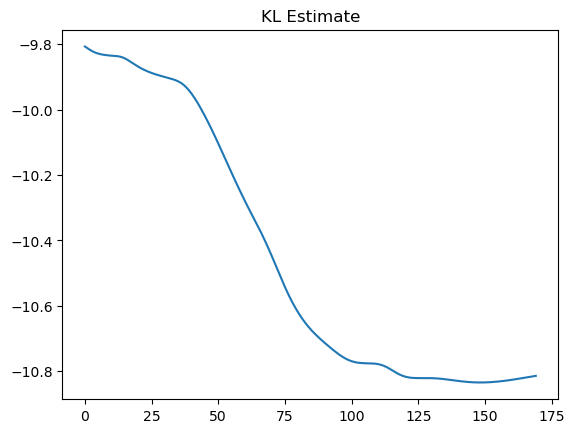

In [81]:
wass_kl_df = pd.DataFrame(np.array(KL_all))
plt.figure()
wass_kl_df.plot(title = 'KL Estimate', legend = False)

In [82]:
# Save the list of arrays to a file using np.save
np.save('Lambda_list_gnk_tau.npy', Lambda_list)

In [90]:
Lambda_list = np.load('Lambda_list_gnk_tau.npy', allow_pickle=True)

In [91]:
# Transform from original validation using transformations
wass_val_n_summary_statistics = (val_n_summary_statistics - scaler_mean) / scaler_std
for i in range(len(Lambda_list)):
    wass_val_n_summary_statistics = transform_auto(Lambda_list[i], wass_val_n_summary_statistics)[0]
    transformed_val_n_summary_statistics = wass_val_n_summary_statistics

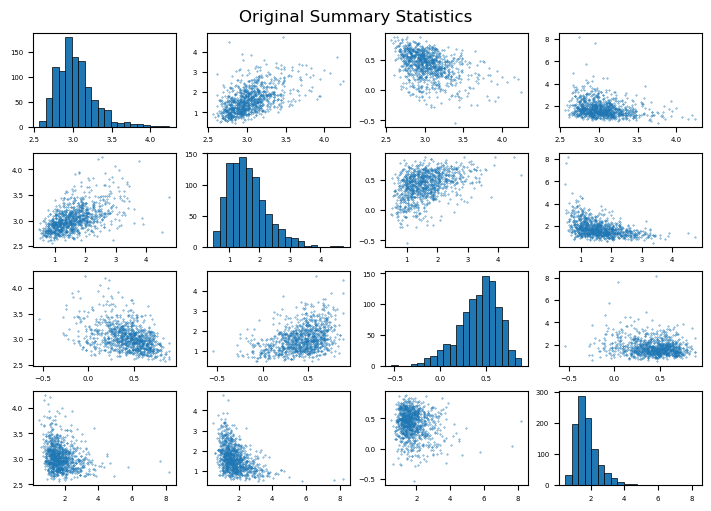

In [84]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(val_n_summary_statistics[:1000,x], val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()


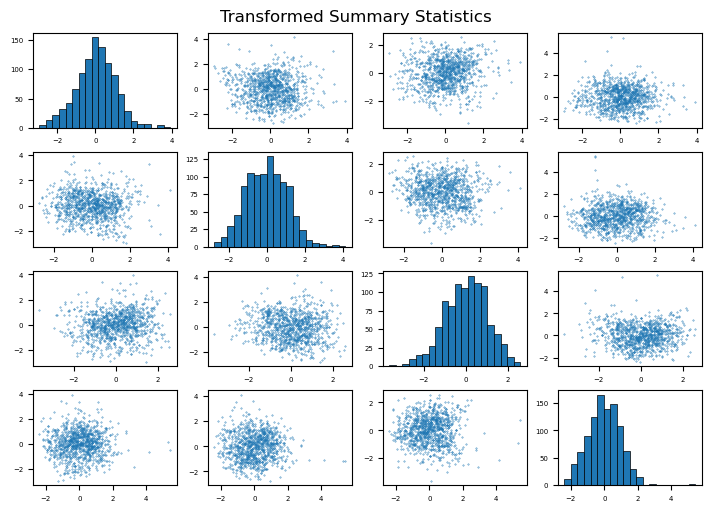

In [86]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(wass_val_n_summary_statistics[:1000,x], wass_val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

In [92]:
def normality_test(array1, array2):
    from scipy.stats import mstats
    multivariate_data = np.hstack((array1, array2))
    # Perform Mardia's multivariate normality test
    test_statistic, p_value = mstats.normaltest(multivariate_data)

    # Set the significance level (alpha)
    alpha = 0.01

    # Interpret the results for array
    if p_value < alpha:
      if p_value == 0.0:
        min_p_value = np.finfo(float).tiny
        # Calculate the p-value, ensuring it's not smaller than the minimum
        p_value = max(np.finfo(float).eps, min_p_value)
        print(f"The data is not multivariate normally distributed (p-value = {p_value})")
      else:
        print(f"The data is not multivariate normally distributed (p-value = {p_value})")
    else:
        print(f"The data appears to be multivariate normally distributed (p-value = {p_value})")

# Define a function to remove outliers based on IQR
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR # 2 times the standard deviation of the data
    upper_bound = Q3 + 2 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# For original summary statistics
normality_test(val_n_summary_statistics[:,0], val_n_summary_statistics[:,1])
normality_test(val_n_summary_statistics[:,2], val_n_summary_statistics[:,3])
normality_test(val_n_summary_statistics[:,1], val_n_summary_statistics[:,3])
normality_test(val_n_summary_statistics[:,0], val_n_summary_statistics[:,3])

# For transformed summary statistics
# Remove outliers
array1 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,0])
array2 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,1])
array3 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,2])
array4 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,3])

normality_test(array1, array2)
normality_test(array3, array4)
normality_test(array2, array4)
normality_test(array1, array4)

The data is not multivariate normally distributed (p-value = 2.220446049250313e-16)
The data is not multivariate normally distributed (p-value = 2.220446049250313e-16)
The data is not multivariate normally distributed (p-value = 2.220446049250313e-16)
The data is not multivariate normally distributed (p-value = 6.847709814395453e-20)
The data is not multivariate normally distributed (p-value = 0.009915255236834425)
The data is not multivariate normally distributed (p-value = 4.556942520382826e-16)
The data is not multivariate normally distributed (p-value = 1.0095436971593117e-13)
The data is not multivariate normally distributed (p-value = 2.5575961876945926e-06)


In [57]:
# Load the StandardScaler object from the file
scaler = load('scaler_gnk.joblib')
def nf_transform(Lambda_list, n_summary_statistics):
    n_summary_statistics = scaler.transform(n_summary_statistics)
    for i in range(len(Lambda_list)):
        n_summary_statistics = transform_auto(Lambda_list[i], n_summary_statistics)[0]
    return n_summary_statistics

In [21]:
def summary_statistics(theta, mixture_obj_seq, num_samples, num_datasets):
    n_summary_statistics = np.zeros((num_datasets, num_latent))
    for i in range(0, num_datasets):
        y = simulate_gandk(theta, num_samples)
        n_summary_statistics[i,:] = compute_summary_statistics(y)
    transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, n_summary_statistics)

    sample_mean = np.mean(transformed_summary_statistics, axis = 0)
    cov = np.cov(np.array(transformed_summary_statistics).T)
    sample_variance = cov + (np.eye(cov.shape[0]) * 5 * 1e-7)
    return sample_mean, sample_variance

In [22]:
def mean_adjustment_summary_statistics(adjusted_theta, mixture_obj_seq, num_samples, num_datasets):
    theta = adjusted_theta[:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, mixture_obj_seq, num_samples, num_datasets)
    adjusted_sample_mean = sample_mean + np.diag(scipy.linalg.sqrtm(sample_variance)) * Gamma
    return adjusted_sample_mean, sample_variance

In [23]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

# def unbiased_log_likelihood(theta):
#     ss = summary_statistics(theta, num_samples, num_datasets)
#     sample_mean = ss[0]
#     sample_variance = ss[1]
#     # diff_mean_s = actual_summary_statistics - sample_mean
#     # part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
#     # # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
#     # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1

#     u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)

#     return u_est_log_likelihood

def prior_gamma(gamma, sigma_latent, num_latent): 
    log_prior = multivariate_normal.logpdf(gamma, cov= sigma_latent * np.identity(num_latent))
    return log_prior

def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, num_samples, num_datasets, actual_summary_statistics, mixture_obj_seq):
    mean_adj_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, mixture_obj_seq, num_samples, num_datasets)
    adjusted_sample_mean = mean_adj_ss[0]
    sample_variance = mean_adj_ss[1]

    # mean_u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= sample_variance)

    diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    part1 = diff_mean_s.T @ my_inv(sample_variance) @ diff_mean_s
    mean_u_est_log_likelihood = -1/2 * np.linalg.slogdet(sample_variance)[1] - 1/2 * part1
    return mean_u_est_log_likelihood

def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    part1 = (Gamma - mean_nuissance).T @ my_inv(variance_nuissance) @ (Gamma - mean_nuissance)
    nuissance_mean_u_est_log_likelihood = -1/2 * np.linalg.slogdet(variance_nuissance)[1] - part1
    # nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [24]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 4 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([true_theta[0], np.log(true_theta[1]), true_theta[2], np.log(true_theta[3])])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        l_0 = np.array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
                        [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
                        [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
                        [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])

        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                rng = np.random.default_rng()
                theta_0_samples = rng.multivariate_normal(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in range(self.samples):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = theta_tilde_0[0]
                    beta_0 = np.exp(theta_tilde_0[1])
                    gamma_0 = theta_tilde_0[2]
                    delta_0 = np.exp(theta_tilde_0[3])
                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])

                    ss_0 = summary_statistics(theta_0, mixture_obj_seq, n_samples, num_datasets)
                    sample_mean_0 = ss_0[0]
                    sample_variance_0 = ss_0[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_var = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance_0)))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / 10 + diag_var.T @ my_inv(sample_variance_0) @ diag_var)
                    diff_mean = self.actual_summary_statistics - sample_mean_0
                    mean_nuissance_p2 = diag_var @ my_inv(sample_variance_0) @ diff_mean
                    mean_nuissance_0 = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_0 = mean_nuissance_p1  + (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

                    # GENERATE GAMMA
                    rng = np.random.default_rng()
                    Gamma = rng.multivariate_normal(mean = mean_nuissance_0, cov = variance_nuissance_0)
                    # Gamma = Gamma[0]
                    adjusted_theta_0 = np.concatenate((theta_0, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_0, n_samples, num_datasets, self.actual_summary_statistics, mixture_obj_seq)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_0, variance_nuissance_0)

                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + prior_gamma(Gamma, 10, num_latent) + llh - self.fun_log_q(theta_tilde_0, mu_0, l_0) - llh_gamma

                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                rng = np.random.default_rng()
                theta_q_samples = rng.multivariate_normal(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = theta_tilde_q[0]
                    beta_q = np.exp(theta_tilde_q[1])
                    gamma_q = theta_tilde_q[2]
                    delta_q = np.exp(theta_tilde_q[3])

                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])

                    ss_q = summary_statistics(theta_q, mixture_obj_seq, n_samples, num_datasets)
                    sample_mean_q = ss_q[0]
                    sample_variance_q = ss_q[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_var = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance_q)))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / 10 + diag_var.T @ my_inv(sample_variance_q) @ diag_var)
                    diff_mean = self.actual_summary_statistics - sample_mean_q
                    mean_nuissance_p2 = diag_var @ my_inv(sample_variance_q) @ diff_mean
                    mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_q = mean_nuissance_p1  + (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

      
                    # GENERATE GAMMA
                    rng = np.random.default_rng()
                    Gamma = rng.multivariate_normal(mean = mean_nuissance_q, cov = variance_nuissance_q)
                    # Gamma = Gamma[0]
                    adjusted_theta_q = np.concatenate((theta_q, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, n_samples, num_datasets, self.actual_summary_statistics, mixture_obj_seq)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + prior_gamma(Gamma, 10, num_latent) + llh - self.fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [25]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))
actual_summary_statistics

array([[2.96978227, 1.45609898, 0.4837584 , 2.00723605]])

In [26]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, actual_summary_statistics)
transformed_summary_statistics[0]

array([-0.00631865, -0.03321667,  0.22897961,  0.56710931])

In [25]:
# Set hyperparameters
vb = GVB(200, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [00:48<67:57:41, 48.94s/it]

LB -25.85768559605213


  0%|          | 2/5000 [01:39<69:35:35, 50.13s/it]

LB -22.91257873725345


  0%|          | 3/5000 [02:41<76:36:05, 55.19s/it]

LB -23.941230322998685


  0%|          | 4/5000 [03:32<74:17:30, 53.53s/it]

LB -23.114987060355578


  0%|          | 5/5000 [04:23<73:09:22, 52.73s/it]

LB -23.235210365959556


  0%|          | 6/5000 [05:15<73:04:10, 52.67s/it]

LB -20.835673362816607


  0%|          | 7/5000 [06:06<72:08:29, 52.01s/it]

LB -23.744577162537567


  0%|          | 8/5000 [06:57<71:34:27, 51.62s/it]

LB -24.073482172694426


  0%|          | 9/5000 [07:55<74:25:37, 53.68s/it]

LB -22.01626965682025


  0%|          | 10/5000 [08:51<75:23:59, 54.40s/it]

LB -22.48429297237324


  0%|          | 11/5000 [09:40<72:53:50, 52.60s/it]

LB -22.10732338804233


  0%|          | 12/5000 [10:29<71:31:47, 51.63s/it]

LB -22.956655904535474


  0%|          | 13/5000 [11:17<70:04:11, 50.58s/it]

LB -23.61532848189282


  0%|          | 14/5000 [12:08<70:09:29, 50.66s/it]

LB -21.3164691276785


  0%|          | 15/5000 [12:58<69:51:49, 50.45s/it]

LB -22.837618675344256


  0%|          | 16/5000 [13:47<69:04:13, 49.89s/it]

LB -22.824818768340496


  0%|          | 17/5000 [14:36<68:56:23, 49.81s/it]

LB -21.489716350775396


  0%|          | 18/5000 [15:26<68:49:17, 49.73s/it]

LB -22.853701976314834


  0%|          | 19/5000 [16:15<68:35:00, 49.57s/it]

LB -24.57117853444848


  0%|          | 20/5000 [17:06<68:59:05, 49.87s/it]

LB -22.705213074046288


  0%|          | 21/5000 [17:56<69:23:15, 50.17s/it]

LB -22.694319043924725


  0%|          | 22/5000 [18:46<69:00:03, 49.90s/it]

LB -22.919533461575906


  0%|          | 23/5000 [19:35<68:49:39, 49.78s/it]

LB -22.3586446258717


  0%|          | 24/5000 [20:24<68:24:52, 49.50s/it]

LB -22.045210506231214


  0%|          | 25/5000 [21:15<69:08:45, 50.04s/it]

LB -22.274437463097737


  1%|          | 26/5000 [22:05<68:47:09, 49.78s/it]

LB -21.241291438298695


  1%|          | 27/5000 [22:55<69:04:44, 50.01s/it]

LB -22.827491601433813


  1%|          | 28/5000 [23:43<68:24:22, 49.53s/it]

LB -21.889563994015184


  1%|          | 29/5000 [24:34<68:41:42, 49.75s/it]

LB -20.647129784471776


  1%|          | 30/5000 [25:24<68:51:37, 49.88s/it]

LB -22.334307631550136


  1%|          | 31/5000 [26:11<67:44:44, 49.08s/it]

LB -22.5924885020811


  1%|          | 32/5000 [27:01<68:16:09, 49.47s/it]

LB -23.83435077921711


  1%|          | 33/5000 [27:49<67:27:27, 48.89s/it]

LB -21.742545166361893


  1%|          | 34/5000 [28:35<66:04:17, 47.90s/it]

LB -22.44645944958893


  1%|          | 35/5000 [29:20<65:12:25, 47.28s/it]

LB -23.492725626125704


  1%|          | 36/5000 [30:06<64:38:05, 46.87s/it]

LB -22.50001834992685


  1%|          | 37/5000 [30:52<64:03:49, 46.47s/it]

LB -22.286124481711184


  1%|          | 38/5000 [31:39<64:11:30, 46.57s/it]

LB -21.828774783151584


  1%|          | 39/5000 [32:24<63:47:20, 46.29s/it]

LB -22.094905776529913


  1%|          | 40/5000 [33:10<63:34:00, 46.14s/it]

LB -21.82100970352836


  1%|          | 41/5000 [33:56<63:16:52, 45.94s/it]

LB -22.28412971576258


  1%|          | 42/5000 [34:41<62:57:50, 45.72s/it]

LB -21.486379059569586


  1%|          | 43/5000 [35:27<63:14:43, 45.93s/it]

LB -22.513367216357636


  1%|          | 44/5000 [36:13<63:05:56, 45.83s/it]

LB -21.714245254313855


  1%|          | 45/5000 [37:00<63:28:08, 46.11s/it]

LB -22.049288048659868


  1%|          | 46/5000 [37:46<63:28:44, 46.13s/it]

LB -21.60495992478595


  1%|          | 47/5000 [38:32<63:37:44, 46.25s/it]

LB -23.077757884566868


  1%|          | 48/5000 [39:21<64:49:09, 47.12s/it]

LB -21.72020347737761


  1%|          | 49/5000 [40:11<65:45:49, 47.82s/it]

LB -21.585951292848755


  1%|          | 50/5000 [41:01<66:52:47, 48.64s/it]

LB -21.80603830875145


  1%|          | 51/5000 [41:49<66:23:37, 48.30s/it]

LB Smoothed -22.435713845855425


  1%|          | 52/5000 [42:51<72:13:06, 52.54s/it]

LB Smoothed -22.431635275982366


  1%|          | 53/5000 [43:42<71:29:32, 52.03s/it]

LB Smoothed -22.40117154673512


  1%|          | 54/5000 [44:36<72:00:24, 52.41s/it]

LB Smoothed -22.3679081921119


  1%|          | 55/5000 [45:25<70:49:31, 51.56s/it]

LB Smoothed -22.346459688948393


  1%|          | 56/5000 [46:13<69:12:28, 50.39s/it]

LB Smoothed -22.366904813510054


  1%|          | 57/5000 [47:01<68:25:18, 49.83s/it]

LB Smoothed -22.33864089001329


  1%|          | 58/5000 [47:50<67:51:00, 49.43s/it]

LB Smoothed -22.300473406364382


  1%|          | 59/5000 [48:37<66:44:46, 48.63s/it]

LB Smoothed -22.32312469548619


  1%|          | 60/5000 [49:29<68:23:34, 49.84s/it]

LB Smoothed -22.32321522091139


  1%|          | 61/5000 [50:23<69:50:42, 50.91s/it]

LB Smoothed -22.340293110938216


  1%|          | 62/5000 [51:13<69:31:30, 50.69s/it]

LB Smoothed -22.304188032282926


  1%|▏         | 63/5000 [52:03<69:10:48, 50.45s/it]

LB Smoothed -22.265084337033624


  1%|▏         | 64/5000 [52:57<70:49:09, 51.65s/it]

LB Smoothed -22.27576744896786


  1%|▏         | 65/5000 [53:51<71:31:52, 52.18s/it]

LB Smoothed -22.256975375316152


  1%|▏         | 66/5000 [54:44<71:57:11, 52.50s/it]

LB Smoothed -22.219545237166187


  1%|▏         | 67/5000 [55:35<71:23:18, 52.10s/it]

LB Smoothed -22.23080284953095


  1%|▏         | 68/5000 [56:22<69:28:21, 50.71s/it]

LB Smoothed -22.209218585160546


  1%|▏         | 69/5000 [57:10<68:21:17, 49.90s/it]

LB Smoothed -22.156532217495503


  1%|▏         | 70/5000 [57:59<67:58:50, 49.64s/it]

LB Smoothed -22.128382799790632


  1%|▏         | 71/5000 [58:49<67:44:01, 49.47s/it]

LB Smoothed -22.092995975280505


  1%|▏         | 72/5000 [59:39<68:10:48, 49.81s/it]

LB Smoothed -22.080817424016978


  1%|▏         | 73/5000 [1:00:29<68:03:04, 49.72s/it]

LB Smoothed -22.055265160755944


  1%|▏         | 74/5000 [1:01:19<68:07:57, 49.79s/it]

LB Smoothed -22.04791106602859


  2%|▏         | 75/5000 [1:02:07<67:30:26, 49.35s/it]

LB Smoothed -22.03307609603456


  2%|▏         | 76/5000 [1:02:53<66:19:32, 48.49s/it]

LB Smoothed -22.03976422783688


  2%|▏         | 77/5000 [1:03:40<65:24:25, 47.83s/it]

LB Smoothed -22.024875316178914


  2%|▏         | 78/5000 [1:04:26<64:57:40, 47.51s/it]

LB Smoothed -22.037237418761926


  2%|▏         | 79/5000 [1:05:13<64:24:30, 47.12s/it]

LB Smoothed -22.057535488608053


  2%|▏         | 80/5000 [1:05:59<64:09:49, 46.95s/it]

LB Smoothed -22.04589781272989


  2%|▏         | 81/5000 [1:06:47<64:25:48, 47.15s/it]

LB Smoothed -22.01249487351406


  2%|▏         | 82/5000 [1:07:33<63:59:14, 46.84s/it]

LB Smoothed -21.95852318200758


  2%|▏         | 83/5000 [1:08:19<63:42:13, 46.64s/it]

LB Smoothed -21.939996634210985


  2%|▏         | 84/5000 [1:09:06<63:52:30, 46.78s/it]

LB Smoothed -21.898045784341228


  2%|▏         | 85/5000 [1:09:52<63:33:07, 46.55s/it]

LB Smoothed -21.839154395034367


  2%|▏         | 86/5000 [1:10:40<64:07:26, 46.98s/it]

LB Smoothed -21.80706250829244


  2%|▏         | 87/5000 [1:11:26<63:36:20, 46.61s/it]

LB Smoothed -21.795680368340797


  2%|▏         | 88/5000 [1:12:11<62:58:36, 46.16s/it]

LB Smoothed -21.795873854585682


  2%|▏         | 89/5000 [1:12:57<62:42:04, 45.96s/it]

LB Smoothed -21.7910348484329


  2%|▏         | 90/5000 [1:13:43<62:44:06, 46.00s/it]

LB Smoothed -21.77490495198848


  2%|▏         | 91/5000 [1:14:35<65:06:21, 47.75s/it]

LB Smoothed -21.757911870484772


  2%|▏         | 92/5000 [1:15:25<66:14:09, 48.58s/it]

LB Smoothed -21.767439794069908


  2%|▏         | 93/5000 [1:16:15<66:46:20, 48.99s/it]

LB Smoothed -21.736583652608886


  2%|▏         | 94/5000 [1:17:10<69:02:50, 50.67s/it]

LB Smoothed -21.739117798439445


  2%|▏         | 95/5000 [1:18:00<68:48:56, 50.51s/it]

LB Smoothed -21.719487998954584


  2%|▏         | 96/5000 [1:18:48<67:44:43, 49.73s/it]

LB Smoothed -21.69800667889658


  2%|▏         | 97/5000 [1:19:36<67:15:29, 49.38s/it]

LB Smoothed -21.661310523160353


  2%|▏         | 98/5000 [1:20:26<67:24:32, 49.50s/it]

LB Smoothed -21.666274317640184


  2%|▏         | 99/5000 [1:21:15<67:07:45, 49.31s/it]

LB Smoothed -21.665915310722948


  2%|▏         | 100/5000 [1:22:04<66:58:26, 49.21s/it]

LB Smoothed -21.665809140655075


  2%|▏         | 101/5000 [1:22:52<66:42:42, 49.02s/it]

LB Smoothed -21.63694271637032


  2%|▏         | 102/5000 [1:23:45<68:14:10, 50.15s/it]

LB Smoothed -21.61066018098713


  2%|▏         | 103/5000 [1:24:41<70:39:55, 51.95s/it]

LB Smoothed -21.610649457660198


  2%|▏         | 104/5000 [1:25:32<70:10:09, 51.60s/it]

LB Smoothed -21.59900959382326


  2%|▏         | 105/5000 [1:26:21<69:14:42, 50.93s/it]

LB Smoothed -21.573872375995162


  2%|▏         | 106/5000 [1:27:11<68:51:48, 50.66s/it]

LB Smoothed -21.541349009670583


  2%|▏         | 107/5000 [1:28:06<70:21:06, 51.76s/it]

LB Smoothed -21.517467778478284


  2%|▏         | 108/5000 [1:28:58<70:38:29, 51.98s/it]

LB Smoothed -21.46085488781015


  2%|▏         | 109/5000 [1:29:47<69:13:33, 50.95s/it]

LB Smoothed -21.432724358957042


  2%|▏         | 110/5000 [1:30:38<69:29:00, 51.15s/it]

LB Smoothed -21.391861097370136


  2%|▏         | 111/5000 [1:31:30<69:45:26, 51.37s/it]

LB Smoothed -21.38863019063426


  2%|▏         | 112/5000 [1:32:21<69:24:43, 51.12s/it]

LB Smoothed -21.368628960431113


  2%|▏         | 113/5000 [1:33:10<68:41:05, 50.60s/it]

LB Smoothed -21.35067227963068


  2%|▏         | 114/5000 [1:33:59<68:00:22, 50.11s/it]

LB Smoothed -21.31998203388864


  2%|▏         | 115/5000 [1:34:47<67:10:21, 49.50s/it]

LB Smoothed -21.31824471093984


  2%|▏         | 116/5000 [1:35:38<67:29:58, 49.75s/it]

LB Smoothed -21.301555770630245


  2%|▏         | 117/5000 [1:36:34<70:01:19, 51.62s/it]

LB Smoothed -21.302674538105723


  2%|▏         | 118/5000 [1:37:22<68:36:33, 50.59s/it]

LB Smoothed -21.305447061341283


  2%|▏         | 119/5000 [1:38:11<67:48:22, 50.01s/it]

LB Smoothed -21.31251116805529


  2%|▏         | 120/5000 [1:39:01<68:00:23, 50.17s/it]

LB Smoothed -21.31937662733652


  2%|▏         | 121/5000 [1:39:49<66:57:26, 49.40s/it]

LB Smoothed -21.296683988307255


  2%|▏         | 122/5000 [1:40:41<68:08:16, 50.29s/it]

LB Smoothed -21.31806923414685


  2%|▏         | 123/5000 [1:41:30<67:46:46, 50.03s/it]

LB Smoothed -21.327984359495986


  2%|▏         | 124/5000 [1:42:24<69:20:44, 51.20s/it]

LB Smoothed -21.326348360099594


  2%|▎         | 125/5000 [1:43:19<70:52:14, 52.34s/it]

LB Smoothed -21.2938569667857


  3%|▎         | 126/5000 [1:44:10<70:09:30, 51.82s/it]

LB Smoothed -21.26500089303231


  3%|▎         | 127/5000 [1:45:01<69:49:57, 51.59s/it]

LB Smoothed -21.258941959750157


  3%|▎         | 128/5000 [1:45:52<69:45:29, 51.55s/it]

LB Smoothed -21.233293502522216


  3%|▎         | 129/5000 [1:46:41<68:21:40, 50.52s/it]

LB Smoothed -21.219218456571657


  3%|▎         | 130/5000 [1:47:31<68:15:31, 50.46s/it]

LB Smoothed -21.219587179388995


  3%|▎         | 131/5000 [1:48:20<67:33:24, 49.95s/it]

LB Smoothed -21.214627331117132


  3%|▎         | 132/5000 [1:49:10<67:48:42, 50.15s/it]

LB Smoothed -21.22226339328956


  3%|▎         | 133/5000 [1:50:04<69:19:29, 51.28s/it]

LB Smoothed -21.242851032107914


  3%|▎         | 134/5000 [1:50:56<69:20:44, 51.30s/it]

LB Smoothed -21.25345489968375


  3%|▎         | 135/5000 [1:51:47<69:26:29, 51.39s/it]

LB Smoothed -21.266398720578568


  3%|▎         | 136/5000 [1:52:40<70:04:45, 51.87s/it]

LB Smoothed -21.27635467955855


  3%|▎         | 137/5000 [1:53:30<69:25:02, 51.39s/it]

LB Smoothed -21.25455456374887


  3%|▎         | 138/5000 [1:54:20<68:43:17, 50.88s/it]

LB Smoothed -21.246006647689303


  3%|▎         | 139/5000 [1:55:09<68:03:48, 50.41s/it]

LB Smoothed -21.250180312091363


  3%|▎         | 140/5000 [1:56:00<67:57:26, 50.34s/it]

LB Smoothed -21.267286712866085


  3%|▎         | 141/5000 [1:56:51<68:13:36, 50.55s/it]

LB Smoothed -21.235509191337872


  3%|▎         | 142/5000 [1:57:41<68:04:41, 50.45s/it]

LB Smoothed -21.219089310497623


  3%|▎         | 143/5000 [1:58:29<67:06:01, 49.73s/it]

LB Smoothed -21.19939888869546


  3%|▎         | 144/5000 [1:59:17<66:23:44, 49.22s/it]

LB Smoothed -21.20408630452043


  3%|▎         | 145/5000 [2:00:07<66:37:46, 49.41s/it]

LB Smoothed -21.216567276546265


  3%|▎         | 146/5000 [2:00:56<66:37:46, 49.42s/it]

LB Smoothed -21.196713236815363


  3%|▎         | 147/5000 [2:01:48<67:22:49, 49.98s/it]

LB Smoothed -21.167376217069414


  3%|▎         | 148/5000 [2:02:39<68:06:28, 50.53s/it]

LB Smoothed -21.17446344225379


  3%|▎         | 149/5000 [2:03:30<68:13:57, 50.64s/it]

LB Smoothed -21.164109235636563


  3%|▎         | 150/5000 [2:04:20<68:03:41, 50.52s/it]

LB Smoothed -21.170675742274565


  3%|▎         | 151/5000 [2:05:11<68:00:51, 50.50s/it]

LB Smoothed -21.198238648711385


  3%|▎         | 152/5000 [2:06:01<67:53:26, 50.41s/it]

LB Smoothed -21.193909290858773


  3%|▎         | 153/5000 [2:06:51<67:33:26, 50.18s/it]

LB Smoothed -21.177011224457583


  3%|▎         | 154/5000 [2:07:41<67:32:14, 50.17s/it]

LB Smoothed -21.193428724849518


  3%|▎         | 155/5000 [2:08:31<67:26:28, 50.11s/it]

LB Smoothed -21.186063129057686


  3%|▎         | 156/5000 [2:09:22<67:55:22, 50.48s/it]

LB Smoothed -21.20043884965833


  3%|▎         | 157/5000 [2:10:13<67:58:59, 50.53s/it]

LB Smoothed -21.210885592553986


  3%|▎         | 158/5000 [2:11:02<67:12:23, 49.97s/it]

LB Smoothed -21.1872526132016


<AxesSubplot: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

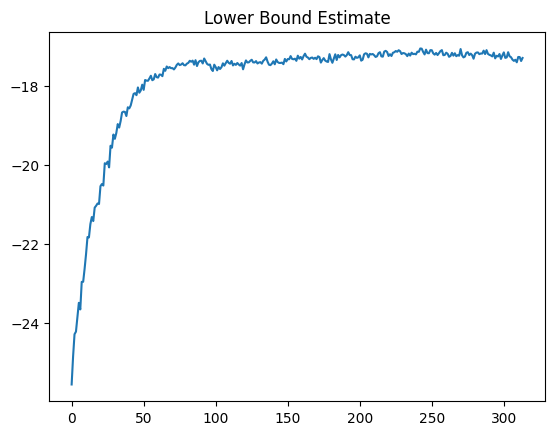

In [44]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

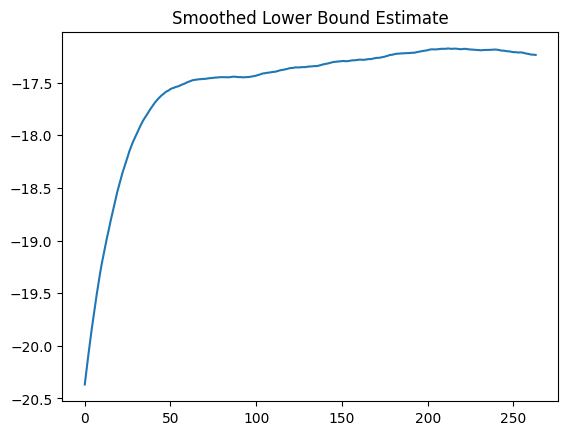

In [45]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [34]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 10000)
best_alpha = best_theta_tilde[0]
best_beta = np.exp(best_theta_tilde[1])
best_gamma = best_theta_tilde[2]
best_delta = np.exp(best_theta_tilde[3])
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([1.21788474, 8.328837  , 1.21265657, 7.90678226])

Text(0.5, 1.0, 'Posterior density of alpha')

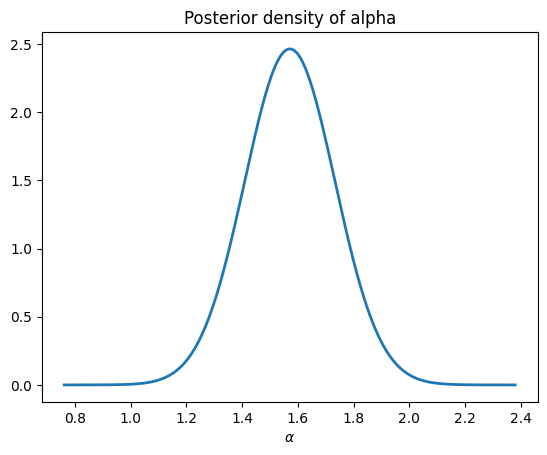

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-5*np.std(best_alpha)), (np.mean(best_alpha)+5*np.std(best_alpha)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_alpha), np.std(best_alpha))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

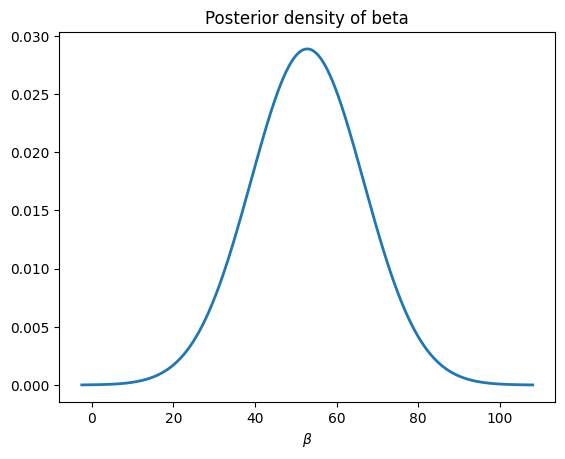

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_beta), np.std(best_beta))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

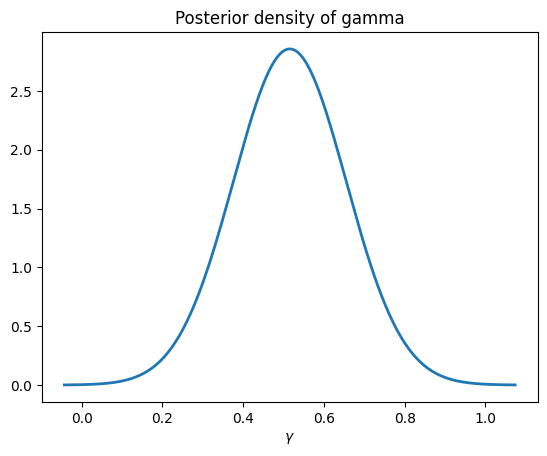

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_gamma), np.std(best_gamma))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

## RUN MCMC WITH ADAPTIVE RANDOM WALK

In [ ]:
num_samples = 20000
num_burnin = 0.2 * num_samples
sigma_latent = 10

In [ ]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = np.ones((samples, theta_size))  # posterior of all weights and bias over all samples
    pos_theta_tilde = np.ones((samples, theta_size))

    theta_tilde = np.array([np.log((true_theta[0]-0)/(5-true_theta[0])), np.log((true_theta[1]-0)/(2-true_theta[1])), np.log((true_theta[2]-0)/(3-true_theta[2])), np.log((true_theta[3]-0)/(1-true_theta[3]))])

    alpha = theta_tilde[0]
    beta = np.exp(theta_tilde[1])
    gamma = theta_tilde[2]
    delta = np.exp(theta_tilde[3])

    theta = np.array([alpha, beta, gamma, delta])

    # GENERATE GAMMA
    ss = summary_statistics(theta, mixture_obj_seq, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]

    # Find mean and variance for p(gamma | theta, obs)

    diag_var = np.zeros((num_latent, num_latent))
    np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance)))
    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

    variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

    # GENERATE GAMMA
    rng = np.random.default_rng()
    Gamma_init = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
    # Gamma = Gamma[0]
    adjusted_theta = np.concatenate((theta, Gamma_init))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, n_samples, num_datasets, actual_summary_statistics)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma_init, mean_nuissance, variance_nuissance)

    # --------------------- 

    prior_current = prior(theta_tilde)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        if i < 2000:
#             theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
            theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * best_Sigma))
        else:
            if i % 500 == 0:
                Sign = np.cov(pos_theta_tilde[0:i, :].T)
            u_proposal = random.uniform(0, 1)
            if u_proposal < 0.05:
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * best_Sigma))    
            else:
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = (2.38**2/theta_size) * Sign)
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((1.1**2.5/theta_size) * best_Sigma))

        alpha_prop = theta_proposal_tilde[0]
        beta_prop = np.exp(theta_proposal_tilde[1])
        gamma_prop = theta_proposal_tilde[2]
        delta_prop = np.exp(theta_proposal_tilde[3])

        theta_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

        # GENERATE GAMMA
        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_variance = ss[1]

        # Find mean and variance for p(gamma | theta, obs)

        diag_var = np.zeros((num_latent, num_latent))
        np.fill_diagonal(diag_var, np.diag(scipy.linalg.sqrtm(sample_variance)))
        mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

        variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

        # GENERATE GAMMA
        rng = np.random.default_rng()
        Gamma = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
        # Gamma = Gamma[0]
        adjusted_theta_proposal = np.concatenate((theta_proposal, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, n_samples, num_datasets, actual_summary_statistics)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)
        # --------------------- 

        prior_proposal = prior(theta_proposal_tilde)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = random.uniform(0, 1)

        if u < mh_prob:
            # Update position 
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta_tilde = theta_proposal_tilde
            theta = theta_proposal
            pos_theta_tilde[i + 1,] = theta_proposal_tilde	
            pos_theta[i + 1,] = theta_proposal
            print(i, pos_theta[i + 1,])

        else:
            pos_theta_tilde[i + 1,] = pos_theta_tilde[i,]
            pos_theta[i + 1,] = pos_theta[i,]

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, pos_theta_tilde, accept_ratio)

In [ ]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)